## HELP_NGO_PCA_K-Means_Clustering_Assignment

* __Problem Statement__

   - HELP International is an international humanitarian NGO that is committed to fighting poverty and providing the people of backward countries with basic amenities and relief during the time of disasters and natural calamities. It runs a lot of operational projects from time to time along with advocacy drives to raise awareness as well as for funding purposes.
 
   - After the recent funding programmes, they have been able to raise around $10 million.Now the CEO of the NGO needs to decide how to use this money strategically and effectively. The significant issues that come while making this decision are mostly related to choosing the countries that are in the direst need of aid.
 
* __Business Goal__ 

   - And this is where you come in as a data analyst. Your job is to categorise the countries using some socio-economic and health factors that determine the overall development of the country. Then you need to suggest the countries which the CEO needs to focus on the most.  The datasets containing those socio-economic factors and the corresponding data dictionary are provided below.

## Approach of my analysis to the problem

__High Level Approach__
As there are different approaches both in PCA, K-Means and Hirerchial Cluster to select the features and cluster, I would create 2 models with different scaling methods. 
* The basis for 2 models is as follows:
  1. __Model I:__ 
      - Scaling with Normalizer
      - Perform Dimensionality Reduction using PCA
      - Select no of PCA's which give maximum variance
      - Perform a check with Hopkins Statistic if cluster tendency is good or not
      - Proceed with Hirerchial Clustering, cut the clusters (Linkage - Single, Complete and Ward) and visualize the PC's
      - Proceed with K-Means Clustering, evaluate different K,  select K, and visualize PC's.
  
  2. __Model II:__  
      - Scaling with Standard Scaler
      - Perform Dimensionality Reduction using PCA
      - Select no of PCA's which give maximum variance
      - Perform a check with Hopkins Statistic if cluster tendency is good or not
      - Proceed with Hirerchial Clustering, cut the clusters (Linkage - Single, Complete and Ward) and visualize the PC's
      - Proceed with K-Means Clustering, evaluate different K,  select K, and visualize PC's.
   
__Based on the inferences from each of the model, I would try to select the best model based on the cluster evaluation metrics__

## Steps invoved in this notebook

1. Problem Statement
2. Approach of my analysis to the problem
3. Steps involved in this notebook
4. Import Python Libraries for data analysis and ML 
5. Local user defined functions
6. Sourcing the Data
7. Inspect, Clean and Transform the Data
8. Visualising and Exploring the data
9. Preparing the data for modelling(train-test split, rescaling etc)
10. Model-I - Feature Selection using PCA and Clustering using Hirerchial and K-Means
11. Model-II - Feature Selection using PCA and Clustering using Hirerchial and K-Means
12. Model Evalution and Selection of the Model
13. Visualize the Clusters and Analyze the Clusters with original data
14. Identification of the countries which are need of the aid

## Import Python Functions

In [1]:
# Python libraries for Data processing and analysis
import time as time
strt = time.time()
import pandas as pd
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 100)
pd.options.mode.use_inf_as_na = True
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import datetime
import glob
from matplotlib.pyplot import figure
import warnings
import math
import itertools
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")
from math import sqrt
import re

# ML common Libraries
import statsmodels
import statsmodels.api as sm
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler,OrdinalEncoder,LabelEncoder,RobustScaler,Normalizer

# ML Feature Engineering
from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA as IPCA

# Clustering Libraries
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage, dendrogram, cut_tree

from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
import numpy as np
from math import isnan

## Local User Defined Functions

### Local functions for data overview and data cleaning

In [2]:
# Local classes and Local flags

# Local Classes
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'
    
# Debug flag for investigative purpose
DEBUG = 0

# Default random_state
rndm_stat = 1

In [3]:
# local functions

# Function to read a file & Store it in Pandas
# read_file takes either csv or excel file as input and reuturns a pandas DF and
# also prints head, tail, description, info and shape of the DF
def read_file(l_fname,l_path,head=0):
    i = l_fname.split(".")
    f_path = l_path+'/'+l_fname
    if DEBUG: print(f_path,i[0],i[1]) 
    if (i[1] == "xlsx"):
        l_df = pd.read_excel(f_path,header=head,encoding = "ISO-8859-1",infer_datetime_format=True)
    elif (i[1] == "csv"):
        l_df = pd.read_csv(f_path,header=head,encoding = "ISO-8859-1",infer_datetime_format=True)
    ov_df(l_df)
    return(l_df)

# Function to get the Overview of DataFrame
# take df as input and prints head, tail, description, info and shape of the DF
def ov_df(l_df):
    print(color.BOLD+color.PURPLE + 'Inspect and Explore the Dataset' + color.END)
    print("\n#####################  DataFrame Head  ######################")
    print(l_df.head(3))
    print("\n#####################  DataFrame Tail  ######################")
    print(l_df.tail(3))
    print("\n#####################  DataFrame Info  ######################")
    print(l_df.info())
    print("\n####################  DataFrame Columns  ####################")
    print(list(l_df.columns))
    print("\n####################  DataFrame Shape  ####################")
    print("No of Rows",l_df.shape[0])
    print("No of Columns",l_df.shape[1])

# Function per_col_null takes a df as input and prints summary of Null Values across Columns
def per_col_null(l_df):
    print("\n############  Missing Values of Columns in %  ############")
    col_null = round((l_df.isnull().sum().sort_values(ascending=False)/len(l_df))*100,4)
    print(col_null[col_null > 0])  

# Function to change the cast the column into different type
def col_cast(l_df,n_dtyp,*args):
    for l_c_name in args:
        l_df = l_df.astype({l_c_name:n_dtyp})
        print(l_df[l_c_name].describe())
    return(l_df)

    
def hopkins(X):
    d = X.shape[1]
    #d = len(vars) # columns
    n = len(X) # rows
    m = int(0.1 * n) 
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
 
    return H 

### Functions to plot

In [4]:
# Function to plot 2 or more box plots
# m_box_plt takes a df, dimensions of subplot (no of rows and columns) and variable list of columns
# to plot multiple boxplots
def m_box_plt(l_df,n_r,n_c,*args):
    j=1
    fig_h = n_r * 4
    plt.figure(1,figsize=(13,fig_h))
    # set palette 
    palette = itertools.cycle(sns.color_palette())
    sns.set(style="whitegrid",font_scale=1,palette='rainbow')
    for i in args:
        plt.subplot(n_r,n_c,j)
        sns.boxplot(l_df[i],orient="v")
        #sns.swarmplot(l_df[i],color=".25",orient="v")
        plt.title('Central Tendency of {}'.format(i),fontsize=12)
        j+=1
    plt.show()
    
#  Function to plot 2 or more box plots
# dist_plt takes a df, dimensions of subplot (no of rows and columns), variable list of columns
# to plot multiple comparitive distribution plots
def dist_plt(l_df,n_r,n_c,*args):
    j=1
    colrs = ["dummy","skyblue","red","olive","gold","teal","green","blue"]
    fig_h = n_r * 5
    plt.figure(1,figsize=(8,fig_h))
    sns.set(style="whitegrid",font_scale=0.8)
    for i in args:
        plt.subplot(n_r,n_c,j)
        ax = sns.distplot(l_df[i],bins=20,color=colrs[j])
        plt.title('Distribution of {}'.format(i),fontsize=10)
        j+=1
    plt.show()

# Function to plot 2 or more Seaborn count plots. 
# This function takes dataframe and variable no of arguments which are columns and do subplots based on the no of rows 
# and columns given
def cnt_plt(l_df,n_r,n_c,*args):
    j=1
    fig_h = n_r * 8
    plt.figure(1,figsize=(14,fig_h))
    sns.set(font_scale=1,palette='bright')
    rot = 25
    if n_c == 1:
        rot = 70
    for i in args:
        plt.subplot(n_r,n_c,j)
        ax = sns.countplot(l_df[i])
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=rot)
        total = len(l_df[i])
        plt.title('Univariate Analysis of variable {}'.format(i),fontsize=12)
        for p in ax.patches:
            percentage = '{:.1f}%'.format(100 * p.get_height()/total)
            x = p.get_x() + 0.3
            y = p.get_y() + p.get_height()
            ax.annotate(percentage, (x, y))
        j+=1
    plt.show()
    
#  Function to plot 2 or more box plots
# comp_box_plt takes a df, dimensions of subplot (no of rows and columns), dependent variable and variable list of columns
# to plot multiple comparitive box plots
def comp_box_plt(l_df,n_r,n_c,l_dep,*args):
    j=1
    rot = 0
    #if n_c == 1 and n_r == 1:
    #    rot = 90
    fig_h = n_r * 8
    plt.figure(1,figsize=(20,fig_h))
    # set palette 
    palette = itertools.cycle(sns.color_palette())
    sns.set(style="whitegrid",font_scale=1,palette='Set2')
    if l_dep == "M2_K_M_Lbls":
        k = "K-Means Clustering"
    else :
        k = l_dep

    for i in args:
        plt.subplot(n_r,n_c,j)
        sns.boxplot(y=i,x=l_dep,orient="v",data=l_df)
        ax = sns.stripplot(y=i,x=l_dep, data=l_df, color="red", jitter=0.2, size=3)
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=rot)
        plt.title('{} spread across {}'.format(i,k),fontsize=12)
        j+=1
    plt.show()      
        
#  Function to plot 2 or more box plots
# comp_box_plt takes a df, dimensions of subplot (no of rows and columns), dependent variable and variable list of columns
# to plot multiple comparitive box plots
def m_scatter_plt(l_df,n_r,n_c,*args):
    j=1
    fig_h = n_r * 5
    plt.figure(1,figsize=(13,fig_h))
    # set palette 
    #palette = itertools.cycle(sns.color_palette())
    sns.set(style="whitegrid",font_scale=1)
    for i in args:
        plt.subplot(n_r,n_c,j)
        sns.scatterplot(x = "PC1", y = "PC2", hue=i,data=l_df,palette="rainbow")
        if i == "K_M_Lbls":
            k = "K-Means Clustering"
        elif i == "Hr_Lbls":
            k = "Hirerchial Clustering with Complete Linkage"
        elif i == "wrd_cl_lbls":
            k = "Hirerchial Clustering with Ward Linkage"
        plt.title('Scatter Plot PC1 and PC2 with {}'.format(k),fontsize=12)
        j+=1
    plt.show()
  

## Sourcing the Data

### Read the Country-data.csv

In [5]:
# Set the path and file name
folder=r"C:\My Folders\OneDrive\Surface\Sadguru\Lakshmi\Study\IIIB_PGDS\ML1\Cluster_PCA_Assign"
file="Country-data.csv"

# Read file using local functions. read_file takes either csv or excel file as input and reuturns a pandas DF and
# also prints head, tail, description, info and shape of the DF
c_df = read_file(file,folder)

Inspect and Explore the Dataset

#####################  DataFrame Head  ######################
       country  child_mort  exports  health  imports  income  inflation  \
0  Afghanistan        90.2     10.0    7.58     44.9    1610       9.44   
1      Albania        16.6     28.0    6.55     48.6    9930       4.49   
2      Algeria        27.3     38.4    4.17     31.4   12900      16.10   

   life_expec  total_fer  gdpp  
0        56.2       5.82   553  
1        76.3       1.65  4090  
2        76.5       2.89  4460  

#####################  DataFrame Tail  ######################
     country  child_mort  exports  health  imports  income  inflation  \
164  Vietnam        23.3     72.0    6.84     80.2    4490       12.1   
165    Yemen        56.3     30.0    5.18     34.4    4480       23.6   
166   Zambia        83.1     37.0    5.89     30.9    3280       14.0   

     life_expec  total_fer  gdpp  
164        73.1       1.95  1310  
165        67.5       4.67  1310  
166        

### Inspect the Column Data Types of c_df

In [6]:
# Analyze Categorical, Numerical and Date variables of Application Data
print(color.BOLD+"Categorical and Numerical Variables"+ color.END)
display(c_df.dtypes.value_counts())
print(color.BOLD+"Numerical Integer Variables"+ color.END)
display(c_df.select_dtypes(include='int64').dtypes)
print(color.BOLD+"Categorical Variables"+ color.END)
display(c_df.select_dtypes(include=object).dtypes)
print(color.BOLD+"Numerical Float Variables"+ color.END)
display(c_df.select_dtypes(include='float64').dtypes)

Categorical and Numerical Variables


float64    7
int64      2
object     1
dtype: int64

Numerical Integer Variables


income    int64
gdpp      int64
dtype: object

Categorical Variables


country    object
dtype: object

Numerical Float Variables


child_mort    float64
exports       float64
health        float64
imports       float64
inflation     float64
life_expec    float64
total_fer     float64
dtype: object

## Inspect, Cleaning and Transform the Data

### Inspect the Null Values in c_df

In [7]:
# Null values in the Application DF. 
# per_col_null is local function which returns the % of null columns which are non zero
per_col_null(c_df)


############  Missing Values of Columns in %  ############
Series([], dtype: float64)


* __Observation:__
  1. __There are no missing values in the DF__
  2. __As there are no missing values, no imputation is necessary__ 

### Transform the data

* exports - Exports of goods and services. Given as %age of the Total GDP
* health - Total health spending as %age of Total GDP
* imports - Imports of goods and services. Given as %age of the Total GDP

The values of exports, health and imports are given in % of Total GDP. This might not be good appraoch to measure the data of different columns on different scales. The dataset has per capita of GDP (GDPP) which is Total GDP / total population. We do not have total GDP to derive absolute values of GDP or exports or imports or health per country. We can transform exports, health and imports into absolute values of GDPP based on the % given.
   - exports_absolute = exports_% * gdpp
   - health_absolute = health_% * gdpp
   - imports_absolute = imports_% * gdpp

In [8]:
# Tranform exports,imports and health to absolute values of GDPP
c_df["exports_per_cap"] = (c_df.exports * c_df.gdpp)/100
c_df["health_per_cap"] = (c_df.health * c_df.gdpp)/100
c_df["imports_per_cap"] = (c_df.imports * c_df.gdpp)/100

In [9]:
# Drop exports, health and imports as they have been transformed into absolute values
c_df = c_df.drop(["exports","imports","health"],axis=1)
# Inspect the data frame
c_df

country  child_mort  income  inflation  life_expec  \
0            Afghanistan        90.2    1610       9.44        56.2   
1                Albania        16.6    9930       4.49        76.3   
2                Algeria        27.3   12900      16.10        76.5   
3                 Angola       119.0    5900      22.40        60.1   
4    Antigua and Barbuda        10.3   19100       1.44        76.8   
..                   ...         ...     ...        ...         ...   
162              Vanuatu        29.2    2950       2.62        63.0   
163            Venezuela        17.1   16500      45.90        75.4   
164              Vietnam        23.3    4490      12.10        73.1   
165                Yemen        56.3    4480      23.60        67.5   
166               Zambia        83.1    3280      14.00        52.0   

     total_fer   gdpp  exports_per_cap  health_per_cap  imports_per_cap  
0         5.82    553            55.30         41.9174          248.297  
1         1.65   4090          1145.20        267.8950         1987.740  
2         2.89   4460          1712.64        185.9820         1400.440  
3         6.16   3530          2199.19        100.6050         1514.370  
4         2.13  12200          5551.00        735.6600         7185.800  
..         ...    ...              ...             ...              ...  
162       3.50   2970          1384.02        155.9250         1565.190  
163       2.47  13500          3847.50        662.8500         2376.000  
164       1.95   1310           943.20         89.6040         1050.620  
165       4.67   1310           393.00         67.8580          450.640  
166       5.40   1460           540.20         85.9940          451.140  

[167 rows x 10 columns]

### Analyze Numerical Columns of the c_df

In [10]:
# Summary Statistics of DF
c_df.describe()

child_mort         income   inflation  life_expec   total_fer  \
count  167.000000     167.000000  167.000000  167.000000  167.000000   
mean    38.270060   17144.688623    7.781832   70.555689    2.947964   
std     40.328931   19278.067698   10.570704    8.893172    1.513848   
min      2.600000     609.000000   -4.210000   32.100000    1.150000   
25%      8.250000    3355.000000    1.810000   65.300000    1.795000   
50%     19.300000    9960.000000    5.390000   73.100000    2.410000   
75%     62.100000   22800.000000   10.750000   76.800000    3.880000   
max    208.000000  125000.000000  104.000000   82.800000    7.490000   

                gdpp  exports_per_cap  health_per_cap  imports_per_cap  
count     167.000000       167.000000      167.000000       167.000000  
mean    12964.155689      7420.618847     1056.733204      6588.352108  
std     18328.704809     17973.885795     1801.408906     14710.810418  
min       231.000000         1.076920       12.821200         0.651092  
25%      1330.000000       447.140000       78.535500       640.215000  
50%      4660.000000      1777.440000      321.886000      2045.580000  
75%     14050.000000      7278.000000      976.940000      7719.600000  
max    105000.000000    183750.000000     8663.600000    149100.000000

### Create a list with Numerical and Categorical Columns of  c_df

In [11]:
# Create a list of numerical and categorical variables for future analysis
c_num_li = list(c_df.select_dtypes(include=np.number).columns)
c_cat_li = list(c_df.select_dtypes(exclude=np.number).columns)
print("\nNumerical Columns -",c_num_li)
print("\nCategorical Columns -",c_cat_li)


Numerical Columns - ['child_mort', 'income', 'inflation', 'life_expec', 'total_fer', 'gdpp', 'exports_per_cap', 'health_per_cap', 'imports_per_cap']

Categorical Columns - ['country']


In [12]:
# Inspect the Numerical variables
c_df[c_num_li].head()

child_mort  income  inflation  life_expec  total_fer   gdpp  \
0        90.2    1610       9.44        56.2       5.82    553   
1        16.6    9930       4.49        76.3       1.65   4090   
2        27.3   12900      16.10        76.5       2.89   4460   
3       119.0    5900      22.40        60.1       6.16   3530   
4        10.3   19100       1.44        76.8       2.13  12200   

   exports_per_cap  health_per_cap  imports_per_cap  
0            55.30         41.9174          248.297  
1          1145.20        267.8950         1987.740  
2          1712.64        185.9820         1400.440  
3          2199.19        100.6050         1514.370  
4          5551.00        735.6600         7185.800

#### Outlier detection in Numerical Variables

In [13]:
# Create a list with quantiles
q_li = [0.01,0.05,0.25,0.75,0.95,0.99]

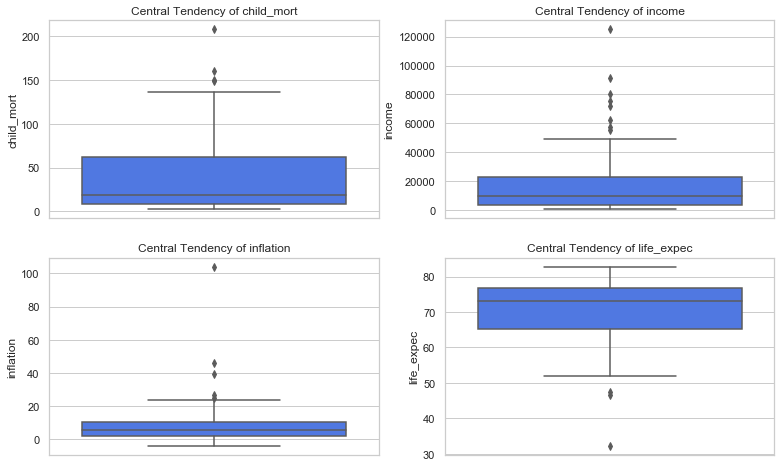

In [14]:
# m_box_plt is local function which takes a df, rows, columns of subplot and name of columns as an argument and 
# plots box plots
# Part-1
m_box_plt(c_df,2,2,*list(c_num_li[0:4]))

In [15]:
# Inspect the columns more in detail for outliers
c_df[c_num_li[0:4]].describe(q_li)

child_mort         income   inflation  life_expec
count  167.000000     167.000000  167.000000  167.000000
mean    38.270060   17144.688623    7.781832   70.555689
std     40.328931   19278.067698   10.570704    8.893172
min      2.600000     609.000000   -4.210000   32.100000
1%       2.800000     742.240000   -2.348800   47.160000
5%       3.460000    1213.000000    0.183400   55.780000
25%      8.250000    3355.000000    1.810000   65.300000
50%     19.300000    9960.000000    5.390000   73.100000
75%     62.100000   22800.000000   10.750000   76.800000
95%    116.000000   48290.000000   20.870000   81.400000
99%    153.400000   84374.000000   41.478000   82.370000
max    208.000000  125000.000000  104.000000   82.800000

* __Observations:__
  1. __Child Mortality__ The mortality ranges from as high as 208 to 2. Its very sad to see such high child mortality anything above 5% is a concern. __The data beyond 99% lies in 4 sigma and statistically its a outlier__. However Child mortaility is a concern and I choose not to treat the outlier as the objective is to study the countries which are in need of the aid. Coutnries Like Haiti, Sierra Leone are in extreme high Child Mortaltiy . These countries have Child Mortality beyond 15%.
  2. __Exports__ Exports now represents as absolute value of GDPP and it ranges from 1 to 183750. __Singapore and Luxembourg have very  per capita of exports__. Interestingly the per capita of exports is greater than GDP percapita. I would like to see if my model would classify them into separate category. It is interesting to study how the under developed countries can learn from it. At the same time there are lot of countries in the lower per capita gdpp. Since the data is right skewed, the lower level countries are not part of outliers.
  3. __Health__ Health spending now represents as absolute value of GDPP and it ranges from 12 to 8663.__The developed countries like USA and Switzerland have higher health spending and they stand as outliers.__
  4. __Imports__ Imports now represents as absolute value of GDPP and it ranges from 0 to 149100. __Luxembourg and Singapore has highest countries imports and stand as outliers as per statistically.__

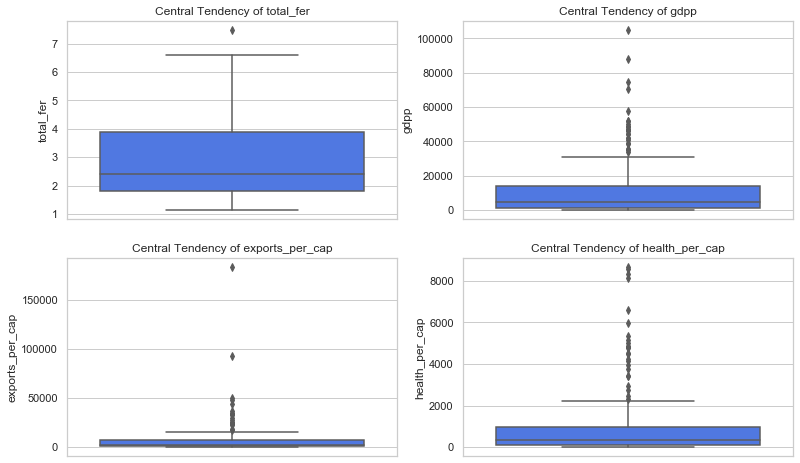

In [16]:
# m_box_plt is local function which takes a df, rows, columns of subplot and name of columns as an argument and 
# plots box plots
# Part-2
m_box_plt(c_df,2,2,*list(c_num_li[4:8]))

In [17]:
# Inspect the columns more in detail for outliers
c_df[c_num_li[4:8]].describe(q_li)

total_fer           gdpp  exports_per_cap  health_per_cap
count  167.000000     167.000000       167.000000      167.000000
mean     2.947964   12964.155689      7420.618847     1056.733204
std      1.513848   18328.704809     17973.885795     1801.408906
min      1.150000     231.000000         1.076920       12.821200
1%       1.243200     331.620000        22.243716       17.009362
5%       1.390000     465.900000        70.468800       26.715920
25%      1.795000    1330.000000       447.140000       78.535500
50%      2.410000    4660.000000      1777.440000      321.886000
75%      3.880000   14050.000000      7278.000000      976.940000
95%      5.861000   48610.000000     31385.100000     4966.701000
99%      6.563600   79088.000000     64794.260000     8410.330400
max      7.490000  105000.000000    183750.000000     8663.600000

* __Observations:__
  1. __Income__ Per capita Income ranges from 609 to 125000. __Countries like Brunei, Kuwait, Luxembourg, Qatar and Singapore have very high Income. They are considered as outliers on higher end. On lower end Burundi, CAR, Congo Dem Republic, Liberia, Mozambique and Niger have very low income and they are outliers.__ 
  2. __Inflation__ Inflation ranges from -4 to 104. __Nigeria and Venezuela have very high inflation and are considered as outliers. Similarly Czech Republic and Ireland have high -ve inflation.__. We do need to study countries having higher inflation as they might be backward countries and if it influences the development.
  3. __Life Expectancy__ Life Expectancy ranges from 32 years to 82 years. It is sad and conerning that many countries having less than 60 years as life expectancy on an average. The countries having less than 47 years are outliers and however this needed to be studied in detail and they should not be dropped. __Countries like Haiti, Lesotho and Central African Republic have life expectancy below 50 and are considered as outliers.__
  4. __Total Fertility__ Imports now represents as absolute value of GDPP and it ranges from 1 to 7. __Nigera is outlier here but it has very high child_mortality.__

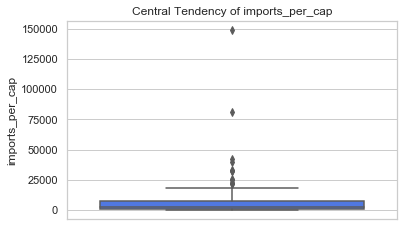

In [18]:
# m_box_plt is local function which takes a df, rows, columns of subplot and name of columns as an argument and 
# plots box plots
# Part-3
m_box_plt(c_df,2,2,*list(c_num_li[8:]))

In [19]:
# Inspect the columns more in detail for outliers
c_df[c_num_li[8:]].describe(q_li)

imports_per_cap
count       167.000000
mean       6588.352108
std       14710.810418
min           0.651092
1%          104.909640
5%          169.281000
25%         640.215000
50%        2045.580000
75%        7719.600000
95%       24241.560000
99%       55371.390000
max      149100.000000

In [20]:
# Countries having extreme high GDPP and very low GDPP
c_df[(c_df.gdpp < 750) | (c_df.gdpp > 48000) ]

country  child_mort  income  inflation  life_expec  \
0                 Afghanistan        90.2    1610      9.440        56.2   
7                   Australia         4.8   41400      1.160        82.0   
25               Burkina Faso       116.0    1430      6.810        57.9   
26                    Burundi        93.6     764     12.300        57.7   
31   Central African Republic       149.0     888      2.010        47.5   
37           Congo, Dem. Rep.       116.0     609     20.800        57.5   
44                    Denmark         4.1   44000      3.220        79.5   
50                    Eritrea        55.2    1420     11.600        61.7   
56                     Gambia        80.3    1660      4.300        65.5   
63                     Guinea       109.0    1190     16.100        58.0   
64              Guinea-Bissau       114.0    1390      2.970        55.6   
66                      Haiti       208.0    1500      5.450        32.1   
73                    Ireland         4.2   45700     -3.220        80.4   
88                    Liberia        89.3     700      5.470        60.8   
91                 Luxembourg         2.8   91700      3.620        81.3   
93                 Madagascar        62.2    1390      8.790        60.8   
94                     Malawi        90.5    1030     12.100        53.1   
97                       Mali       137.0    1870      4.370        59.5   
106                Mozambique       101.0     918      7.640        54.5   
109                     Nepal        47.0    1990     15.100        68.3   
110               Netherlands         4.5   45500      0.848        80.7   
112                     Niger       123.0     814      2.550        58.8   
114                    Norway         3.2   62300      5.950        81.0   
123                     Qatar         9.0  125000      6.980        79.5   
126                    Rwanda        63.6    1350      2.610        64.6   
132              Sierra Leone       160.0    1220     17.200        55.0   
144                    Sweden         3.0   42900      0.991        81.5   
145               Switzerland         4.5   55500      0.317        82.2   
146                Tajikistan        52.4    2110     12.500        69.6   
147                  Tanzania        71.9    2090      9.250        59.3   
150                      Togo        90.3    1210      1.180        58.7   
155                    Uganda        81.0    1540     10.600        56.8   
159             United States         7.3   49400      1.220        78.7   

     total_fer    gdpp  exports_per_cap  health_per_cap  imports_per_cap  
0         5.82     553          55.3000         41.9174          248.297  
7         1.93   51900       10276.2000       4530.8700        10847.100  
25        5.87     575         110.4000         38.7550          170.200  
26        6.26     231          20.6052         26.7960           90.552  
31        5.21     446          52.6280         17.7508          118.190  
37        6.54     334         137.2740         26.4194          165.664  
44        1.87   58000       29290.0000       6612.0000        25288.000  
50        4.61     482          23.0878         12.8212          112.306  
56        5.71     562         133.7560         31.9778          239.974  
63        5.34     648         196.3440         31.9464          279.936  
64        5.05     547          81.5030         46.4950          192.544  
66        3.33     662         101.2860         45.7442          428.314  
73        2.05   48700       50161.0000       4475.5300        42125.500  
88        5.02     327          62.4570         38.5860          302.802  
91        1.63  105000      183750.0000       8158.5000       149100.000  
93        4.60     413         103.2500         15.5701          177.590  
94        5.31     459         104.6520         30.2481          160.191  
97        6.55     708         161.4240         35.2584          248.508  
106       5.

* __Observations:__
  1. __GDPP__ ranges from  231 till 105000. Burundi and Liberia have very low GDPP and are outliers on lower side. They should not be dropped and they should be kept for further study. Luxembourg, Norway, Switzerland and Qatar have very high gdpp figures and stand as outliers on higher side. Again I choose not to drop them and following is my detailed explanation on it.

##### __Outliers Treatment__

__Notes from problem statement__

After the recent funding programmes, they have been able to raise around $ 10 million. Now the CEO of the NGO needs to decide how to use this money strategically and effectively. __The significant issues that come while making this decision are mostly related to choosing the countries that are in the direst need of aid.__
 
And this is where you come in as a data analyst. Your job is to categorise the countries using some socio-economic and health factors that determine the overall development of the country. Then you need to suggest the countries which the CEO needs to focus on the most. __Your job is to categorise the countries using some socio-economic and health factors that determine the overall development of the country. Then you need to suggest the countries which the CEO needs to focus on the most.__  

__Outlier Analysis:__ You must perform the Outlier Analysis on the dataset, before or after performing PCA, as per your choice. However, you do have the flexibility of not removing the outliers if it suits the business needs or a lot of countries are getting removed. Hence, all you need to do is find the outliers in the dataset, and then choose whether to keep them or remove them depending on the results you get.

The Objective of the assignment to identify the socio-economic and health factors that determine the overall development of the country. 

Technically,
  - PCA is not sensitive to presense of outliers in the data.
  - Presence of outliers might or might not influence the results of clusters.
  
Business Objective
  - While the main objective is to suggest CEO with the countries who are in dire need of help as humanitarian support, it was mentioned to study factors that influence overall development of the country.

When we speak statistically, in the given data we have outliers across all the columns and in majority cases at higher whiskers and lower whiskers. All of the outliers have been identified as stated above.

Considering Business objective, my approach is follows
  - The data is about 167 countries and if we follow statistical approach and remove ouliers, then we would loose not only the data of developed countries but also backward countries. With this we would not be able to study developed countries and but also would not be able to identify exact countries which needed to be recommended to CEO of Help.
  - We can remove outliers of certain columns at higher whiskers, but the clasfficiation algorithm should be able to classify them into separate cluster as the outliers.
  - However imputing or dropping the rows of outliers would influence the study and overall business objective.

#### Inspect the categorical variables

In [21]:
# Inspect the categorical variables in c_df
c_df[c_cat_li]

country
0            Afghanistan
1                Albania
2                Algeria
3                 Angola
4    Antigua and Barbuda
..                   ...
162              Vanuatu
163            Venezuela
164              Vietnam
165                Yemen
166               Zambia

[167 rows x 1 columns]

In [22]:
# Inspect the country
display(c_df.country.value_counts().max())

1

  - There are no duplicates in the data set. 167 countries are unique

#### Data Preparation

In [23]:
# Remove spaces in the model name and replace it with _
c_df["country"] = c_df.country.apply(lambda x: re.sub(r"\W+","_",str(x)))
c_df["country"] = c_df.country.apply(lambda x: x.rstrip('_'))

In [24]:
# Inspect the DF 
display(c_df.country.unique())
c_df.head()

array(['Afghanistan', 'Albania', 'Algeria', 'Angola',
       'Antigua_and_Barbuda', 'Argentina', 'Armenia', 'Australia',
       'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh',
       'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan',
       'Bolivia', 'Bosnia_and_Herzegovina', 'Botswana', 'Brazil',
       'Brunei', 'Bulgaria', 'Burkina_Faso', 'Burundi', 'Cambodia',
       'Cameroon', 'Canada', 'Cape_Verde', 'Central_African_Republic',
       'Chad', 'Chile', 'China', 'Colombia', 'Comoros', 'Congo_Dem_Rep',
       'Congo_Rep', 'Costa_Rica', 'Cote_d_Ivoire', 'Croatia', 'Cyprus',
       'Czech_Republic', 'Denmark', 'Dominican_Republic', 'Ecuador',
       'Egypt', 'El_Salvador', 'Equatorial_Guinea', 'Eritrea', 'Estonia',
       'Fiji', 'Finland', 'France', 'Gabon', 'Gambia', 'Georgia',
       'Germany', 'Ghana', 'Greece', 'Grenada', 'Guatemala', 'Guinea',
       'Guinea_Bissau', 'Guyana', 'Haiti', 'Hungary', 'Iceland', 'India',
       'Indonesia', 'Iran', 'Iraq', '

country  child_mort  income  inflation  life_expec  total_fer  \
0          Afghanistan        90.2    1610       9.44        56.2       5.82   
1              Albania        16.6    9930       4.49        76.3       1.65   
2              Algeria        27.3   12900      16.10        76.5       2.89   
3               Angola       119.0    5900      22.40        60.1       6.16   
4  Antigua_and_Barbuda        10.3   19100       1.44        76.8       2.13   

    gdpp  exports_per_cap  health_per_cap  imports_per_cap  
0    553            55.30         41.9174          248.297  
1   4090          1145.20        267.8950         1987.740  
2   4460          1712.64        185.9820         1400.440  
3   3530          2199.19        100.6050         1514.370  
4  12200          5551.00        735.6600         7185.800

## Univariate analysis

### Univariate Analysis of Categorical Variables

In [25]:
# Inspect list of categorical variables
print(c_cat_li) 
display(c_df.country.value_counts().max())

['country']


1

__Observations__
1. Country name has unique values and there is nothing to plot.

### Univariate analysis of numerical variables

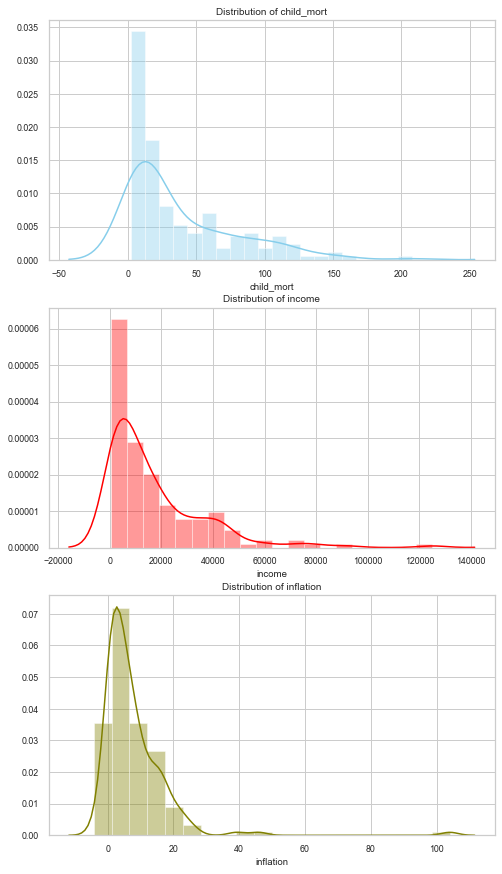

In [26]:
# dist_plt is local function which takes a df, rows, columns of subplot and name of columns as an argument and 
# plots distribution plots
# Part-1
dist_plt(c_df,3,1,*c_num_li[0:3])

__Inferences__
1. Child Mort right skewed and the peak is centered little above 0 and between 0 to 10. But there are lot of spikes beyond and its a concern
2. Exports per capita is right skewed and the peak is centered little above 0. Many  countries have exports per capita from 100 to 1500.
3. Health Spending per capita is right skewed and  it ranges from 12 to 8663. It is peaked from 100 to 500. 

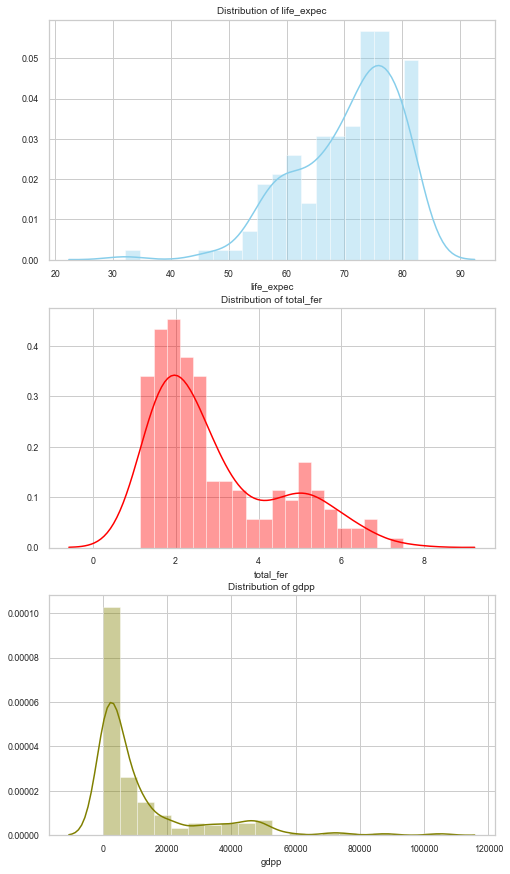

In [27]:
# Part-2
dist_plt(c_df,3,1,*list(c_num_li[3:6]))

__Inferences__
1. Imports per capita is right skewed and peaked at 5000 to 7000.
2. Income is right skewed and its peaked and concentrated at 5000.
3. Inflation is peaked and concentrated at 7 and right skewed.

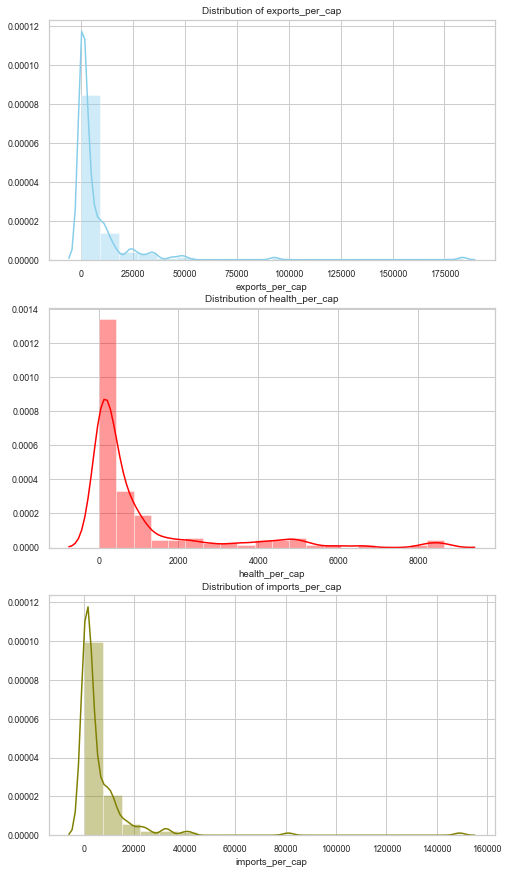

In [28]:
# Part-2
dist_plt(c_df,3,1,*list(c_num_li[6:9]))

__Inferences__
1. Life expectancy is left skewed and as seen very little countries have low life expectancy
2. Total Fertility has right skewed 
3. GDPP is right skewed. It is peaked and concentrated at 5000

### Correlation of the numerical variables

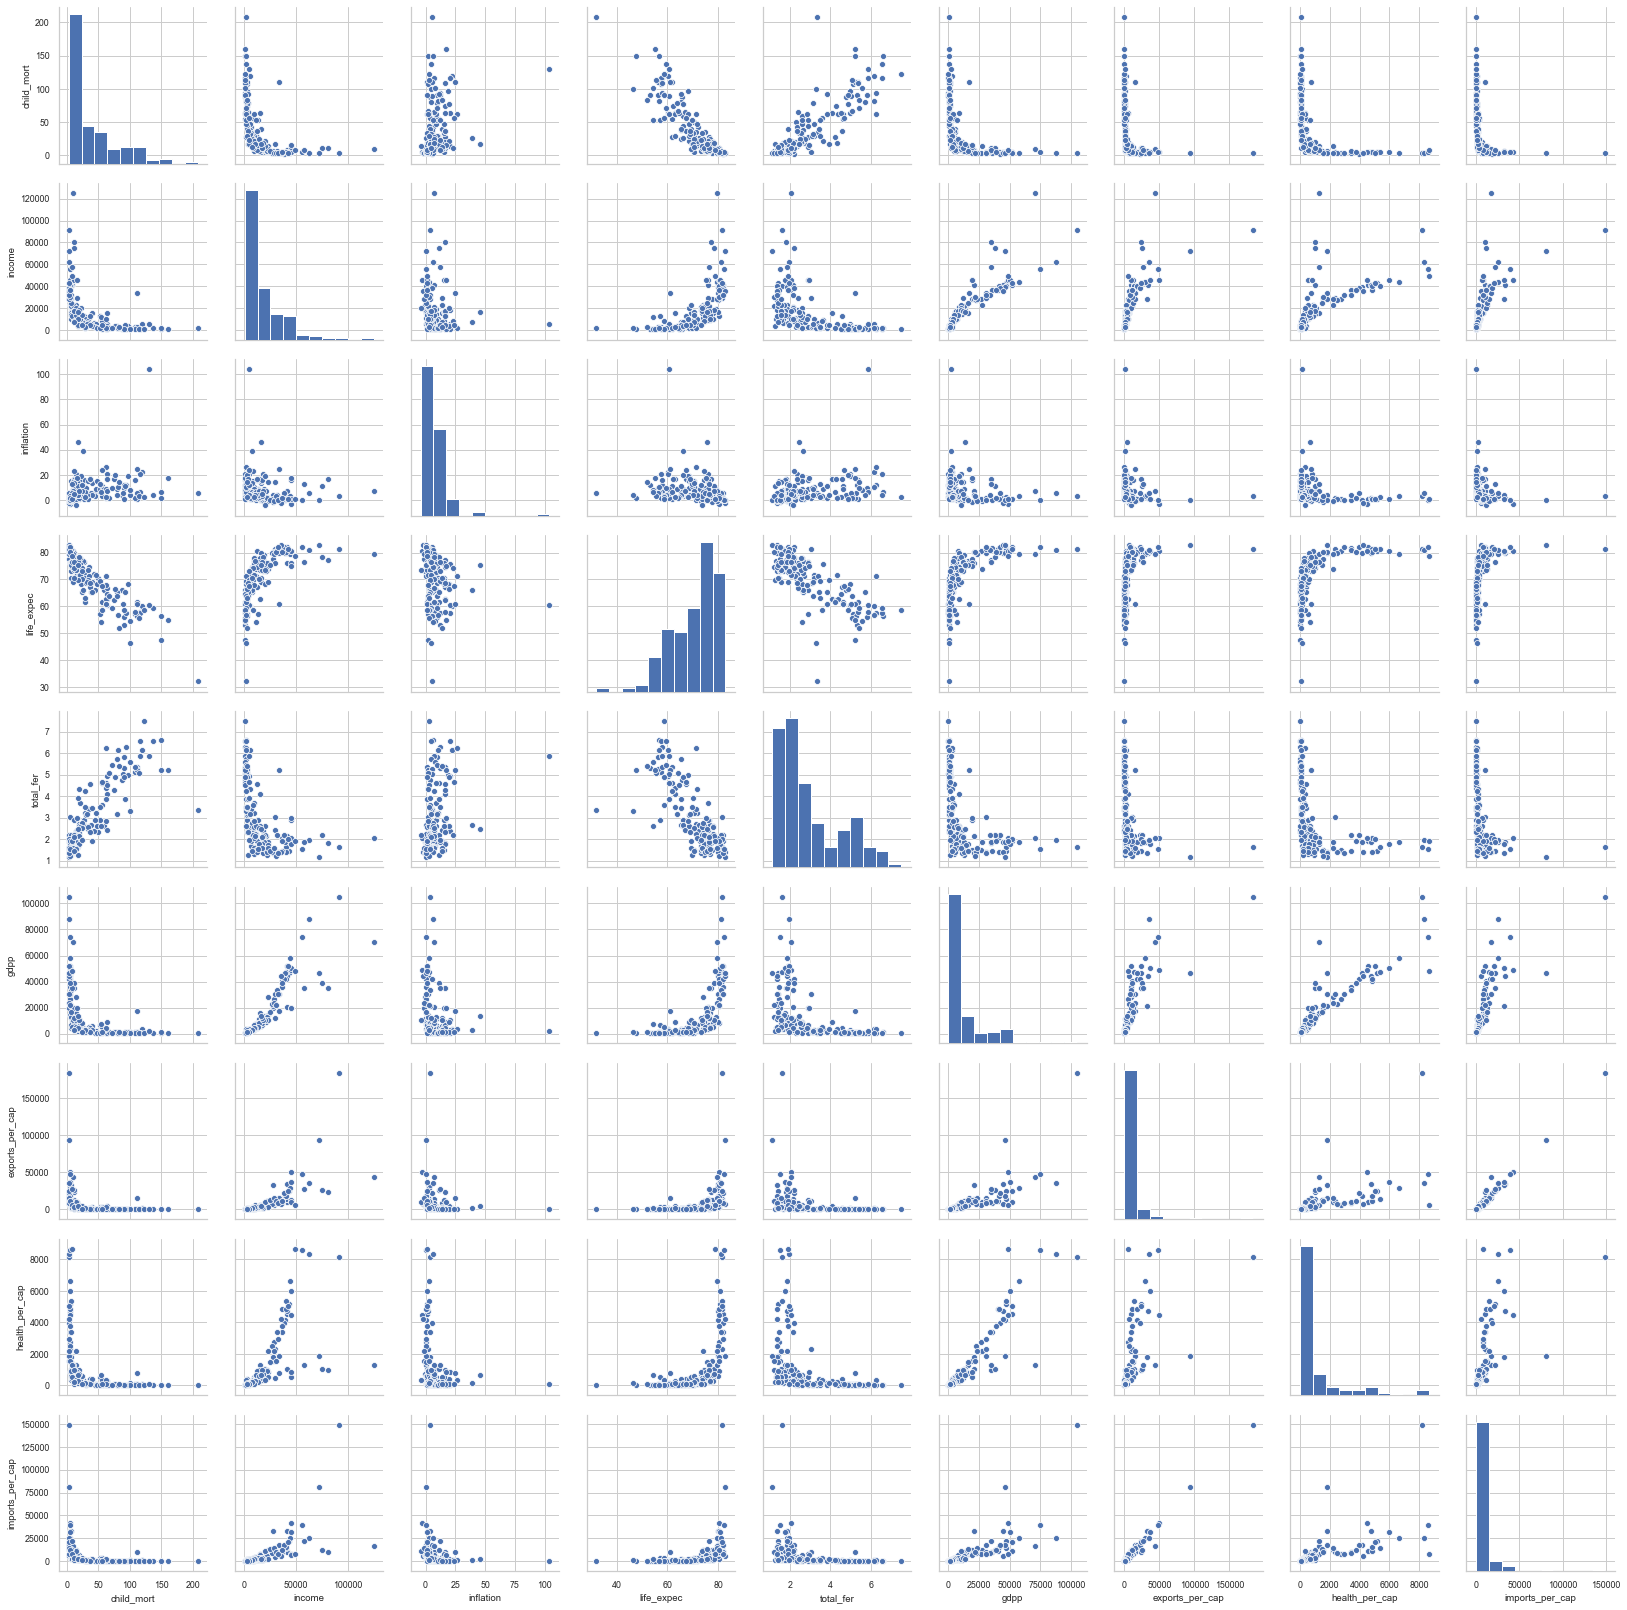

In [29]:
sns.pairplot(c_df)
plt.show()

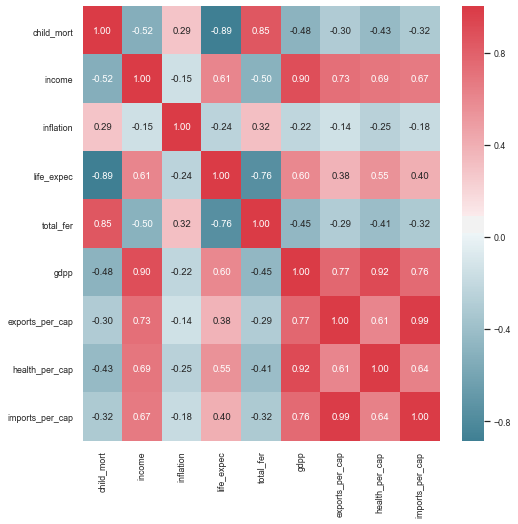

In [30]:
plt.figure(1,figsize=(8,8))
colormap =  colormap = sns.diverging_palette(220, 10, as_cmap=True)
ax = sns.heatmap(c_df.corr(), cmap=colormap, annot=True, fmt=".2f")
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

__Inferences__
1. Features Child Mortality, Total Fertility and Inflation fall in one group and they are +vely +vely correlated among themselves. 
2. Features GDPP, Exports per capita, imports per capita, health, life expectancy and income  fall in to other group and they +vely correlated among themselves. 
3. The 1st set of features and 2nd set of features -vely correlated to each other.

## Preparing the data for modelling(train-test split, rescaling etc)

### Rescaling of the variables

__Rescaling the Features__

As we know, scaling doesn't impact your model. Here we can see that except , ['child_mort', 'exports', 'health', 'imports', 'income', 'inflation', 'life_expec', 'total_fer', 'gdpp'] all the columns have different integer values. So it is extremely important to rescale the variables so that they have a comparable scale. If we don't have comparable scales, then some of the coefficients as obtained by fitting the regression model might be very large or very small as compared to the other coefficients. This might become very annoying at the time of model evaluation. So it is advised to use standardization or normalization so that the units of the coefficients obtained are all on the same scale. 

1. Normalizer - The Normalizer rescales the vector for each sample to have unit norm, independently of the distribution of the samples. 
2. Standardisation (mean-0, sigma-1) - StandardScaler removes the mean and scales the data to unit variance.

__Approach__

My approach is to have 2 different models and see how the results vary and choose the best model. So I decide to use Normalizer for 1 model1 and StndardScaler for other model.

1. M1 - Will have scaling using Normalizer
2. M2 - Will have scaling using StandardScaler or Standardisation

In [31]:
# 2 Models are created and hence 2 copies of df to perform the analysis
m1_df = c_df.copy()
m2_df = c_df.copy()

In [32]:
# List of features that need to be scaled
scl_li = list(c_num_li)
print(scl_li)

['child_mort', 'income', 'inflation', 'life_expec', 'total_fer', 'gdpp', 'exports_per_cap', 'health_per_cap', 'imports_per_cap']


#### Scaling of Model - M1 using Normalizer


In [33]:
# This can be achieved using sklearn MinMaxScaler
# 1. Initiate an object
m1_scaler = Normalizer()

# 2. Fit and transform on data
m1_df[scl_li] = m1_scaler.fit_transform(m1_df[scl_li])
display(m1_df.head())

country  child_mort    income  inflation  life_expec  \
0          Afghanistan    0.052288  0.933307   0.005472    0.032579   
1              Albania    0.001511  0.903948   0.000409    0.006946   
2              Algeria    0.001974  0.932832   0.001164    0.005532   
3               Angola    0.016130  0.799717   0.003036    0.008146   
4  Antigua_and_Barbuda    0.000422  0.781942   0.000059    0.003144   

   total_fer      gdpp  exports_per_cap  health_per_cap  imports_per_cap  
0   0.003374  0.320571         0.032057        0.024299         0.143936  
1   0.000150  0.372321         0.104250        0.024387         0.180948  
2   0.000209  0.322514         0.123845        0.013449         0.101269  
3   0.000835  0.478475         0.298090        0.013637         0.205266  
4   0.000087  0.499461         0.227255        0.030117         0.294182

#### Scaling of Model - M2 using StandardScaler


In [34]:
# This can be achieved using sklearn MinMaxScaler
# 1. Initiate an object
m2_scaler = StandardScaler()

# 2. Fit and transform on data
m2_df[scl_li] = m2_scaler.fit_transform(m2_df[scl_li])
display(m2_df.head())

country  child_mort    income  inflation  life_expec  \
0          Afghanistan    1.291532 -0.808245   0.157336   -1.619092   
1              Albania   -0.538949 -0.375369  -0.312347    0.647866   
2              Algeria   -0.272833 -0.220844   0.789274    0.670423   
3               Angola    2.007808 -0.585043   1.387054   -1.179234   
4  Antigua_and_Barbuda   -0.695634  0.101732  -0.601749    0.704258   

   total_fer      gdpp  exports_per_cap  health_per_cap  imports_per_cap  
0   1.902882 -0.679180        -0.411011       -0.565040        -0.432276  
1  -0.859973 -0.485623        -0.350191       -0.439218        -0.313677  
2  -0.038404 -0.465376        -0.318526       -0.484826        -0.353720  
3   2.128151 -0.516268        -0.291375       -0.532363        -0.345953  
4  -0.541946 -0.041817        -0.104331       -0.178771         0.040735

## __Model 1 - Feature Selection using PCA & Clustering__

__PCA & Clustering Steps__
* 1) Dimensonality Reduction using PCA
* 2) Clustering the data using hierarchical Modelling (Single, Complete and Ward)
* 3) Clustering the data using K-Means

### __Model 1 - Dimensionality Reduction using PCA__

In [35]:
# Target variable is removed from predictor variables
my1_train = m1_df.pop("country")
MX1_train = m1_df.copy()

display(my1_train.head())
display(MX1_train.head())

0            Afghanistan
1                Albania
2                Algeria
3                 Angola
4    Antigua_and_Barbuda
Name: country, dtype: object

child_mort    income  inflation  life_expec  total_fer      gdpp  \
0    0.052288  0.933307   0.005472    0.032579   0.003374  0.320571   
1    0.001511  0.903948   0.000409    0.006946   0.000150  0.372321   
2    0.001974  0.932832   0.001164    0.005532   0.000209  0.322514   
3    0.016130  0.799717   0.003036    0.008146   0.000835  0.478475   
4    0.000422  0.781942   0.000059    0.003144   0.000087  0.499461   

   exports_per_cap  health_per_cap  imports_per_cap  
0         0.032057        0.024299         0.143936  
1         0.104250        0.024387         0.180948  
2         0.123845        0.013449         0.101269  
3         0.298090        0.013637         0.205266  
4         0.227255        0.030117         0.294182

#### Create an insance and explore the components

In [36]:
# Create an instance of PCA
pca_m1 = PCA(random_state=rndm_stat)

# finding the covariance matrix,  doing an eigendecomposition of it to obtain the eigenvectors which are Principal Components
pca_m1.fit(MX1_train)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=1,
    svd_solver='auto', tol=0.0, whiten=False)

In [37]:
# Inspect the principal components created by PCA
print("Print Principal Components",pca_m1.components_.shape)
pca_m1.components_

Print Principal Components (9, 9)


array([[-5.25363826e-02, -6.17354891e-01, -5.73949068e-03,
        -3.44073783e-02, -2.76607412e-03,  4.88278807e-01,
         4.58705506e-01,  6.66183628e-02,  4.02024210e-01],
       [-7.26923286e-03,  9.93228097e-02, -8.30529786e-04,
        -3.76300683e-04, -3.80864089e-04, -7.15311435e-01,
         5.42461898e-01, -9.84466072e-02,  4.17676989e-01],
       [ 1.93867205e-01, -4.06378770e-02,  1.09463180e-02,
         1.17018312e-01,  1.01098433e-02, -5.44342453e-02,
        -6.24096132e-01,  5.19937333e-02,  7.42755907e-01],
       [ 5.03740832e-01, -6.53911334e-01,  4.63257728e-02,
         2.24182049e-01,  2.49630303e-02, -3.78575255e-01,
        -1.15504274e-01,  1.75149337e-02, -3.29622642e-01],
       [ 7.49968078e-01,  4.16277429e-01,  4.96382680e-02,
         2.72402145e-01,  3.51548238e-02,  3.09491456e-01,
         2.94261365e-01, -3.09598749e-02,  5.50000925e-02],
       [ 7.71104592e-03,  7.80698455e-02,  9.22489711e-03,
        -2.26143574e-03,  8.74144102e-06, -8.470251

In [38]:
# Explore the variance explained by PC in each direction
print("Variance of each PC in each of its direction\n",pca_m1.explained_variance_ratio_)

# Create a cumulative sum of variance
m1_varcum = np.cumsum(pca_m1.explained_variance_ratio_)

Variance of each PC in each of its direction
 [6.91902925e-01 2.14356569e-01 6.02617437e-02 1.88651223e-02
 1.22596527e-02 1.75452133e-03 5.04280469e-04 9.38949466e-05
 1.29081981e-06]


#### Explore the variance and select the no of PC's

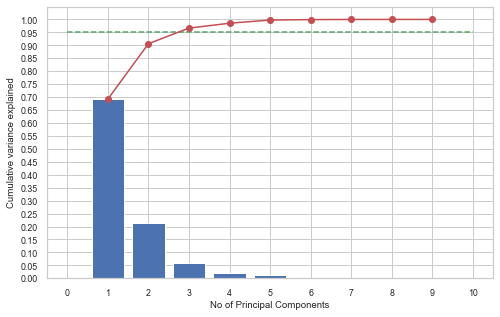

In [39]:
# Explore the variance using Scree plots to select the no of PC's
# Plot Scree plots
plt.figure(figsize=[8,5])
plt.bar(range(1,len(pca_m1.explained_variance_ratio_)+1),pca_m1.explained_variance_ratio_)
plt.plot(range(1,len(m1_varcum)+1),m1_varcum,c="r",marker='o')
plt.xlabel("No of Principal Components")
plt.ylabel("Cumulative variance explained")
plt.yticks(np.arange(0,10.5,0.5)/10)
plt.xticks(np.arange(0,11,1))
plt.hlines(y=0.95,xmin=0,xmax=10,colors="g",linestyles="--")
plt.show()

__Inferences__


 1) From Spree plot we observe that 3 PC's contribute to 95% of the variance data. I take the 95% as cutoff and hence consider to select 3 PC's.

#### Fit and Transform using the PC's using the no of components selected

In [40]:
# Fit the model and apply the dimensionality reduction to 3 PC's on the data
pca_m1_3 = PCA(n_components=3,random_state=rndm_stat)

In [41]:
# Create a DF with 3 Principal Components which explains variance of 90%
pca_m13 = pd.DataFrame(pca_m1_3.fit_transform(MX1_train),columns=["PC1","PC2","PC3"])

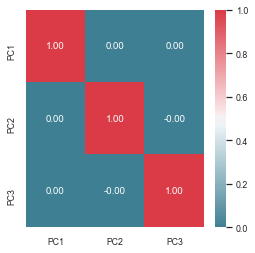

In [42]:
# Check the correlation with 3 PC's
plt.figure(figsize=(4,4))
colormap =  colormap = sns.diverging_palette(220, 10, as_cmap=True)
ax = sns.heatmap(round(pca_m13.corr(),2), cmap=colormap, annot=True, fmt=".2f")
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

* The new features do not have correlation and it looks good

In [43]:
# add country label to df with 3 PC's
pca_m13 = pd.concat([pca_m13,my1_train],axis=1)
display(pca_m13)

PC1       PC2       PC3              country
0   -0.234324 -0.002951  0.058994          Afghanistan
1   -0.139342  0.012111  0.026878              Albania
2   -0.205247  0.029031 -0.043631              Algeria
3    0.073987  0.042083 -0.075126               Angola
4    0.100576  0.022515  0.031892  Antigua_and_Barbuda
..        ...       ...       ...                  ...
162  0.307236 -0.035587  0.020374              Vanuatu
163  0.076793 -0.170555 -0.079322            Venezuela
164 -0.145862  0.151089  0.003121              Vietnam
165 -0.260037  0.038159 -0.017851                Yemen
166 -0.126254 -0.008313 -0.039175               Zambia

[167 rows x 4 columns]

#### Visualize the PC's in eigen space

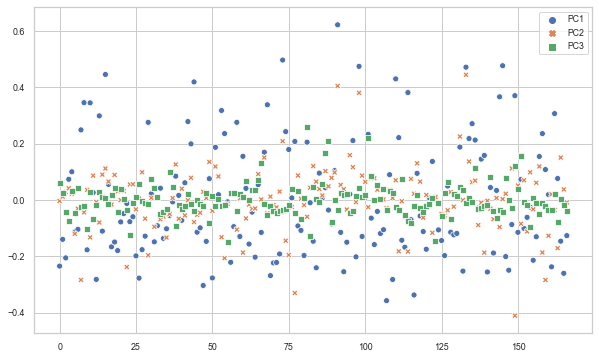

In [44]:
plt.figure(1,figsize=(10,6))
sns.scatterplot(data=pca_m13[["PC1","PC2","PC3"]])
plt.show()

#### Map the PC's in eigen space to original column names

In [45]:
# Map the PC's in eigen space to original column names

# get number of component
n_pcs= pca_m1_3.n_components_ 

# get the index of the most important feature on EACH component
mst_imp = [np.abs(pca_m1_3.components_[i]).argmax() for i in range(n_pcs)]

# 
fr_cols = MX1_train.columns

# get the most important feature names
pc_cols_1 = [fr_cols[mst_imp[i]] for i in range(n_pcs)]

In [46]:
# Print the top PC'contributing to 95% variance 
print(color.BOLD+"PC's contributing to 95% variance \n"+color.END,pc_cols_1)

PC's contributing to 95% variance 
 ['income', 'gdpp', 'imports_per_cap']


### __Model 1 - Clustering the data__

#### Hopkins Check to proceed with Clustering

In [47]:
#Use the Hopkins Statistic function by passing the above dataframe as a paramter
hopkins(pca_m13[["PC1","PC2","PC3"]])

0.8200366616198494

* Hopkins score indicates cluster tendency. Score of .83 is good score and its nice to proceed with clustering mechanism

#### Outliers detection in the new df with PC's as columns

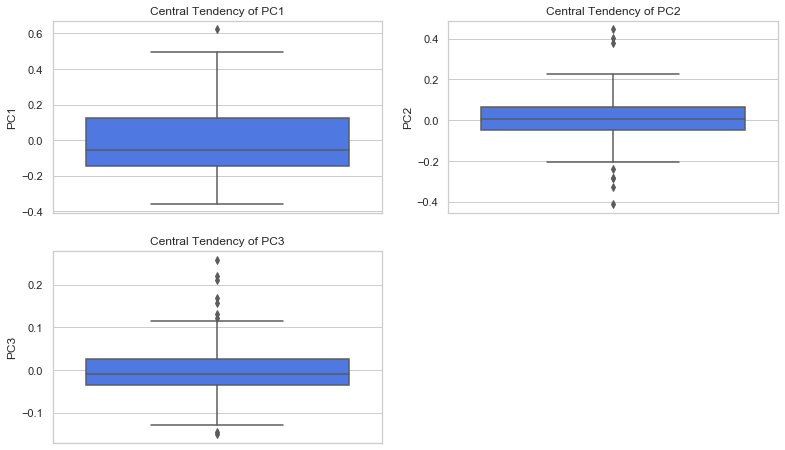

In [48]:
# m_box_plt is local function which takes a df, rows, columns of subplot and name of columns as an argument and 
# plots box plots
# Part-1
m_box_plt(pca_m13,3,2,*list(["PC1","PC2","PC3"]))

In [49]:
# Inspect the columns more in detail for outliers
pca_m13.describe(q_li)

PC1           PC2           PC3
count  1.670000e+02  1.670000e+02  1.670000e+02
mean   2.576116e-17  5.321550e-17 -2.991619e-18
std    2.020415e-01  1.124570e-01  5.962642e-02
min   -3.570941e-01 -4.102560e-01 -1.494443e-01
1%    -3.146770e-01 -2.994562e-01 -1.333521e-01
5%    -2.586208e-01 -1.863592e-01 -8.074857e-02
25%   -1.459456e-01 -4.881344e-02 -3.517956e-02
50%   -5.422420e-02  4.795196e-03 -9.738335e-03
75%    1.229105e-01  6.263506e-02  2.650046e-02
95%    3.786095e-01  1.366193e-01  9.443547e-02
99%    4.840482e-01  3.891114e-01  2.134540e-01
max    6.224925e-01  4.449253e-01  2.582466e-01

* The outliers in the original data set are transformed and the outliers still remain as outliers

In [50]:
# Create a new df with only principal components which can be used for clustering
pca_m13_df = pca_m13[["PC1","PC2","PC3"]]

### M1 Clustering using Hirearchial Modeling

#### Hierarchial using Single Linkage Method

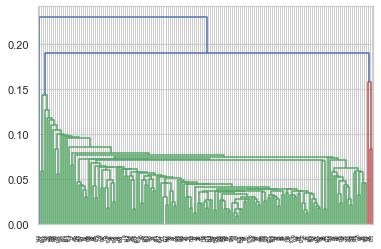

In [51]:
# Single linkage
sl = linkage(pca_m13_df,method="single",metric="euclidean")
dendrogram(sl)
plt.show()

* As we can see, at 0.15, we have 4 different clusters. Hence I choose to create the clusters with 4

##### Cut the Clusters & Derive Labels

In [52]:
# 4 Clusters
sn_cl_lbls = cut_tree(sl,n_clusters=4).reshape(-1,)

In [53]:
pca_m13["sn_cl_lbls"] = sn_cl_lbls
print("Number of Countries across each cluster\n",pca_m13["sn_cl_lbls"].value_counts())

Number of Countries across each cluster
 0    163
2      2
3      1
1      1
Name: sn_cl_lbls, dtype: int64


##### Visualize the first 2 Principal Components and Clustering

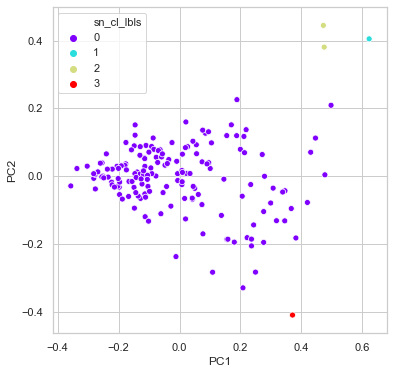

In [54]:
plt.figure(1,figsize=(6,6))
sns.scatterplot(x = pca_m13.PC1, y = pca_m13.PC2, hue=pca_m13.sn_cl_lbls,markers=["o", "s", "D"], palette="rainbow")
plt.show()

* We could clearly see that with single linkage method, though 4 clusters have been formed, one single cluster has taken over most of the data points. This is not a good model to choose as majority of the data is in one single cluster

#### Hierarchial using Ward Linkage Method

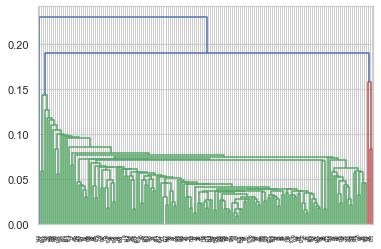

In [55]:
# Ward linkage method
wrd = linkage(pca_m13_df,method="ward",metric="euclidean")
dendrogram(sl)
plt.show()

* As we can see, at 0.15, we have 4 different clusters. Hence I choose to create the clusters with 4

##### Cut the Clusters & Derive Labels

In [56]:
# 4 Clusters
wrd_cl_lbls = cut_tree(wrd,n_clusters=4).reshape(-1,)

In [57]:
# Assign the lables to different df for analysis purposes 
pca_m13["wrd_cl_lbls"] = wrd_cl_lbls
m1_df["wrd_cl_lbls"] = wrd_cl_lbls
c_df["M1_wrd_cl_lbls"] = wrd_cl_lbls
print("Number of Countries across each cluster\n",pca_m13["wrd_cl_lbls"].value_counts())

Number of Countries across each cluster
 0    84
1    39
3    30
2    14
Name: wrd_cl_lbls, dtype: int64


##### Visualize the first 2 Principal Components and Clustering

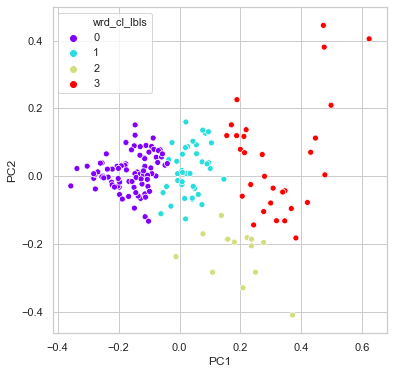

In [58]:
plt.figure(1,figsize=(6,6))
sns.scatterplot(x = pca_m13.PC1, y = pca_m13.PC2, hue=pca_m13.wrd_cl_lbls,markers=["o", "s", "D"], palette="rainbow")
plt.show()

* We could clearly see that with ward linkage method, the 4 clusters are segregated and grouped as different clusters  in 2 Dimensional wrt PC1 and PC2.

##### Visualize the first 3 Principal Components and Clustering

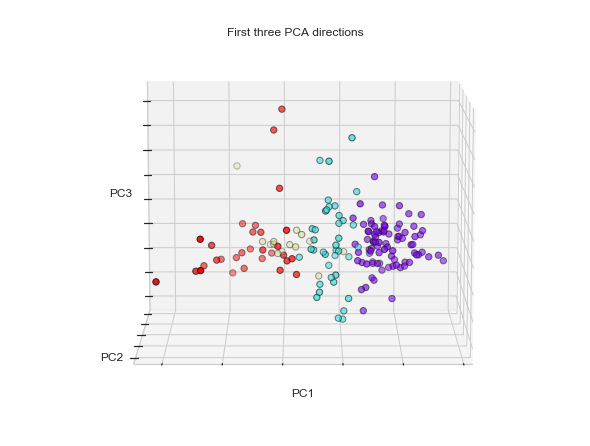

In [59]:
fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=10, azim=90)
ax.scatter(pca_m13['PC1'], pca_m13['PC2'], pca_m13['PC3'], c=np.array(pca_m13.wrd_cl_lbls),cmap=plt.cm.rainbow, edgecolor='k', s=40)
ax.set_title("First three PCA directions")
ax.set_xlabel("PC1")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("PC2")
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("PC3")
ax.w_zaxis.set_ticklabels([])

plt.show()

* We could clearly see that with ward linkage method, the 4 clusters are segregated and grouped as different clusters on in 3 dimensions wrt PC1, PC2 and PC3

#### Hierarchial using Complete Linkage Method

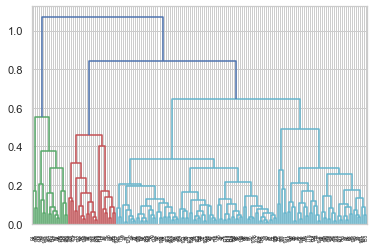

In [60]:
# Complete linkage
cmpl = linkage(pca_m13_df,method="complete",metric="euclidean")
dendrogram(cmpl)
plt.show()

* As we can see, at 0.6, we have 4 different clusters nicely segregated. Hence I choose to create the clusters with 4.

##### Cut the Clusters & Derive Labels

In [61]:
# 4 Clusters
hr_cl_lbls = cut_tree(cmpl,n_clusters=4).reshape(-1,)

In [62]:
# Assign the lables to different df for analysis purposes 
pca_m13["Hr_Lbls"] = hr_cl_lbls
m1_df["Hr_Lbls"] = hr_cl_lbls
c_df["M1_Hr_Lbls"] = hr_cl_lbls
print("Number of Countries across each cluster\n",pca_m13["Hr_Lbls"].value_counts())

Number of Countries across each cluster
 0    80
1    45
2    24
3    18
Name: Hr_Lbls, dtype: int64


##### Visualize the first 2 Principal Components and Clustering

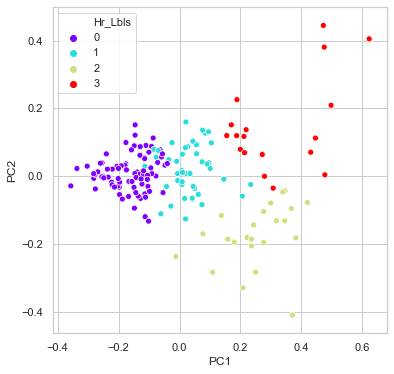

In [63]:
plt.figure(1,figsize=(6,6))
sns.scatterplot(x = pca_m13.PC1, y = pca_m13.PC2, hue=pca_m13.Hr_Lbls, palette="rainbow")
plt.show()

* We could clearly see that with complete linkage method, the 4 clusters are segregated and grouped as different clusters in 2 dimensions wrt PC1 and PC2

##### Visualize the first 3 Principal Components and Clustering

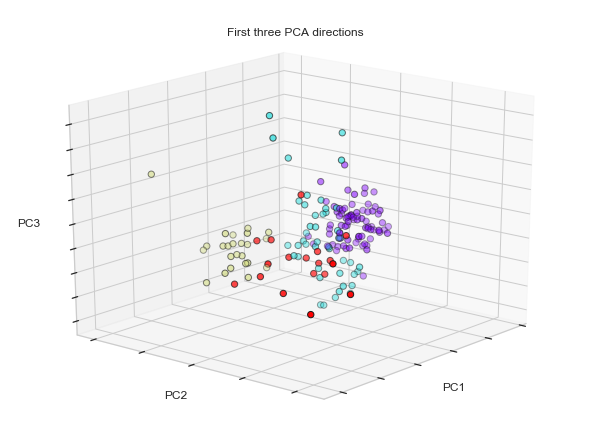

In [64]:
fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=20, azim=40)
ax.scatter(pca_m13['PC1'], pca_m13['PC2'], pca_m13['PC3'], c=np.array(pca_m13.Hr_Lbls),cmap=plt.cm.rainbow, edgecolor='k', s=40)
ax.set_title("First three PCA directions")
ax.set_xlabel("PC1")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("PC2")
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("PC3")
ax.w_zaxis.set_ticklabels([])

plt.show()

* We could clearly see that with complete linkage method, the 4 clusters are segregated and grouped as different clusters on in 3 dimensions wrt PC1, PC2 and PC3

### Clustering using K-Means Modelling

__K-Means Steps__
* 1) k-means with some arbitrary k
* 2) Finding the Optimal Number of Clusters
     - Using SSD or Elbow Curve
     - Silhoute Analysis
* 3) Fit and derive the labels using the selected no fo clusters

In [65]:
# model and fit using KMeans
kmm = KMeans(n_clusters=3, max_iter=50,random_state=rndm_stat)

kmm.fit(pca_m13_df)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=50,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=1, tol=0.0001, verbose=0)

In [66]:
# Inspect the labels
kmm.labels_

array([0, 0, 0, 2, 2, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 2, 2, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 2,
       1, 0, 0, 0, 0, 2, 0, 2, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 2,
       0, 2, 1, 0, 0, 0, 0, 2, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 2, 0, 2,
       0, 0, 2, 2, 0, 0, 0, 2, 2, 0, 2, 0, 0, 1, 0, 0, 0, 0, 0, 0, 2, 0,
       2, 1, 0, 0, 1, 0, 0, 2, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 2,
       0, 2, 2, 2, 2, 0, 2, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 2, 1, 1, 0, 0, 1, 1, 0, 0, 0])

#### Finding the optimal no of clusters using SSD / Elbow-Curve

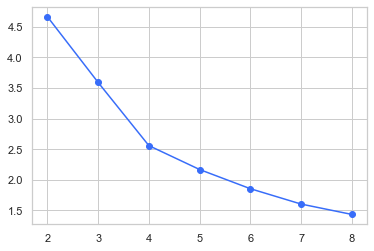

In [67]:
# elbow-curve / SSD (Sum of squred distances of samples to their closest cluster center)

ssd = []

for i in range(2,9):
    k_ssd = KMeans(n_clusters=i,max_iter=50,random_state=rndm_stat)
    k_ssd.fit(pca_m13_df)
    
    #append k-means inertia to array
    ssd.append(k_ssd.inertia_)

# plot the SSD's
plt.plot(range(2,9),ssd,marker="o")
plt.show()

#### Silhouette Analysis

$$\text{silhouette score}=\frac{p-q}{max(p,q)}$$

$p$ is the mean distance to the points in the nearest cluster that the data point is not a part of

$q$ is the mean intra-cluster distance to all the points in its own cluster.

* The value of the silhouette score range lies between -1 to 1. 

* A score closer to 1 indicates that the data point is very similar to other data points in the cluster, 

* A score closer to -1 indicates that the data point is not similar to the data points in its cluster.

In [68]:
# calculate Silhouette score

for i in range(2,9):
    
    # initialize k-means
    k_si = KMeans(n_clusters=i,max_iter=50,random_state=rndm_stat)
    k_si.fit(pca_m13_df)
    
    cls_labels = k_si.labels_
    
    # silhouette score
    si_scr = silhouette_score(pca_m13_df,cls_labels)
    print("For n_clusters={0} , Silhoutte Score is {1}".format(i,si_scr))

For n_clusters=2 , Silhoutte Score is 0.4926115644040459
For n_clusters=3 , Silhoutte Score is 0.467501059314532
For n_clusters=4 , Silhoutte Score is 0.3953658435884942
For n_clusters=5 , Silhoutte Score is 0.3028598821014214
For n_clusters=6 , Silhoutte Score is 0.29854275084811965
For n_clusters=7 , Silhoutte Score is 0.31061074268995537
For n_clusters=8 , Silhoutte Score is 0.3133888546181519


K is decided based on 3 following metrics
* SSD / Elbow curve - 4 is optimal as the elbow starts at 4 and hence convergence
* Silhouette Analysis - 2 is optimal as it has higher score
* Business Decision - I choose to go with 4 clusters based on elbow.

In [69]:
# We start with no of clusters as 4

# model and fit using KMeans
kmm = KMeans(n_clusters=4, max_iter=50,random_state=rndm_stat)
kmm.fit(pca_m13_df)

# Inspect the labels
m13_km_cen = kmm.cluster_centers_
pca_m13["K_M_Lbls"] = kmm.labels_
m1_df["K_M_Lbls"] = kmm.labels_
c_df["M1_K_M_Lbls"] = kmm.labels_

#### Visualize the first 2 Principal Components and Clustering

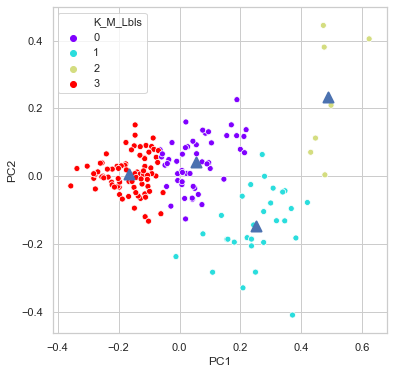

In [70]:
plt.figure(1,figsize=(6,6))
sns.scatterplot(x = pca_m13.PC1, y = pca_m13.PC2, hue=pca_m13.K_M_Lbls,markers=["o", "s", "D"], palette="rainbow")
plt.scatter(m13_km_cen[:, 0], m13_km_cen[:, 1], marker="^", s=100, linewidths=2,color='b', zorder=10)
plt.show()

* We could clearly see that with K-Means method, the 4 clusters are segregated and grouped as different clusters in 2 dimensions wrt PC1 and  PC2

#### Visualize the first 3 Principal Components and Clustering

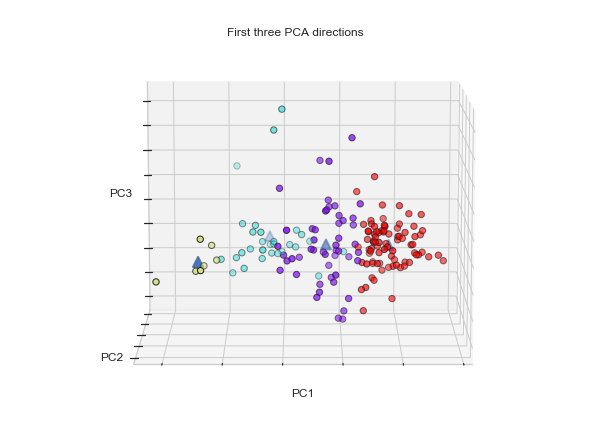

In [71]:
fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=10, azim=90)
ax.scatter(pca_m13['PC1'], pca_m13['PC2'], pca_m13['PC3'], c=np.array(pca_m13.K_M_Lbls),cmap=plt.cm.rainbow, edgecolor='k', s=40)
ax.scatter(m13_km_cen[:, 0], m13_km_cen[:, 1], m13_km_cen[:, 2],marker="^", s=100, linewidths=2,color='b', zorder=10)
ax.set_title("First three PCA directions")
ax.set_xlabel("PC1")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("PC2")
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("PC3")
ax.w_zaxis.set_ticklabels([])

plt.show()

* We could clearly see that with K-Means method, the 4 clusters are segregated and grouped as different clusters in 3 dimensions wrt PC1, PC2 and PC3

## __Model 2 - Feature Selection using PCA & Clustering__

__PCA & Clustering Steps__
* 1) Dimensonality Reduction using PCA
* 2) Clustering the data using hierarchical Modelling (Single, Complete and Ward)
* 3) Clustering the data using K-Means

### __Model 2 - Dimensionality Reduction using PCA__

#### Create an insance and explore the components

In [72]:
# Target variable is removed from predictor variables
my2_train = m2_df.pop("country")
MX2_train = m2_df.copy()

display(my2_train.head())
display(MX2_train.head())

0            Afghanistan
1                Albania
2                Algeria
3                 Angola
4    Antigua_and_Barbuda
Name: country, dtype: object

child_mort    income  inflation  life_expec  total_fer      gdpp  \
0    1.291532 -0.808245   0.157336   -1.619092   1.902882 -0.679180   
1   -0.538949 -0.375369  -0.312347    0.647866  -0.859973 -0.485623   
2   -0.272833 -0.220844   0.789274    0.670423  -0.038404 -0.465376   
3    2.007808 -0.585043   1.387054   -1.179234   2.128151 -0.516268   
4   -0.695634  0.101732  -0.601749    0.704258  -0.541946 -0.041817   

   exports_per_cap  health_per_cap  imports_per_cap  
0        -0.411011       -0.565040        -0.432276  
1        -0.350191       -0.439218        -0.313677  
2        -0.318526       -0.484826        -0.353720  
3        -0.291375       -0.532363        -0.345953  
4        -0.104331       -0.178771         0.040735

In [73]:
# Create an instance of PCA
pca_m2 = PCA(random_state=rndm_stat)

# finding the covariance matrix,  doing an eigendecomposition of it to obtain the eigenvectors which are Principal Components
pca_m2.fit(MX2_train)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=1,
    svd_solver='auto', tol=0.0, whiten=False)

In [74]:
# Inspect the principal components created by PCA
print("Print Principal Components",pca_m2.components_.shape)
pca_m2.components_

Print Principal Components (9, 9)


array([[-0.31639186,  0.38004113, -0.14308531,  0.34385651, -0.30284224,
         0.39998795,  0.34288671,  0.358535  ,  0.34486492],
       [ 0.47626735,  0.12838448,  0.22126089, -0.36981973,  0.4597152 ,
         0.2006241 ,  0.39731091,  0.1550529 ,  0.37078075],
       [-0.15001225,  0.14576421,  0.94841868,  0.19675173, -0.07783431,
         0.01033941, -0.03057367, -0.07570322, -0.07217386],
       [-0.14805195, -0.15480592, -0.00762798, -0.01839465, -0.21392805,
        -0.36477239,  0.44942527, -0.59971228,  0.46179779],
       [ 0.1019948 ,  0.79407469, -0.13642345, -0.15404105, -0.02033568,
         0.08750149, -0.03853829, -0.49319984, -0.2527867 ],
       [ 0.19658519, -0.03814681,  0.10840284, -0.58600986, -0.75390075,
         0.04538167, -0.03891112,  0.18069888, -0.01217988],
       [ 0.76126725, -0.02311312, -0.02207663,  0.58120846, -0.27314534,
        -0.04402264, -0.01366973, -0.06461567,  0.02718244],
       [ 0.00644411,  0.3938113 , -0.00607016,  0.002966  ,  0

#### Explore the variance and select the no of PC's

In [75]:
# Explore the variance explained by PC in each direction
print("Variance of each PC in each of its direction\n",pca_m2.explained_variance_ratio_)

# Create a cumulative sum of variance
m2_varcum = np.cumsum(pca_m2.explained_variance_ratio_)

Variance of each PC in each of its direction
 [5.89372984e-01 1.84451685e-01 9.91147170e-02 6.07227801e-02
 3.02917253e-02 2.45982702e-02 9.39743701e-03 1.55641971e-03
 4.93981394e-04]


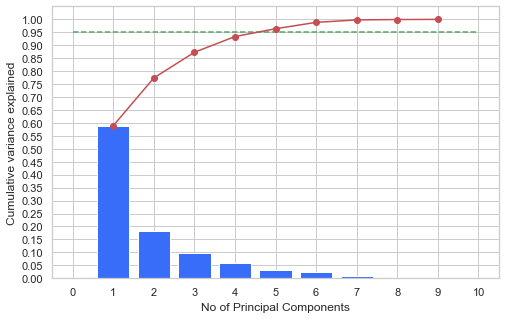

In [76]:
# Explore the variance using Scree plots to select the no of PC's
# Plot Scree plots
plt.figure(figsize=[8,5])
plt.bar(range(1,len(pca_m2.explained_variance_ratio_)+1),pca_m2.explained_variance_ratio_)
plt.plot(range(1,len(m2_varcum)+1),m2_varcum,c="r",marker='o')
plt.xlabel("No of Principal Components")
plt.ylabel("Cumulative variance explained")
plt.yticks(np.arange(0,10.5,0.5)/10)
plt.xticks(np.arange(0,11,1))
plt.hlines(y=0.95,xmin=0,xmax=10,colors="g",linestyles="--")
plt.show()

__Inferences__


 1) From Spree plot we observe that 5 PC's contribute to 95% of the variance data. I take the 95% as cutoff and hence consider to select 5 PC's.

#### Fit and Transform using the PC's using the no of components selected

In [77]:
# Fit the model and apply the dimensionality reduction to 3 PC's on the data
pca_m2_3 = PCA(n_components=5,random_state=rndm_stat)

In [78]:
# Create a DF with 3 Principal Components which explains variance of 90%

# create a list of PC's with respective names
pc_li = ["PC1","PC2","PC3","PC4","PC5"]

# create a df with PC's
pca_m23 = pd.DataFrame(pca_m2_3.fit_transform(MX2_train),columns=pc_li)

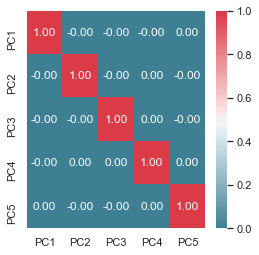

In [79]:
# Check the correlation across  PC's
plt.figure(figsize=(4,4))
colormap =  colormap = sns.diverging_palette(220, 10, as_cmap=True)
ax = sns.heatmap(round(pca_m23.corr(),2), cmap=colormap, annot=True, fmt=".2f")
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

* The new features do not have correlation and it looks good

In [80]:
# add country label to df with 4 PC's
pca_m23 = pd.concat([pca_m23,my1_train],axis=1)
display(pca_m23)

PC1       PC2       PC3       PC4       PC5              country
0   -2.635575  1.472267 -0.549489 -0.242326  0.023530          Afghanistan
1   -0.024206 -1.429892 -0.014123  0.450645 -0.125821              Albania
2   -0.459557 -0.675495  0.959355  0.218456 -0.113275              Algeria
3   -2.722630  2.172332  0.600215 -0.433978  0.005433               Angola
4    0.648597 -1.023437 -0.257430  0.289201  0.072694  Antigua_and_Barbuda
..        ...       ...       ...       ...       ...                  ...
162 -1.175210 -0.275652 -0.667131  0.279628 -0.119733              Vanuatu
163 -0.314228 -0.016266  3.680273  0.011835 -0.460468            Venezuela
164 -0.594449 -1.076335  0.528875  0.508854 -0.328297              Vietnam
165 -1.802372  0.588729  1.180851 -0.020241 -0.315724                Yemen
166 -2.644505  1.571953 -0.174685 -0.178965  0.081814               Zambia

[167 rows x 6 columns]

#### Visualize the PC's in eigen space

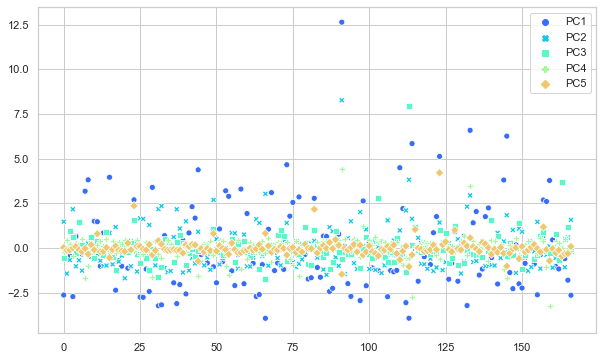

In [81]:
plt.figure(1,figsize=(10,6))
sns.scatterplot(data=pca_m23[pc_li])
plt.show()

#### Map the PC's in eigen space to original column names

In [82]:
# Map the PC's in eigen space to original columns

# get number of component
n_pcs= pca_m2_3.n_components_ 

# get the index of the most important feature on EACH component
mst_imp = [np.abs(pca_m2_3.components_[i]).argmax() for i in range(n_pcs)]

# Original columns
fr_cols = MX2_train.columns

# get the most important feature names
pc_cols_2 = [fr_cols[mst_imp[i]] for i in range(n_pcs)]

In [83]:
# Print the top PC's contributing the maximum variance
print(color.BOLD+"Important Column Names \n"+color.END,pc_cols_2)

Important Column Names 
 ['gdpp', 'child_mort', 'inflation', 'health_per_cap', 'income']


### __Model 2 - Clustering the data__

#### Hopkins Check to proceed with Clustering

In [84]:
#Use the Hopkins Statistic function by passing the above dataframe as a paramter
hopkins(pca_m23[pc_li])

0.8772989503389552

* Hopkins score indicates cluster tendency. Score of .93 is good score and its nice to proceed with clustering mechanism

### Outliers detection in the new df with PC's as columns

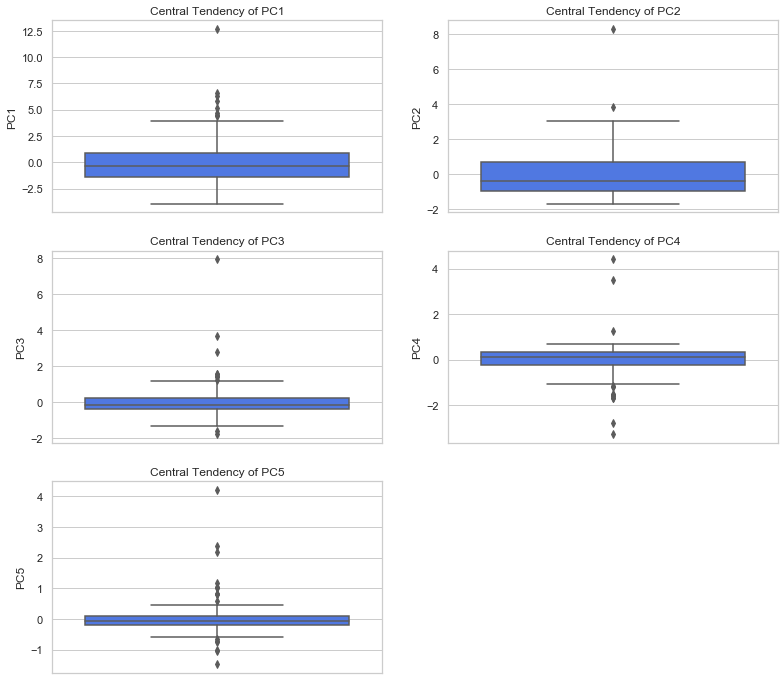

In [85]:
# m_box_plt is local function which takes a df, rows, columns of subplot and name of columns as an argument and 
# plots box plots
# Part-1
m_box_plt(pca_m23,3,2,*list(pc_li))

In [86]:
# Inspect the columns more in detail for outliers
pca_m23.describe(q_li)

PC1           PC2           PC3           PC4           PC5
count  1.670000e+02  1.670000e+02  1.670000e+02  1.670000e+02  1.670000e+02
mean   3.988825e-17 -1.063687e-17  2.725697e-17  4.304607e-17  2.833728e-17
std    2.310046e+00  1.292310e+00  9.473152e-01  7.414831e-01  5.237059e-01
min   -3.937287e+00 -1.694220e+00 -1.756335e+00 -3.263264e+00 -1.469763e+00
1%    -3.473197e+00 -1.474605e+00 -1.419595e+00 -2.053782e+00 -1.026031e+00
5%    -2.759152e+00 -1.347569e+00 -1.123411e+00 -1.176667e+00 -4.559384e-01
25%   -1.447294e+00 -9.750541e-01 -4.010482e-01 -2.345881e-01 -1.965024e-01
50%   -3.574241e-01 -4.017902e-01 -1.744060e-01  1.287529e-01 -6.787636e-02
75%    8.494139e-01  6.800428e-01  2.557727e-01  3.461697e-01  8.998912e-02
95%    3.918214e+00  2.171857e+00  1.174732e+00  5.130948e-01  7.289372e-01
99%    6.376268e+00  3.303637e+00  3.091800e+00  2.012662e+00  2.236053e+00
max    1.264807e+01  8.276683e+00  7.928939e+00  4.398488e+00  4.210814e+00

* The outliers in the original data set are transformed and the outliers still remain as outliers

In [87]:
pca_m23_df = pca_m23[pc_li]

### Clustering using Hirearchial Modeling

#### Hierarchial using Single Linkage Method

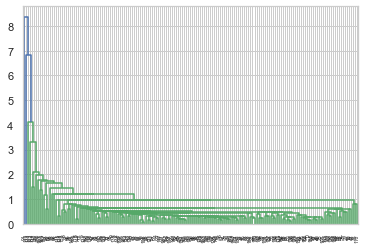

In [88]:
# Single linkage
sl = linkage(pca_m23_df,method="single",metric="euclidean")
dendrogram(sl)
plt.show()

* As we can see, at 4, we have 4 different clusters. Hence I choose to create the clusters with 4

##### Cut the Clusters & Derive Labels

In [89]:
# 4 Clusters
sl_cl_lbls = cut_tree(sl,n_clusters=4).reshape(-1,)

In [90]:
pca_m23["sl_cl_lbls"] = sl_cl_lbls
print("Number of Countries across each cluster\n",pca_m23["sl_cl_lbls"].value_counts())

Number of Countries across each cluster
 0    164
3      1
2      1
1      1
Name: sl_cl_lbls, dtype: int64


##### Visualize the first 2 Principal Components and Clustering

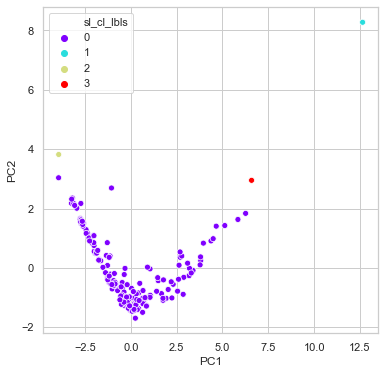

In [91]:
plt.figure(1,figsize=(6,6))
sns.scatterplot(x = pca_m23.PC1, y = pca_m23.PC2, hue=pca_m23.sl_cl_lbls, palette="rainbow")
plt.show()

* We could clearly see that with single linkage method, though 4 clusters have been formed, one single cluster has taken over most of the data points. This is not a good model to choose as majority of the data is in one single cluster

#### Hierarchial using Ward Linkage Method

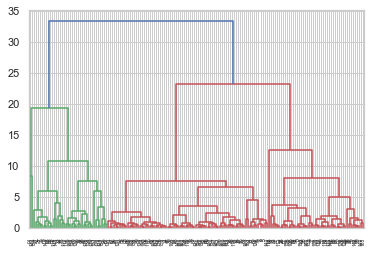

In [92]:
# Ward linkage
wrd = linkage(pca_m23_df,method="ward",metric="euclidean")
dendrogram(wrd)
plt.show()

* As we can see, at 15, we have 4 different clusters. Hence I choose to create the clusters with 4

##### Cut the Clusters & Derive Labels

In [93]:
# 4 Clusters
wrd_cl_lbls = cut_tree(wrd,n_clusters=4).reshape(-1,)

In [94]:
pca_m23["wrd_cl_lbls"] = wrd_cl_lbls
m2_df["wrd_cl_lbls"] = wrd_cl_lbls
c_df["M2_wrd_cl_lbls"] = wrd_cl_lbls
print("Number of Countries across each cluster\n",pca_m23["wrd_cl_lbls"].value_counts())

Number of Countries across each cluster
 1    80
0    48
2    37
3     2
Name: wrd_cl_lbls, dtype: int64


##### Visualize the first 2 Principal Components and Clusters

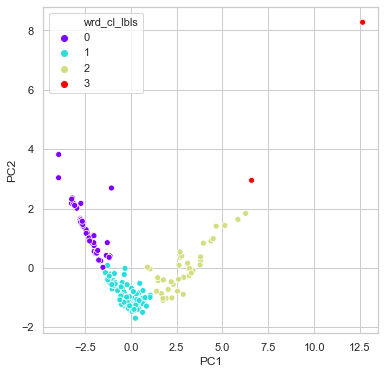

In [95]:
plt.figure(1,figsize=(6,6))
sns.scatterplot(x = pca_m23.PC1, y = pca_m23.PC2, hue=pca_m23.wrd_cl_lbls, palette="rainbow")
plt.show()

* We could clearly see that with ward linkage method, the 4 clusters are segregated and grouped as different clusters in 2 Dimensional wrt PC1 and PC2.

##### Visualize the first 3 Principal Components and Clusters

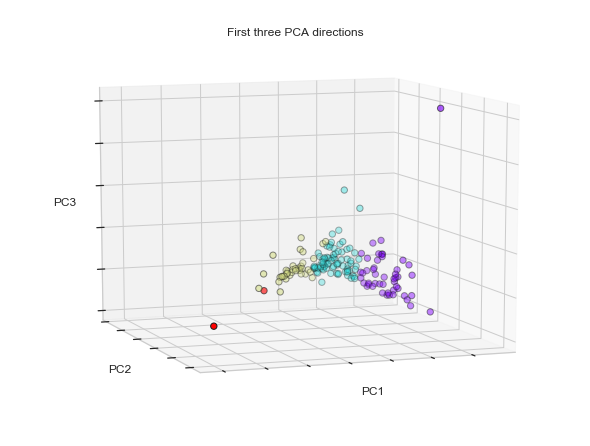

In [96]:
fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=10, azim=70)
ax.scatter(pca_m23['PC1'], pca_m23['PC2'], pca_m23['PC3'], c=np.array(pca_m23.wrd_cl_lbls),cmap=plt.cm.rainbow, edgecolor='k', s=40)
ax.set_title("First three PCA directions")
ax.set_xlabel("PC1")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("PC2")
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("PC3")
ax.w_zaxis.set_ticklabels([])

plt.show()

* We could clearly see that with ward linkage method, the 4 clusters are segregated and grouped as different clusters in 2 Dimensional wrt PC1 and PC2.

#### Hierarchial using Complete Linkage Method

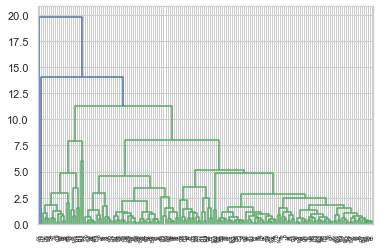

In [97]:
# Complete linkage
cmpl = linkage(pca_m23_df,method="complete",metric="euclidean")
dendrogram(cmpl)
plt.show()

* As we can see, at 10, we have 4 different clusters. Hence I choose to create the clusters with 4

##### Cut the Clusters & Derive Labels

In [98]:
# 4 Clusters
hr_cl_lbls = cut_tree(cmpl,n_clusters=4).reshape(-1,)

In [99]:
pca_m23["Hr_Lbls"] = hr_cl_lbls
m2_df["Hr_Lbls"] = hr_cl_lbls
c_df["M2_Hr_Lbls"] = hr_cl_lbls
print("Number of Countries across each cluster\n",pca_m23["Hr_Lbls"].value_counts())

Number of Countries across each cluster
 0    144
1     21
3      1
2      1
Name: Hr_Lbls, dtype: int64


##### Visualize the first 3 Principal Components and Clustering

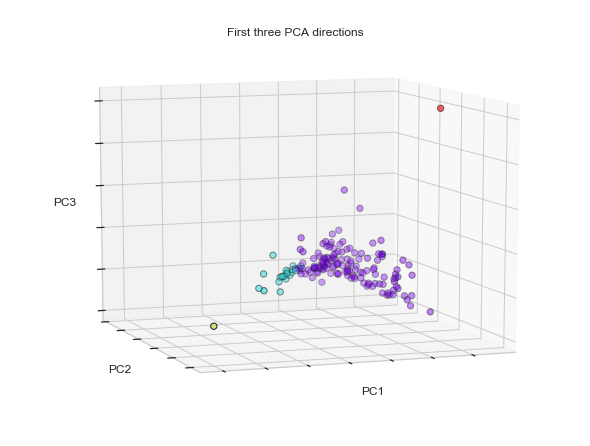

In [100]:
fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=10, azim=70)
ax.scatter(pca_m23['PC1'], pca_m23['PC2'], pca_m23['PC3'], c=np.array(pca_m23.Hr_Lbls),cmap=plt.cm.rainbow, edgecolor='k', s=40)
ax.set_title("First three PCA directions")
ax.set_xlabel("PC1")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("PC2")
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("PC3")
ax.w_zaxis.set_ticklabels([])

plt.show()

* We could clearly see that complete linkage method, the 4 clusters are segregated and grouped as different clusters in 2 Dimensional wrt PC1 and PC2.

##### Visualize the first 2 Principal Components and Clustering

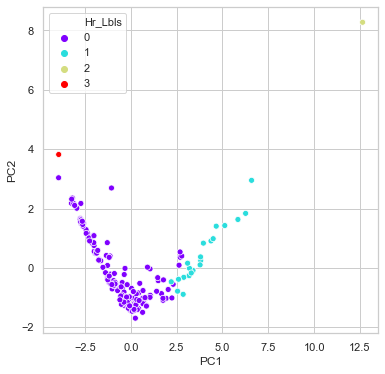

In [101]:
plt.figure(1,figsize=(6,6))
sns.scatterplot(x = pca_m23.PC1, y = pca_m23.PC2, hue=pca_m23.Hr_Lbls,markers=["o", "s", "D"], palette="rainbow")
plt.show()

* We could clearly see that complete linkage method, the 4 clusters are segregated and grouped as different clusters in 2 Dimensional wrt PC1 and PC2.

### Clustering using K-Means Modelling

__K-Means Steps__
* 1) k-means with some arbitrary k
* 2) Finding the Optimal Number of Clusters
     - Using SSD or Elbow Curve
     - Silhoute Analysis
* 3) Fit and derive the labels using the selected no fo clusters

In [102]:
# model and fit using KMeans
kmm = KMeans(n_clusters=3, max_iter=50,random_state=rndm_stat)

kmm.fit(pca_m23_df)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=50,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=1, tol=0.0001, verbose=0)

In [103]:
# Inspect the labels
kmm.labels_

array([2, 0, 0, 2, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 2, 0, 0, 0, 2,
       0, 1, 0, 2, 2, 0, 2, 1, 0, 2, 2, 0, 0, 0, 2, 2, 2, 0, 2, 0, 1, 0,
       1, 0, 0, 0, 0, 2, 2, 0, 0, 1, 1, 2, 2, 0, 1, 2, 0, 0, 0, 2, 2, 0,
       2, 0, 1, 0, 0, 0, 2, 1, 0, 1, 0, 1, 0, 0, 2, 2, 1, 0, 2, 0, 0, 2,
       2, 0, 0, 1, 0, 2, 2, 0, 0, 2, 1, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0,
       1, 1, 2, 2, 1, 0, 2, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 0, 2, 0, 0,
       2, 1, 0, 0, 2, 2, 0, 1, 0, 0, 2, 0, 1, 1, 0, 2, 0, 2, 2, 0, 0, 0,
       0, 2, 0, 1, 1, 1, 0, 0, 0, 0, 0, 2, 2])

#### Finding the optimal no of clusters using SSD / Elbow-Curve

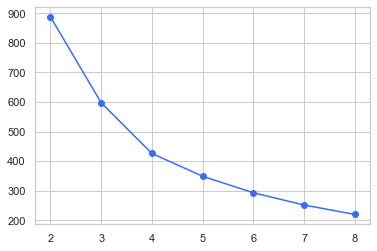

In [104]:
# elbow-curve / SSD (Sum of squred distances of samples to their closest cluster center)

ssd = []

for i in range(2,9):
    k_ssd = KMeans(n_clusters=i,max_iter=50,random_state=rndm_stat)
    k_ssd.fit(pca_m23_df)
    
    #append k-means inertia to array
    ssd.append(k_ssd.inertia_)

# plot the SSD's
plt.plot(range(2,9),ssd,marker="o")
plt.show()

#### Silhouette Analysis

$$\text{silhouette score}=\frac{p-q}{max(p,q)}$$

$p$ is the mean distance to the points in the nearest cluster that the data point is not a part of

$q$ is the mean intra-cluster distance to all the points in its own cluster.

* The value of the silhouette score range lies between -1 to 1. 

* A score closer to 1 indicates that the data point is very similar to other data points in the cluster, 

* A score closer to -1 indicates that the data point is not similar to the data points in its cluster.

In [105]:
# calculate Silhouette score

for i in range(2,9):
    
    # initialize k-means
    k_si = KMeans(n_clusters=i,max_iter=50,random_state=rndm_stat)
    k_si.fit(pca_m23_df)
    
    cls_labels = k_si.labels_
    
    # silhouette score
    si_scr = silhouette_score(pca_m23_df,cls_labels)
    print("For n_clusters={0} , Silhoutte Score is {1}".format(i,si_scr))

For n_clusters=2 , Silhoutte Score is 0.4805572698121072
For n_clusters=3 , Silhoutte Score is 0.4539474267793908
For n_clusters=4 , Silhoutte Score is 0.46270035395544085
For n_clusters=5 , Silhoutte Score is 0.46469876154257594
For n_clusters=6 , Silhoutte Score is 0.4060437022549396
For n_clusters=7 , Silhoutte Score is 0.34669397646099004
For n_clusters=8 , Silhoutte Score is 0.3305667378664377


K is decided based on 3 following metrics
* SSD / Elbow curve - 4 is optimal as elbow starts at 4
* Silhouette Analysis - 4 is optimal as Silhouette score is higher compared to 3.
* Business Decision - I choose 4 aswell as per both Elbow and Silhouette Analysis

In [106]:
# We start with no of clusters as 4

# model and fit using KMeans
kmm = KMeans(n_clusters=4, max_iter=50,random_state=rndm_stat)
kmm.fit(pca_m23_df)

# Inspect the labels
m23_km_cen = kmm.cluster_centers_
pca_m23["K_M_Lbls"] = kmm.labels_
m2_df["K_M_Lbls"] = kmm.labels_
c_df["M2_K_M_Lbls"] = kmm.labels_

#### Visualize the first 3 Principal Components and Clustering

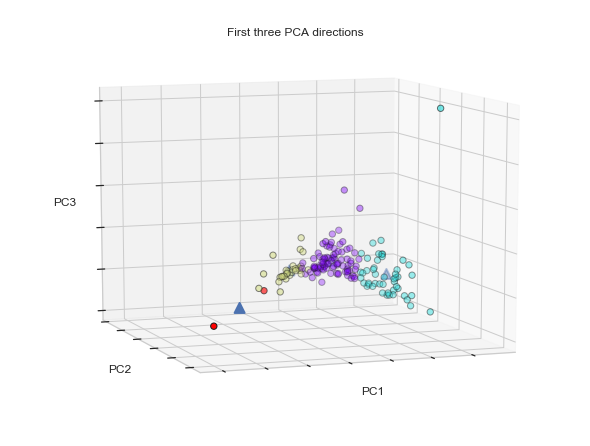

In [107]:
fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=10, azim=70)
ax.scatter(pca_m23['PC1'], pca_m23['PC2'], pca_m23['PC3'], c=np.array(pca_m23.K_M_Lbls),cmap=plt.cm.rainbow, edgecolor='k', s=40)
ax.scatter(m23_km_cen[:, 0], m23_km_cen[:, 1], m23_km_cen[:, 2],marker="^", s=100, linewidths=2,color='b', zorder=10)
ax.set_title("First three PCA directions")
ax.set_xlabel("PC1")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("PC2")
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("PC3")
ax.w_zaxis.set_ticklabels([])

plt.show()

* We could clearly see that K-Means clustering, the 4 clusters are segregated and grouped as different clusters in 2 Dimensional wrt PC1 and PC2.

#### Visualize the first 2 Principal Components and Clustering

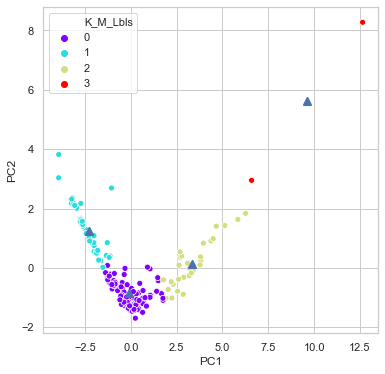

In [108]:
plt.figure(1,figsize=(6,6))
sns.scatterplot(x = pca_m23.PC1, y = pca_m23.PC2, hue=pca_m23.K_M_Lbls,markers=["o", "s", "D"], palette="rainbow")
plt.scatter(m23_km_cen[:, 0], m23_km_cen[:, 1], marker="^", s=50, linewidths=2,color='b', zorder=10)
ax.set_title("Clusters wrt 2 PC's")
plt.show()

* We could clearly see that K-Means clustering, the 4 clusters are segregated and grouped as different clusters in 3 Dimensional wrt PC1, PC2 and PC3.

## Model Selection

### Explore No of Clusters and Count of countries across each cluster

In [109]:
lbls_li = ["M1_wrd_cl_lbls","M1_Hr_Lbls","M1_K_M_Lbls","M2_wrd_cl_lbls","M2_Hr_Lbls","M2_K_M_Lbls"]
m_ev = c_df[lbls_li].apply(pd.Series.value_counts)
m_ev.fillna(0)

M1_wrd_cl_lbls  M1_Hr_Lbls  M1_K_M_Lbls  M2_wrd_cl_lbls  M2_Hr_Lbls  \
0              84          80           50              48         144   
1              39          45           29              80          21   
2              14          24            7              37           1   
3              30          18           81               2           1   

   M2_K_M_Lbls  
0           88  
1           48  
2           29  
3            2

In [110]:
# Compare the Silhouette scores of of K-Means clustering and Hirerchail Ward Clusters
m1_km_sil_scr = silhouette_score(pca_m13_df,np.array(c_df["M1_K_M_Lbls"]),random_state=100)
m1_wrd_sil_scr = silhouette_score(pca_m13_df,np.array(c_df["M1_wrd_cl_lbls"]),random_state=100)
m1_cmpl_sil_scr = silhouette_score(pca_m13_df,np.array(c_df["M1_Hr_Lbls"]),random_state=100)
print(color.BOLD+"Silhouette Score of Model 1 \nK-Means {}, \nHirerchial Ward {}, \nHirerchial Complete {}".format(m1_km_sil_scr,m1_wrd_sil_scr,m1_cmpl_sil_scr)+color.END)

Silhouette Score of Model 1 
K-Means 0.3953658435884942, 
Hirerchial Ward 0.34199342148297074, 
Hirerchial Complete 0.3492756835459845


In [111]:
# Compare the Silhouette scores of of K-Means clustering and Hirerchail Ward Clusters
m2_km_sil_scr = silhouette_score(pca_m23_df,np.array(c_df["M2_K_M_Lbls"]),random_state=100)
m2_wrd_sil_scr = silhouette_score(pca_m23_df,np.array(c_df["M2_wrd_cl_lbls"]),random_state=100)
m2_cmpl_sil_scr = silhouette_score(pca_m23_df,np.array(c_df["M2_Hr_Lbls"]),random_state=100)
print(color.BOLD+"Silhouette Score of Model 2 \nK-Means {}, \nHirerchial Ward {} and \nHirerchial Complete {}".format(m2_km_sil_scr,m2_wrd_sil_scr,m2_cmpl_sil_scr)+color.END)

Silhouette Score of Model 2 
K-Means 0.46270035395544085, 
Hirerchial Ward 0.4477335227984899 and 
Hirerchial Complete 0.49587215976423366


### Visualize & Compare the Clustering models

Model I - Clustering


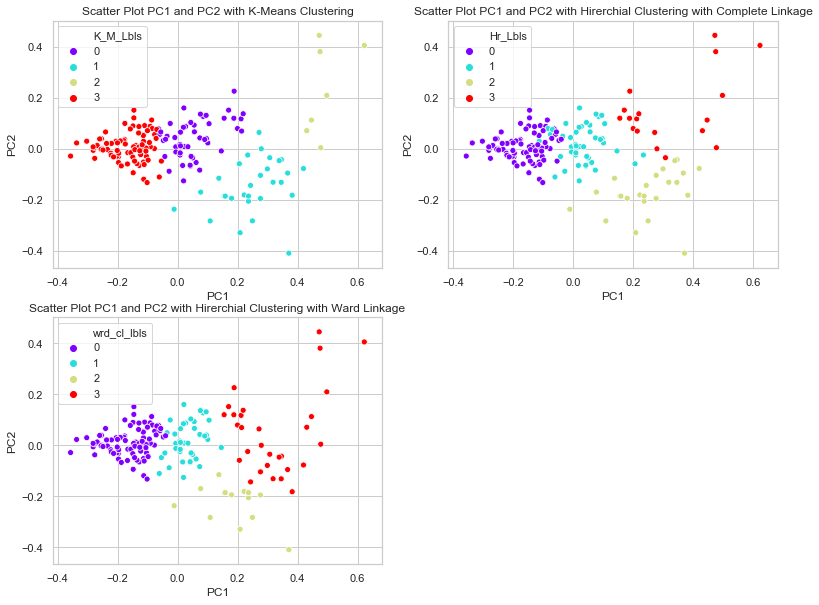

In [112]:
# Function to compare 2 different clusters wrt to 2 principal components 
print("Model I - Clustering")
m_scatter_plt(pca_m13,2,2,*(list(["K_M_Lbls","Hr_Lbls","wrd_cl_lbls"])))

__Inferences__
  1. M1 Hirerchial Ward and M1 Hirerchial Complete Models have lower silhouette score comparitively and this signifies the clusters are comparitively overlapped and hence will not be considered as final model.
  2. In M1 Complete Linkage, we could see that clearly clusters have lot of overlap and this might not be good choice to select as the final model.
  3. In K-Means the clusters can be clearly differentiated and there is no overlap among the clusters. Comparitively silhouette score is high.

Model II - Clustering


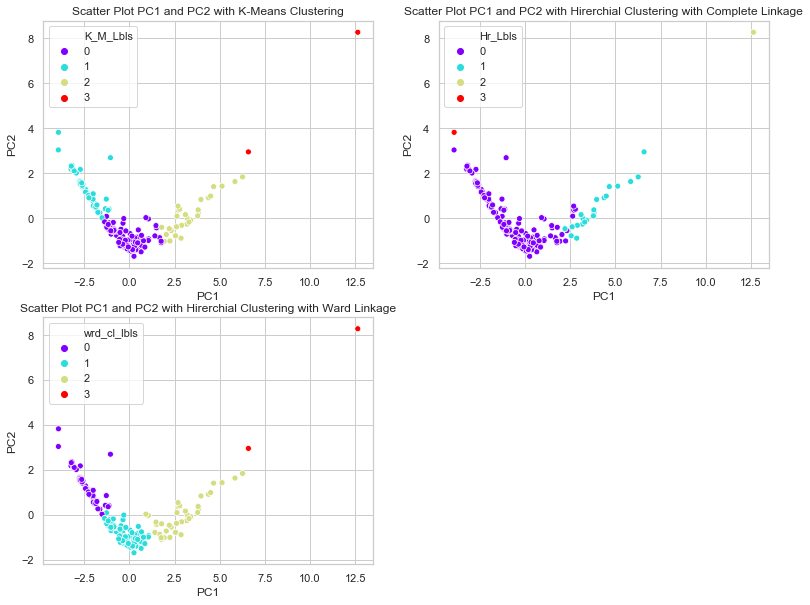

In [113]:
# Function to compare 2 different clusters wrt to 2 principal components 
print("Model II - Clustering")
m_scatter_plt(pca_m23,2,2,*(list(["K_M_Lbls","Hr_Lbls","wrd_cl_lbls"])))

__Inferences__
  1. Compared to M2 Ward Linkage or M2 K-Means, M2 Complete Linkage cluster formation is not distributed and looks like this is getting influenced because of the extreme values and M2 Complete Linkage cluster is not right candidate for final model.
  2. In M2 Ward Linkage, there is small overlap among the clusters and extreme 2 points form as different cluster.
  3. In M2 K-Means the clusters can be clearly differentiated and there is no overlap among the clusters.

### Inspect the models

In [114]:
# Explore Model 1 clusters with respect to original data
c_df[c_df.M1_K_M_Lbls==1]

country  child_mort  income  inflation  life_expec  total_fer  \
7             Australia         4.8   41400      1.160        82.0       1.93   
8               Austria         4.3   43200      0.873        80.5       1.44   
10              Bahamas        13.8   22900     -0.393        73.8       1.86   
13             Barbados        14.2   15300      0.321        76.7       1.78   
22               Brazil        19.8   14500      8.410        74.2       1.80   
29               Canada         5.6   40700      2.870        81.3       1.63   
42               Cyprus         3.6   33900      2.010        79.9       1.42   
44              Denmark         4.1   44000      3.220        79.5       1.87   
53              Finland         3.0   39800      0.351        80.0       1.87   
54               France         4.2   36900      1.050        81.4       2.03   
58              Germany         4.2   40400      0.758        80.1       1.39   
60               Greece         3.9   28700      0.673        80.4       1.48   
68              Iceland         2.6   38800      5.470        82.0       2.20   
74               Israel         4.6   29600      1.770        81.4       3.03   
75                Italy         4.0   36200      0.319        81.7       1.46   
77                Japan         3.2   35800     -1.900        82.8       1.39   
81             Kiribati        62.7    1730      1.520        60.7       3.84   
101  Micronesia_Fed_Sts        40.0    3340      3.800        65.4       3.46   
111         New_Zealand         6.2   32300      3.730        80.9       2.17   
114              Norway         3.2   62300      5.950        81.0       1.95   
122            Portugal         3.9   27200      0.643        79.8       1.39   
135            Slovenia         3.2   28700     -0.987        79.5       1.57   
139               Spain         3.8   32500      0.160        81.9       1.37   
144              Sweden         3.0   42900      0.991        81.5       1.98   
149         Timor_Leste        62.6    1850     26.500        71.1       6.23   
158      United_Kingdom         5.2   36200      1.570        80.3       1.92   
159       United_States         7.3   49400      1.220        78.7       1.93   
162             Vanuatu        29.2    2950      2.620        63.0       3.50   
163           Venezuela        17.1   16500     45.900        75.4       2.47   

      gdpp  exports_per_cap  health_per_cap  imports_per_cap  M1_wrd_cl_lbls  \
7    51900         10276.20        4530.870         10847.10               2   
8    46900         24059.70        5159.000         22418.20               3   
10   28000          9800.00        2209.200         12236.00               3   
13   16000          6320.00        1275.200          7792.00               3   
22   11200          1198.40        1009.120          1321.60               2   
29   47400         13793.40        5356.200         14694.00               2   
42   30800         15461.60        1838.760         17710.00               3   
44   58000         29290.00        6612.000         25288.00               3   
53   46200         17879.40        4134.900         17278.80               3   
54   40600         10880.80        4831.400         11408.60               2   
58   41800         17681.40        4848.800         15507.80               3   
60   26900          5944.90        2770.700          8258.30               2   
68   41900         22374.60        3938.600         18142.70               3   
74   30600         10710.00        2334.780         10067.40               3   
75   35800          9021.60        3411.740          9737.60               2   
77   44500          6675.00        4223.050          6052.00               2   
81    1490           198.17         168.370          1190.51               3   
101   2860           672.10         406.120          2316.60               3   
111  33700         10211.10        3403.700          9436.00     

In [115]:
# Explore Model 2 clusters clusters with respect to original data
c_df[c_df.M2_K_M_Lbls==2]

country  child_mort  income  inflation  life_expec  \
7               Australia         4.8   41400      1.160        82.0   
8                 Austria         4.3   43200      0.873        80.5   
15                Belgium         4.5   41100      1.880        80.0   
23                 Brunei        10.5   80600     16.700        77.1   
29                 Canada         5.6   40700      2.870        81.3   
42                 Cyprus         3.6   33900      2.010        79.9   
44                Denmark         4.1   44000      3.220        79.5   
53                Finland         3.0   39800      0.351        80.0   
54                 France         4.2   36900      1.050        81.4   
58                Germany         4.2   40400      0.758        80.1   
60                 Greece         3.9   28700      0.673        80.4   
68                Iceland         2.6   38800      5.470        82.0   
73                Ireland         4.2   45700     -3.220        80.4   
74                 Israel         4.6   29600      1.770        81.4   
75                  Italy         4.0   36200      0.319        81.7   
77                  Japan         3.2   35800     -1.900        82.8   
82                 Kuwait        10.8   75200     11.200        78.2   
98                  Malta         6.8   28300      3.830        80.3   
110           Netherlands         4.5   45500      0.848        80.7   
111           New_Zealand         6.2   32300      3.730        80.9   
114                Norway         3.2   62300      5.950        81.0   
123                 Qatar         9.0  125000      6.980        79.5   
135              Slovenia         3.2   28700     -0.987        79.5   
139                 Spain         3.8   32500      0.160        81.9   
144                Sweden         3.0   42900      0.991        81.5   
145           Switzerland         4.5   55500      0.317        82.2   
157  United_Arab_Emirates         8.6   57600     12.500        76.5   
158        United_Kingdom         5.2   36200      1.570        80.3   
159         United_States         7.3   49400      1.220        78.7   

     total_fer   gdpp  exports_per_cap  health_per_cap  imports_per_cap  \
7         1.93  51900          10276.2         4530.87          10847.1   
8         1.44  46900          24059.7         5159.00          22418.2   
15        1.86  44400          33921.6         4750.80          33166.8   
23        1.84  35300          23792.2         1002.52           9884.0   
29        1.63  47400          13793.4         5356.20          14694.0   
42        1.42  30800          15461.6         1838.76          17710.0   
44        1.87  58000          29290.0         6612.00          25288.0   
53        1.87  46200          17879.4         4134.90          17278.8   
54        2.03  40600          10880.8         4831.40          11408.6   
58        1.39  41800          17681.4         4848.80          15507.8   
60        1.48  26900           5944.9         2770.70           8258.3   
68        2.20  41900          22374.6         3938.60          18142.7   
73        2.05  48700          50161.0         4475.53          42125.5   
74        3.03  30600          10710.0         2334.78          10067.4   
75        1.46  35800           9021.6         3411.74           9737.6   
77        1.39  44500           6675.0         4223.05           6052.0   
82        2.21  38500          25679.5         1012.55          11704.0   
98        1.36  21100          32283.0         1825.15          32494.0   
110       1.79  50300          36216.0         5985.70          31990.8   
111       2.17  33700          10211.1         3403.70           9436.0   
114       1.95  87800          34856.6         8323.44          25023.0   
123       2.07  70300          43796.9         1272.43          16731.4   
135       1.57  23400          15046.2         2201.94          14718.6   
139       1.37  30700           7828.5         2928.78   

### Inferences and selection of the model

__Inferences__

Model M1 
  * As indicated based on the silhouette scores, looks like Timor Leste having low GDPP, higher mortality is part of the countries having low child_mort and high GDP.  This is not limited to 1 single model but it was across all the other models in M1. Probably in the eigne space of M1, this might be part of this cluster but the child_mort ranges from 3 to 62 and GDPP ranges from 3600 till 51900. As per my view, all the models in M1 might not be good models to choose.

Model M2
  * Comparitively all the models in M2 has clear clusters. In this cluster, child_mortality ranges from 2 to 10 and GDPP is high. There are no exceptions.  
  * __Based on above observations, I choose not to select any of the clustering models from Model 1 for my final model__. __In addition I choose to drop M2 Complete Hirerchial modelling based on the above inferences.__
  * __The clustering seems similar across M2 K-Means Clustering and M2 Ward Hirerchial clustering and we need more detailed comparision to finalise the final Model. However M2 K-Means clustering has higher silhouette score and this signifies that clusters do not overlap comparitively and Hence I choose M2 K-Means Cluster as my final model.__

In [116]:
# Group the primary 5 features based on M2-Kmeans Labels with mean, min and max
a = c_df.groupby(["M2_K_M_Lbls"])[pc_cols_2].agg(["mean","min","max"])

In [117]:
# Explore and inspect the grouped df
a

gdpp                child_mort               inflation  \
                     mean    min     max       mean   min    max       mean   
M2_K_M_Lbls                                                                   
0             7332.636364    592   28000  20.918182   3.4   64.4   7.295045   
1             1909.208333    231   17100  91.610417  28.1  208.0  11.911146   
2            44017.241379  21100   87800   5.082759   2.6   10.8   2.837690   
3            75800.000000  46600  105000   2.800000   2.8    2.8   1.787000   

                           health_per_cap                            income  \
               min     max           mean        min      max          mean   
M2_K_M_Lbls                                                                   
0           -4.210   45.90     482.897845    19.4636  2475.00  13455.568182   
1            0.885  104.00     114.821765    12.8212   766.08   3897.354167   
2           -3.220   16.70    4084.970000  1002.5200  8663.60  45800.000000   
3           -0.046    3.62    5001.930000  1845.3600  8158.50  81900.000000   

                            
               min     max  
M2_K_M_Lbls                 
0             1990   45400  
1              609   33700  
2            28300  125000  
3            72100   91700

__Observations from Grouped DF of K-Means Labels__
  * When we check the mean of each feature, across each cluster, the clusters are clearly segregated.
  * Across all the features, when we check the ranges, they dont overlap and clusters are clearly segregated.

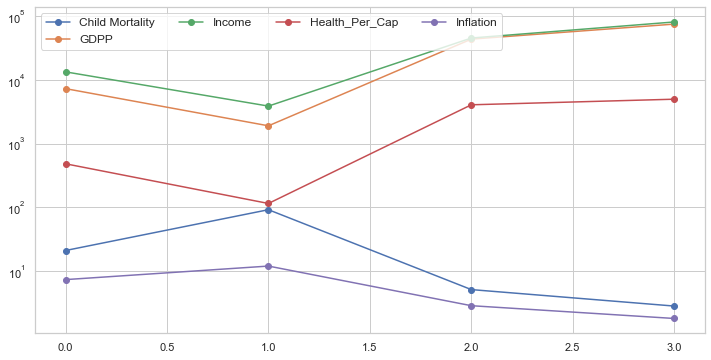

In [118]:
# Explore the mean of each feature across each cluster.
plt.figure(figsize=(12,6))
plt.plot(c_df.groupby(["M2_K_M_Lbls"])["child_mort"].agg(["mean"]),marker="o",label="Child Mortality")
plt.plot(c_df.groupby(["M2_K_M_Lbls"])["gdpp"].agg(["mean"]),marker="o",label="GDPP")
plt.plot(c_df.groupby(["M2_K_M_Lbls"])["income"].agg(["mean"]),marker="o",label="Income")
plt.plot(c_df.groupby(["M2_K_M_Lbls"])["health_per_cap"].agg(["mean"]),marker="o",label="Health_Per_Cap")
plt.plot(c_df.groupby(["M2_K_M_Lbls"])["inflation"].agg(["mean"]),marker="o",label="Inflation")
plt.yscale("log")
plt.legend(loc=2, ncol=4,fontsize="medium")
plt.show()

### Drop the columns with other lables

In [119]:
# Drop labels from c_df
c_df = c_df.drop(["M1_wrd_cl_lbls","M1_Hr_Lbls","M1_K_M_Lbls","M2_Hr_Lbls","M2_wrd_cl_lbls"],axis=1)
c_df.columns

Index(['country', 'child_mort', 'income', 'inflation', 'life_expec',
       'total_fer', 'gdpp', 'exports_per_cap', 'health_per_cap',
       'imports_per_cap', 'M2_K_M_Lbls'],
      dtype='object')

## Visualize the Clusters and Analyze with respect to original data

* In this section, we try to explore the features across different clusters with respect to original data.

### Features that explain 95%+ variance

In [120]:
print(color.BOLD+"Features that explain 95%+ variance in the Model are \n",pc_cols_2)

Features that explain 95%+ variance in the Model are 
 ['gdpp', 'child_mort', 'inflation', 'health_per_cap', 'income']


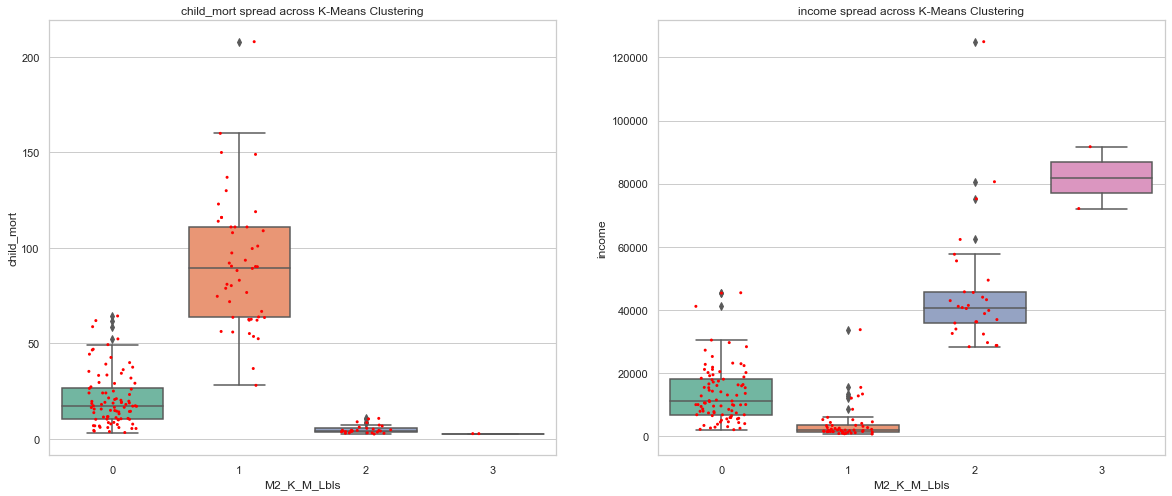

In [121]:
# comp_box_plt takes a df, dimensions of subplot (no of rows and columns), dependent variable and variable list of columns
# to plot multiple comparitive box plots
# Part - 1
comp_box_plt(c_df,1,2,"M2_K_M_Lbls",*list(c_df.columns[1:3]))

__Inferences__
  * Across Child Mortality and Income, we could clearly differentiate the ranges of the clusters. 
  * __There is no overlap in IQR of each cluster.__ 
  * Cluster 1 has highest Child Mortality and Cluster 3 has lowest range of Child Mortality. While Cluster 3 has highest Income range followed by 2, 0 and 1.

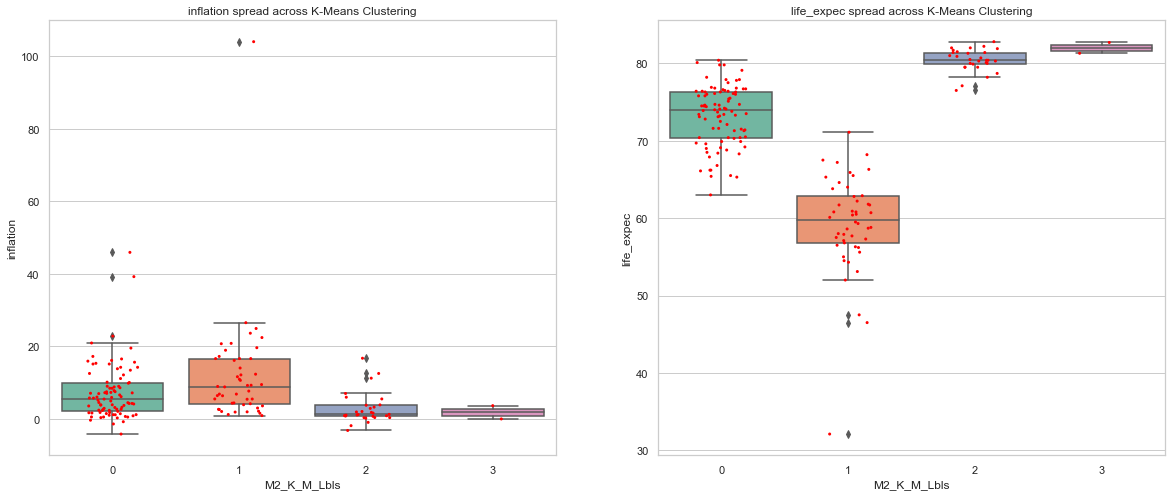

In [122]:
# comp_box_plt takes a df, dimensions of subplot (no of rows and columns), dependent variable and variable list of columns
# to plot multiple comparitive box plots
# Part - 2
comp_box_plt(c_df,1,2,"M2_K_M_Lbls",*list(c_df.columns[3:5]))

__Inferences__
  * There is overlap among IQR ranges of Inflation across Clusters. While Cluster 1 and 0 have high inflation, Clusters 2 and 3 have low avg inflation rates. 
  * __Across life expectancy there is no overlap in IQR of each cluster.__ 
  * Cluster 1 has very low avg expectancy, followed by 0, 2 and 3.

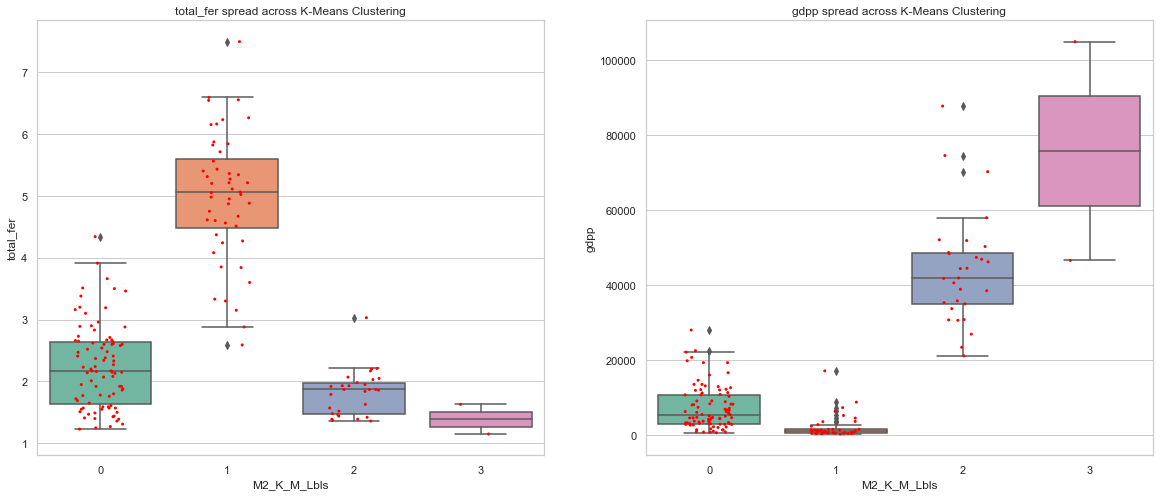

In [123]:
# comp_box_plt takes a df, dimensions of subplot (no of rows and columns), dependent variable and variable list of columns
# to plot multiple comparitive box plots
# Part - 3
comp_box_plt(c_df,1,2,"M2_K_M_Lbls",*list(c_df.columns[5:7]))

__Inferences__
  * __This is quite interesting observation of Total Fertility. Cluster 1 having highest child mortality and lowest life expectancy has very high fertility. Comparitively developed countries have very low fertility and this might be due to life style changes in the developed countries.__
  * __Across GDPP there is no overlap in IQR of each cluster. Cluster 3 has highest GDPP avg, followed by 2, 0 and 1__.

__Inferences__


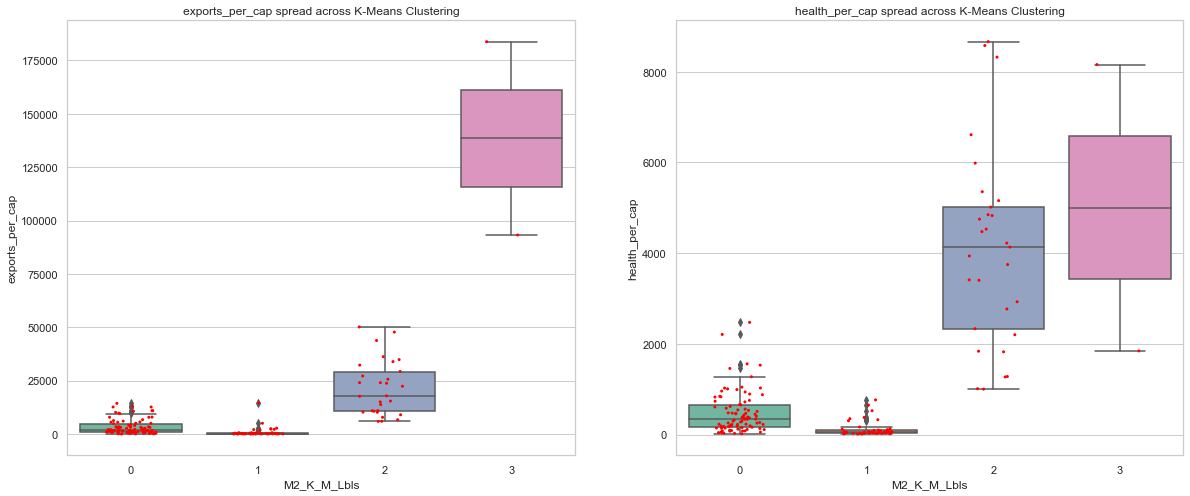

In [124]:
# comp_box_plt takes a df, dimensions of subplot (no of rows and columns), dependent variable and variable list of columns
# to plot multiple comparitive box plots
# Part - 4
comp_box_plt(c_df,1,2,"M2_K_M_Lbls",*list(c_df.columns[7:9]))

__Inferences__
  * Cluster 3 has very high avg exports_per_capita followed by 2,0 and 1. Across exports_per_capita there is no overlap among IQR of each cluster.
  * Cluster 3 has very high avg health_per_capita spending followed by 2,0 and 1. Across health_per_capita spending there is no overlap among IQR of each cluster.

__Inferences__


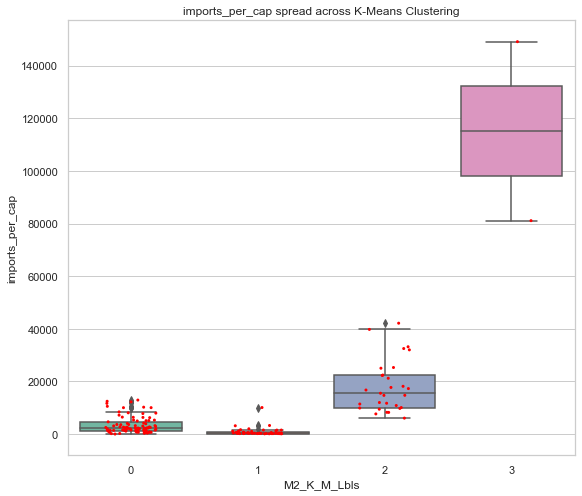

In [125]:
# comp_box_plt takes a df, dimensions of subplot (no of rows and columns), dependent variable and variable list of columns
# to plot multiple comparitive box plots
# Part - 4
comp_box_plt(c_df,1,2,"M2_K_M_Lbls",*list(c_df.columns[9:10]))

__Inferences__
  * Cluster 1 has very low avg imports_per_capita followed by 0,2 and 3. Across exports_per_capita there is no overlap among IQR of each cluster.

### Visualize the Scattered Correlogram of Clusters across all the Principal Components

In [126]:
# update the pc_cols_2 with lables for plotting correlogram
pc_cols_2.append("M2_K_M_Lbls")
pc_cols_2

['gdpp', 'child_mort', 'inflation', 'health_per_cap', 'income', 'M2_K_M_Lbls']

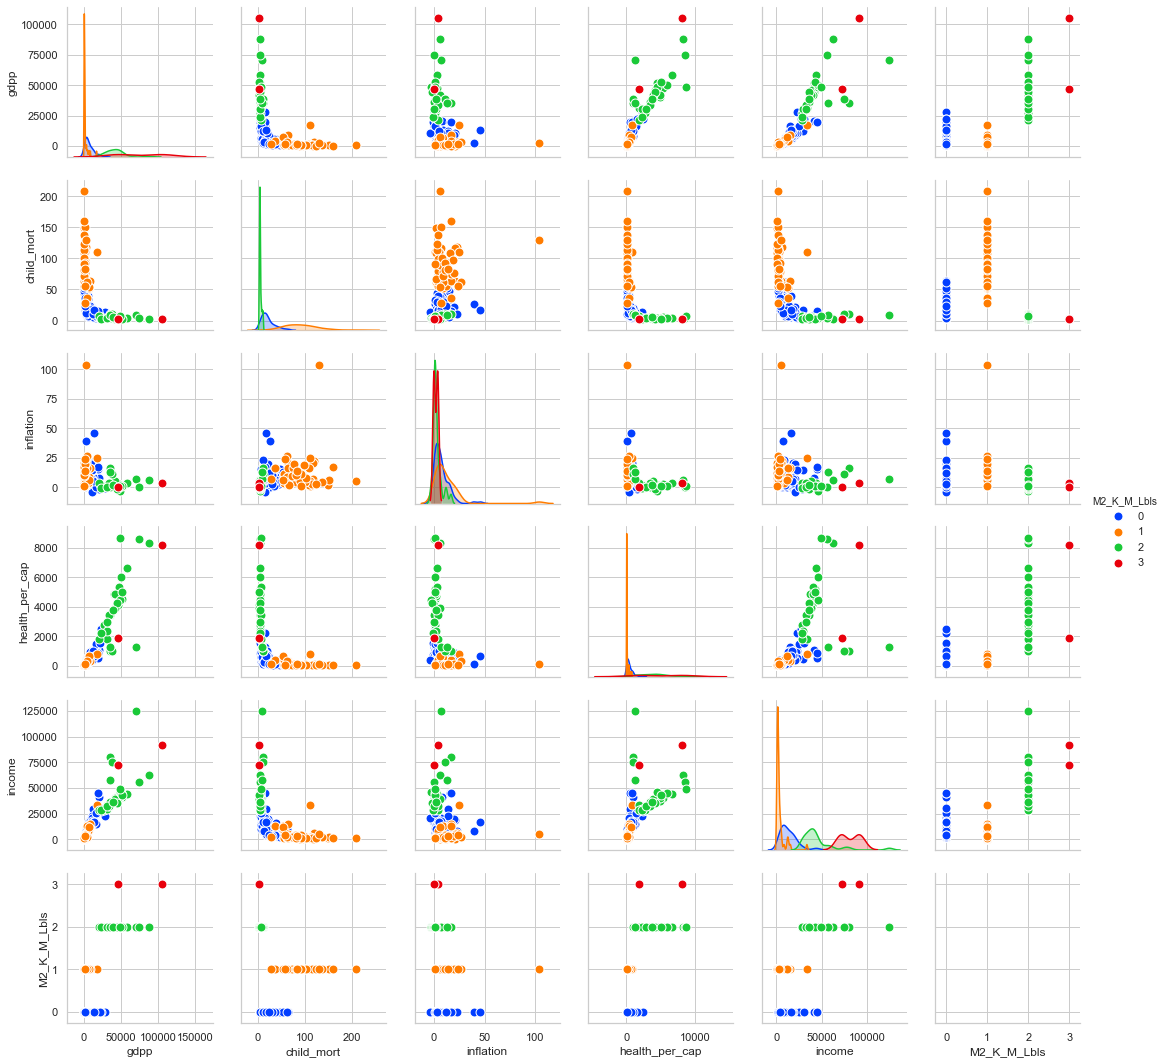

In [127]:
# Scattered Correlogram  plot 
sns.pairplot(c_df[pc_cols_2], kind="scatter", hue="M2_K_M_Lbls", plot_kws=dict(s=80, linewidth=1), palette="bright")
plt.show()

__Inferences__
  * Above Pairplot illustrates that clusters are nicely grouped. All the observations we had during initial analysis are clearly visible wrt clusters.

### Explore the data based on each cluster

#### Cluster with Label 0

In [128]:
# create a df with cluster 0 and explore the df
avg_c_df = c_df[c_df.M2_K_M_Lbls==0]
avg_c_df = avg_c_df.sort_values(by="gdpp",ascending=True)
avg_c_df

country  child_mort  income  inflation  life_expec  \
109                          Nepal        47.0    1990     15.100        68.3   
146                     Tajikistan        52.4    2110     12.500        69.6   
12                      Bangladesh        49.4    2440      7.140        70.4   
27                        Cambodia        44.4    2520      3.120        66.1   
83                 Kyrgyz_Republic        29.6    2790     10.000        68.5   
107                        Myanmar        64.4    3720      7.040        66.8   
164                        Vietnam        23.3    4490     12.100        73.1   
69                           India        58.8    4410      8.980        66.2   
161                     Uzbekistan        36.3    4240     16.500        68.8   
102                        Moldova        17.2    3910     11.100        69.7   
19                         Bolivia        46.6    5410      8.780        71.6   
120                    Philippines        31.9    5600      4.220        69.0   
18                          Bhutan        42.7    6420      5.990        72.1   
47                           Egypt        29.1    9860     10.100        70.5   
103                       Mongolia        26.1    7710     39.200        66.2   
140                      Sri_Lanka        11.2    8560     22.800        74.4   
105                        Morocco        33.5    6440      0.976        73.5   
62                       Guatemala        35.4    6710      5.140        71.3   
101             Micronesia_Fed_Sts        40.0    3340      3.800        65.4   
57                         Georgia        16.5    6730      8.550        72.8   
156                        Ukraine        11.7    7820     13.400        70.4   
162                        Vanuatu        29.2    2950      2.620        63.0   
48                     El_Salvador        19.2    7300      2.650        74.1   
65                          Guyana        37.6    5840      5.730        65.5   
70                       Indonesia        33.3    8430     15.300        69.9   
6                          Armenia        18.1    6700      7.770        73.3   
118                       Paraguay        24.1    7290      6.100        74.1   
30                      Cape_Verde        26.5    5830      0.505        72.5   
127                          Samoa        18.9    5400      1.720        71.5   
151                          Tonga        17.4    4980      3.680        69.9   
52                            Fiji        24.1    7350      4.230        65.3   
78                          Jordan        21.1    9470      8.430        75.8   
1                          Albania        16.6    9930      4.490        76.3   
152                        Tunisia        17.4   10400      3.820        76.9   
16                          Belize        18.8    7880      1.140        71.4   
154                   Turkmenistan        62.0    9940      2.310        67.9   
2                          Algeria        27.3   12900     16.100        76.5   
92                   Macedonia_FYR        10.4   11400      2.040        74.0   
34                           China        15.7    9530      6.940        74.6   
20          Bosnia_and_Herzegovina         6.9    9720      1.400        76.8   
46                         Ecuador        25.1    9350      7.470        76.7   
76                         Jamaica        18.1    8000      9.810        74.7   
119                           Peru        20.3    9960      5.710        77.9   
148                       Thailand        14.9   13500      4.080        76.6   
130                         Serbia         7.6   12700      5.880        74.7   
45              Dominican_Republic        34.4   11100      5.440        74.6   
9                       Azerbaijan        39.2   16000     13.800        69.1   
14                         Belarus         5.5   16200     15.100        70.4   
141  St_Vincent_and_the_Grenadines        20.7    9920    

In [129]:
# Explore the cluster with the primary features based on which clusters are formed
avg_c_df[pc_cols_2].describe()

gdpp  child_mort  inflation  health_per_cap        income  \
count     88.000000   88.000000  88.000000       88.000000     88.000000   
mean    7332.636364   20.918182   7.295045      482.897845  13455.568182   
std     5857.101771   13.965907   7.809170      461.499593   9051.018722   
min      592.000000    3.400000  -4.210000       19.463600   1990.000000   
25%     2985.000000   10.550000   2.242500      173.930500   6725.000000   
50%     5245.000000   17.400000   5.575000      341.191000  11000.000000   
75%    10725.000000   26.700000   9.857500      656.572500  18075.000000   
max    28000.000000   64.400000  45.900000     2475.000000  45400.000000   

       M2_K_M_Lbls  
count         88.0  
mean           0.0  
std            0.0  
min            0.0  
25%            0.0  
50%            0.0  
75%            0.0  
max            0.0

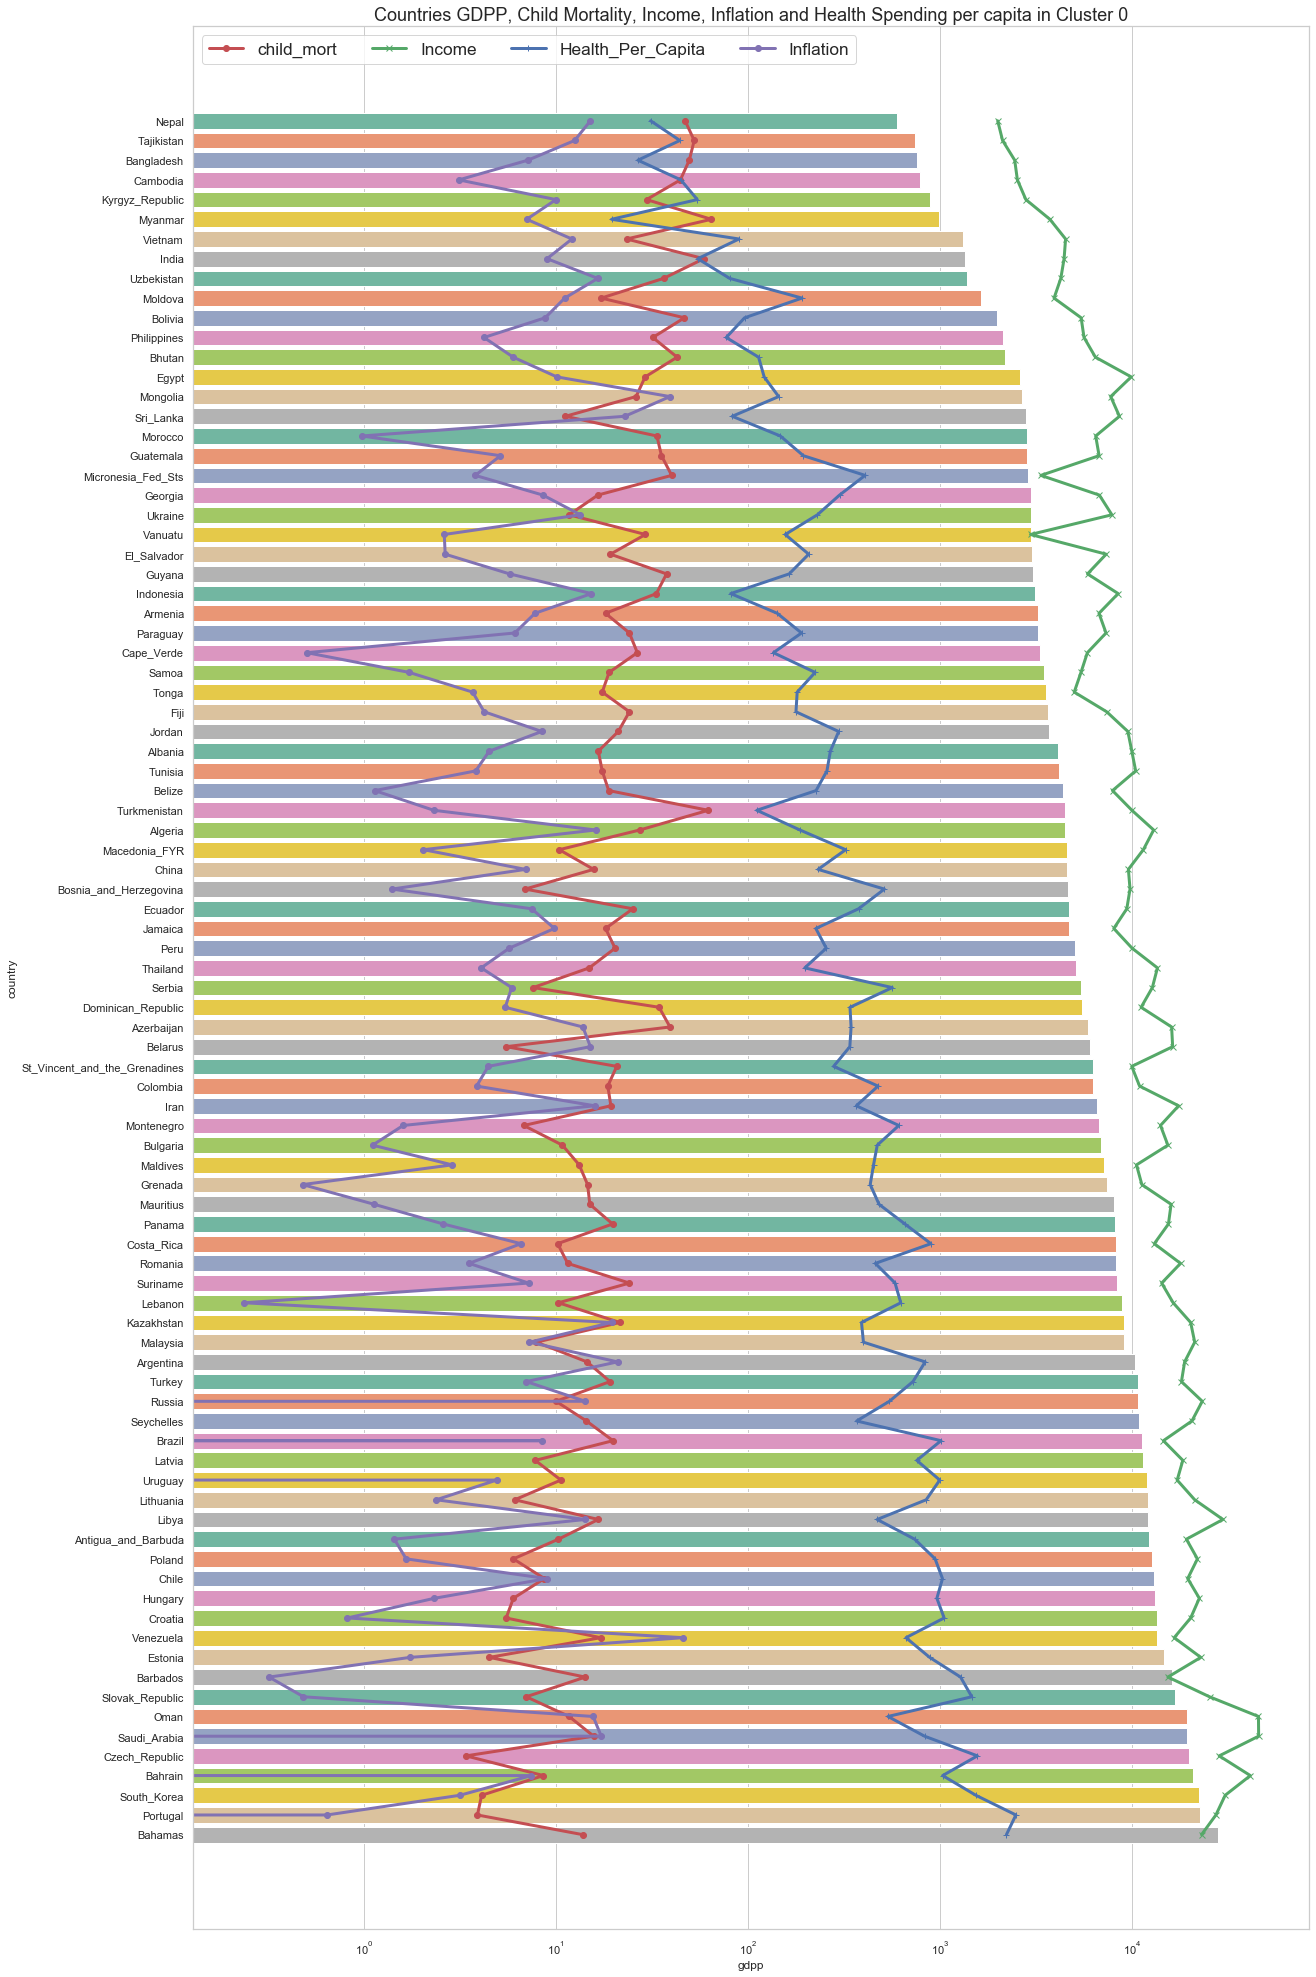

In [130]:
# Plot the features which contribute to 95% of the variance across the cluster
plt.figure(figsize=(20,35))
sns.barplot(y='country',x='gdpp',data=avg_c_df,palette='Set2',log=True)
plt.plot(avg_c_df.child_mort,avg_c_df.country,marker="o",linewidth=3, alpha=1,color="r",label="child_mort")
plt.plot(avg_c_df.income,avg_c_df.country,marker="x",linewidth=3, alpha=1,color="g",label="Income")
plt.plot(avg_c_df.health_per_cap,avg_c_df.country,marker="+",linewidth=3, alpha=1,color="b",label="Health_Per_Capita")
plt.plot(avg_c_df.inflation,avg_c_df.country,marker="o",linewidth=3, alpha=1,color="m",label="Inflation")
plt.legend(loc=2, ncol=4,fontsize="x-large")
plt.title("Countries GDPP, Child Mortality, Income, Inflation and Health Spending per capita in Cluster 0", fontsize=18 )
plt.show()

__Cluster 0 - Avg Socio-Economic and Health Countries - Inferences__
  *  Across this cluster,
     * 1) GDPP ranges from 592 to 28000 and with average gdpp of 7332.
     * 2) Child Mortality ranges from 3 to 64 and with  average child mortality of 20.
     * 3) Income ranges from 1990 to 45400 and with  average income of 13455. 
     * 4) Inflation ranges from -4 to 45 and with  average inflation of 7
     * 5) Health Per Capita ranges from 19 to 2475 and with average health per capita of 482
  * This segment is represented by 50% of the countries. These are developing countries or in otherwards average socio economic conditions.
  * Czech_Republic has lowest Child Mortaltiy, Oman and Saudi have highest income, Nepal has lowest income and gdpp and Bahamas has high GDPP in this segment.
  * We could clearly visualize, countries having higher GDPP have comparitively higher income, health spending and this reduces child mortality.

#### Cluster with Label 1

In [131]:
# create a df with cluster 0 and explore the df
bkwd_c_df = c_df[c_df.M2_K_M_Lbls==1]
bkwd_c_df = bkwd_c_df.sort_values(by="gdpp",ascending=True)
bkwd_c_df

country  child_mort  income  inflation  life_expec  \
26                    Burundi        93.6     764     12.300        57.7   
88                    Liberia        89.3     700      5.470        60.8   
37              Congo_Dem_Rep       116.0     609     20.800        57.5   
112                     Niger       123.0     814      2.550        58.8   
132              Sierra_Leone       160.0    1220     17.200        55.0   
93                 Madagascar        62.2    1390      8.790        60.8   
106                Mozambique       101.0     918      7.640        54.5   
31   Central_African_Republic       149.0     888      2.010        47.5   
94                     Malawi        90.5    1030     12.100        53.1   
50                    Eritrea        55.2    1420     11.600        61.7   
150                      Togo        90.3    1210      1.180        58.7   
64              Guinea_Bissau       114.0    1390      2.970        55.6   
0                 Afghanistan        90.2    1610      9.440        56.2   
56                     Gambia        80.3    1660      4.300        65.5   
126                    Rwanda        63.6    1350      2.610        64.6   
25               Burkina_Faso       116.0    1430      6.810        57.9   
155                    Uganda        81.0    1540     10.600        56.8   
63                     Guinea       109.0    1190     16.100        58.0   
66                      Haiti       208.0    1500      5.450        32.1   
147                  Tanzania        71.9    2090      9.250        59.3   
97                       Mali       137.0    1870      4.370        59.5   
17                      Benin       111.0    1820      0.885        61.8   
36                    Comoros        88.2    1410      3.870        65.9   
32                       Chad       150.0    1930      6.390        56.5   
80                      Kenya        62.2    2480      2.090        62.8   
129                   Senegal        66.8    2180      1.850        64.0   
116                  Pakistan        92.1    4280     10.900        65.3   
84                        Lao        78.9    3980      9.200        63.8   
87                    Lesotho        99.7    2380      4.150        46.5   
99                 Mauritania        97.4    3320     18.900        68.2   
40              Cote_d_Ivoire       111.0    2690      5.390        56.3   
136           Solomon_Islands        28.1    1780      6.810        61.7   
165                     Yemen        56.3    4480     23.600        67.5   
28                   Cameroon       108.0    2660      1.910        57.3   
59                      Ghana        74.7    3060     16.600        62.2   
166                    Zambia        83.1    3280     14.000        52.0   
142                     Sudan        76.7    3370     19.600        66.3   
81                   Kiribati        62.7    1730      1.520        60.7   
113                   Nigeria       130.0    5150    104.000        60.5   
38                  Congo_Rep        63.9    5190     20.700        60.4   
3                      Angola       119.0    5900     22.400        60.1   
149               Timor_Leste        62.6    1850     26.500        71.1   
72                       Iraq        36.9   12700     16.600        67.2   
108                   Namibia        56.0    8460      3.560        58.6   
21                   Botswana        52.5   13300      8.920        57.1   
137              South_Africa        53.7   12000      6.350        54.3   
55                      Gabon        63.7   15400     16.600        62.9   
49          Equatorial_Guinea       111.0   33700     24.900        60.9   

     total_fer   gdpp  exports_per_cap  health_per_cap  imports_per_cap  \
26        6.26    231          20.6052         26.7960           90.552   
88        5.02    327          62.4570         38.5860          302.802   
37        6.54    334         137.2740         26.4194          165.664 

In [132]:
# Explore the cluster with the primary features based on which clusters are formed
bkwd_c_df[pc_cols_2].describe()

gdpp  child_mort   inflation  health_per_cap        income  \
count     48.000000   48.000000   48.000000       48.000000     48.000000   
mean    1909.208333   91.610417   11.911146      114.821765   3897.354167   
std     2925.911009   34.319855   15.362485      165.518331   5590.168621   
min      231.000000   28.100000    0.885000       12.821200    609.000000   
25%      551.500000   63.675000    4.080000       34.005875   1390.000000   
50%      932.000000   89.750000    8.855000       51.613500   1860.000000   
75%     1465.000000  111.000000   16.600000       95.303250   3522.500000   
max    17100.000000  208.000000  104.000000      766.080000  33700.000000   

       M2_K_M_Lbls  
count         48.0  
mean           1.0  
std            0.0  
min            1.0  
25%            1.0  
50%            1.0  
75%            1.0  
max            1.0

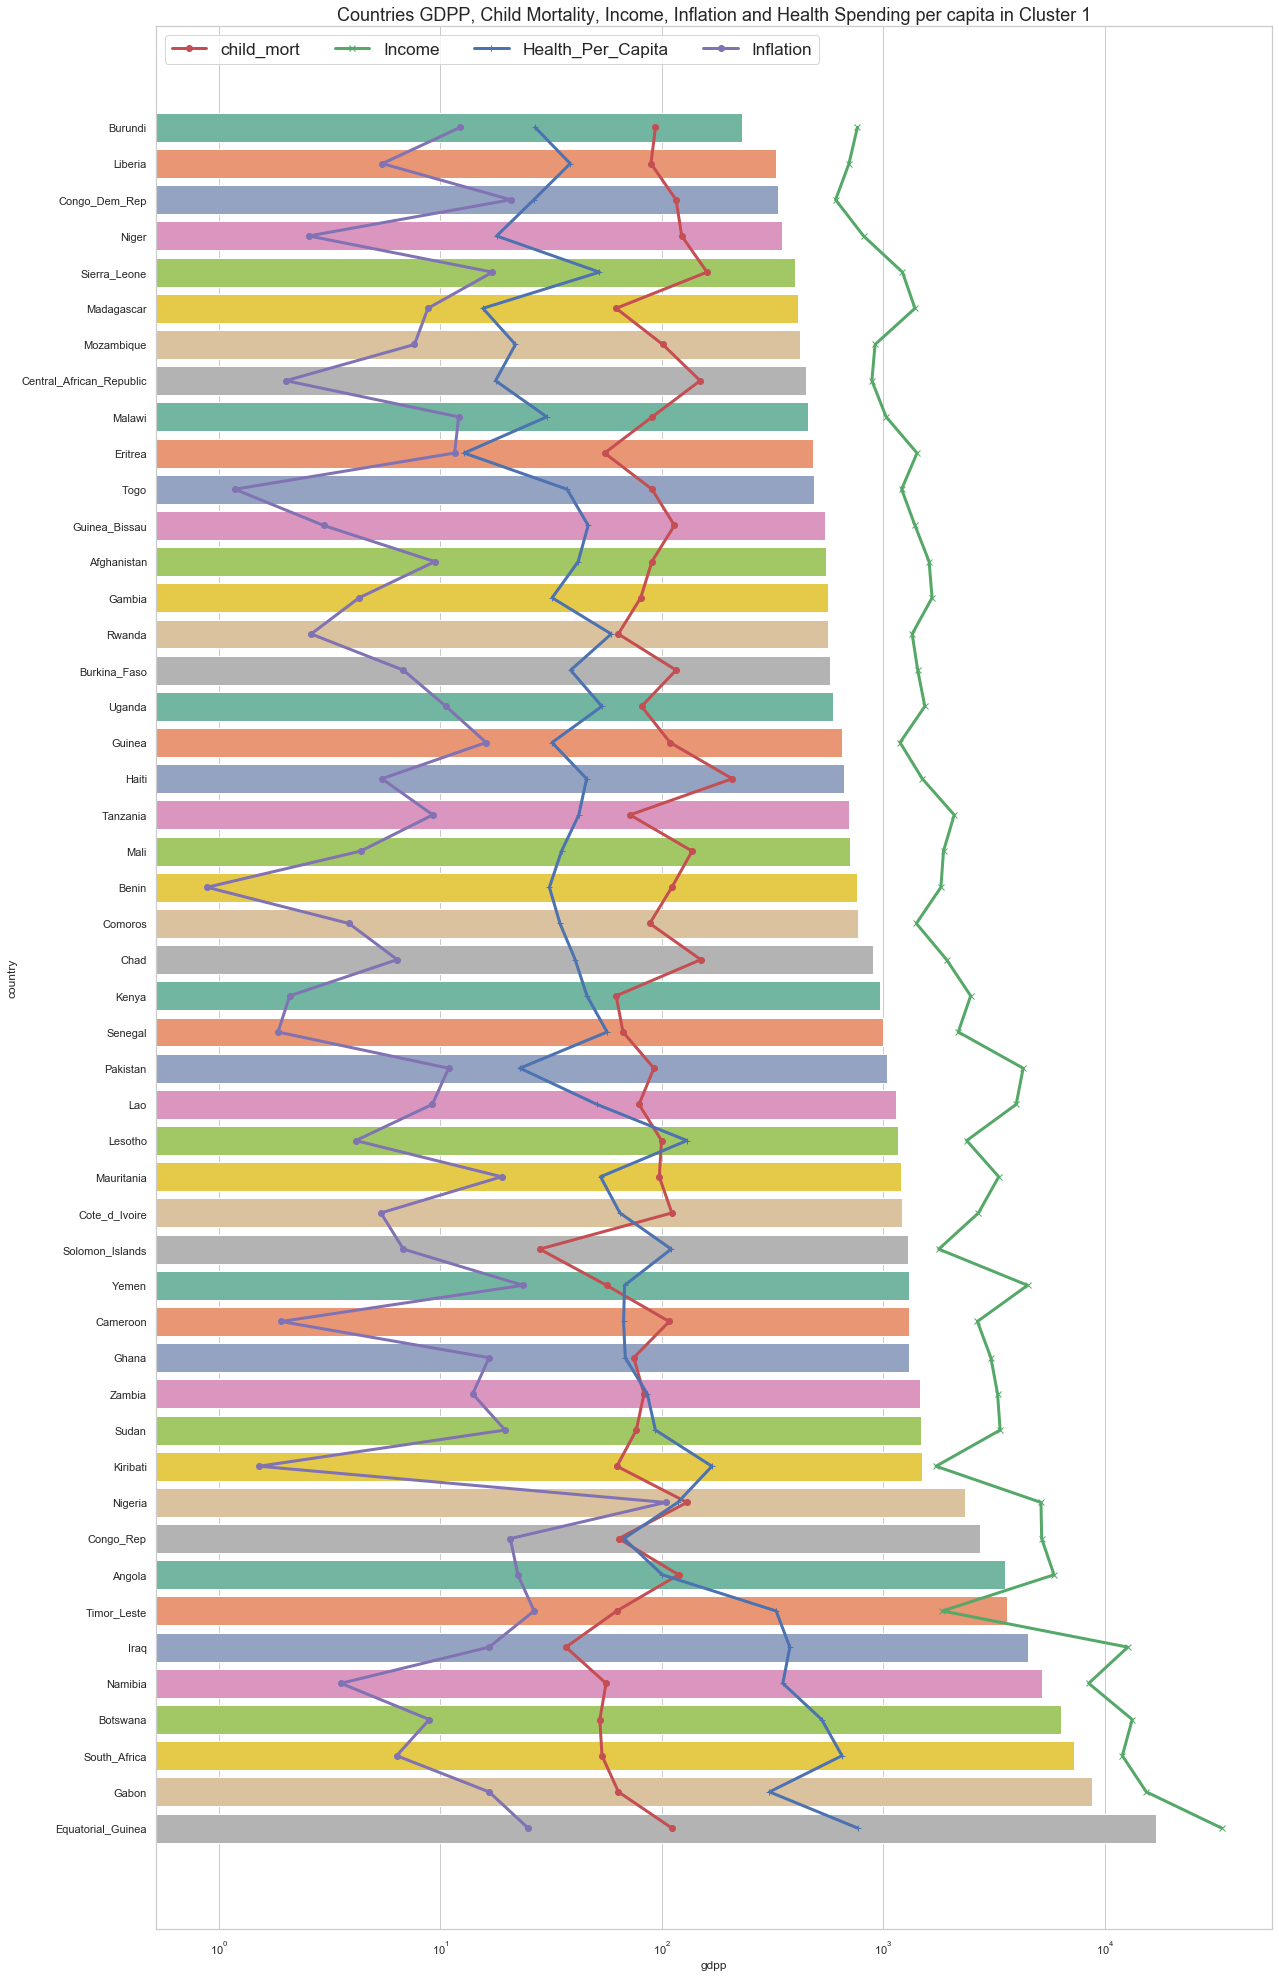

In [133]:
# Plot the features which contribute to 95% of the variance across the cluster
plt.figure(figsize=(20,35))
sns.barplot(y='country',x='gdpp',data=bkwd_c_df,palette='Set2',log=True)
plt.plot(bkwd_c_df.child_mort,bkwd_c_df.country,marker="o",linewidth=3, alpha=1,color="r",label="child_mort")
plt.plot(bkwd_c_df.income,bkwd_c_df.country,marker="x",linewidth=3, alpha=1,color="g",label="Income")
plt.plot(bkwd_c_df.health_per_cap,bkwd_c_df.country,marker="+",linewidth=3, alpha=1,color="b",label="Health_Per_Capita")
plt.plot(bkwd_c_df.inflation,bkwd_c_df.country,marker="o",linewidth=3, alpha=1,color="m",label="Inflation")
plt.legend(loc=2, ncol=4,fontsize="x-large")
plt.title("Countries GDPP, Child Mortality, Income, Inflation and Health Spending per capita in Cluster 1", fontsize=18 )
plt.show()

__Cluster 1 - Very low Socio-Economic and Health Countries - Inferences__
  *  Across this cluster,
     * 1) GDPP ranges from 231 to 17100 and with average gdpp of 1909.
     * 2) Child Mortality ranges from 28 to 208 and with  average child mortality of 91.
     * 3) Income ranges from 609 to 33700 and with  average income of 3897.
     * 4) Inflation ranges from 0 to 104 and with  average inflation of 11.
     * 5) Health Per Capita ranges from 12 to 766 and with average health per capita of 114.
  * This segment is represented by 30% of the total countries. These are backward countries or in otherwards very low socio economic conditions.
  * Haiti, Seirra Leone and Central African Republic have highest Child Mortality. Solomon Islands has lowest child mortality in this segment.
  * Burundi, Liberia and Congo Dem Rep have lowest GDPP and Equatorial Guinea and Gabon have highest GDPP.
  * Congo Dem Rep has lowest income levels
  * Geographically this segment is represented by majority of the African continent.
  * Some countries have very high child mortaltiy though having comparitively higher GDPP and income. 

#### Cluster with Label 2

In [134]:
# create a df with cluster 2 and explore the df
dvlpd_c_df = c_df[c_df.M2_K_M_Lbls==2]
dvlpd_c_df = dvlpd_c_df.sort_values(by="gdpp",ascending=True)
dvlpd_c_df

country  child_mort  income  inflation  life_expec  \
98                  Malta         6.8   28300      3.830        80.3   
135              Slovenia         3.2   28700     -0.987        79.5   
60                 Greece         3.9   28700      0.673        80.4   
74                 Israel         4.6   29600      1.770        81.4   
139                 Spain         3.8   32500      0.160        81.9   
42                 Cyprus         3.6   33900      2.010        79.9   
111           New_Zealand         6.2   32300      3.730        80.9   
157  United_Arab_Emirates         8.6   57600     12.500        76.5   
23                 Brunei        10.5   80600     16.700        77.1   
75                  Italy         4.0   36200      0.319        81.7   
82                 Kuwait        10.8   75200     11.200        78.2   
158        United_Kingdom         5.2   36200      1.570        80.3   
54                 France         4.2   36900      1.050        81.4   
58                Germany         4.2   40400      0.758        80.1   
68                Iceland         2.6   38800      5.470        82.0   
15                Belgium         4.5   41100      1.880        80.0   
77                  Japan         3.2   35800     -1.900        82.8   
53                Finland         3.0   39800      0.351        80.0   
8                 Austria         4.3   43200      0.873        80.5   
29                 Canada         5.6   40700      2.870        81.3   
159         United_States         7.3   49400      1.220        78.7   
73                Ireland         4.2   45700     -3.220        80.4   
110           Netherlands         4.5   45500      0.848        80.7   
7               Australia         4.8   41400      1.160        82.0   
144                Sweden         3.0   42900      0.991        81.5   
44                Denmark         4.1   44000      3.220        79.5   
123                 Qatar         9.0  125000      6.980        79.5   
145           Switzerland         4.5   55500      0.317        82.2   
114                Norway         3.2   62300      5.950        81.0   

     total_fer   gdpp  exports_per_cap  health_per_cap  imports_per_cap  \
98        1.36  21100          32283.0         1825.15          32494.0   
135       1.57  23400          15046.2         2201.94          14718.6   
60        1.48  26900           5944.9         2770.70           8258.3   
74        3.03  30600          10710.0         2334.78          10067.4   
139       1.37  30700           7828.5         2928.78           8227.6   
42        1.42  30800          15461.6         1838.76          17710.0   
111       2.17  33700          10211.1         3403.70           9436.0   
157       1.87  35000          27195.0         1281.00          22260.0   
23        1.84  35300          23792.2         1002.52           9884.0   
75        1.46  35800           9021.6         3411.74           9737.6   
82        2.21  38500          25679.5         1012.55          11704.0   
158       1.92  38900          10969.8         3749.96          11981.2   
54        2.03  40600          10880.8         4831.40          11408.6   
58        1.39  41800          17681.4         4848.80          15507.8   
68        2.20  41900          22374.6         3938.60          18142.7   
15        1.86  44400          33921.6         4750.80          33166.8   
77        1.39  44500           6675.0         4223.05           6052.0   
53        1.87  46200          17879.4         4134.90          17278.8   
8         1.44  46900          24059.7         5159.00          22418.2   
29        1.63  47400          13793.4         5356.20          14694.0   
159       1.93  48400           6001.6         8663.60           7647.2   
73        2.05  48700          50161.0         4475.53          42125.5   
110       1.79  50300          36216.0         5985.70          31990.8   
7         1.93  51900          10276.2         4530.87   

In [135]:
# Explore the cluster with the primary features based on which clusters are formed
dvlpd_c_df[pc_cols_2].describe()

gdpp  child_mort  inflation  health_per_cap         income  \
count     29.000000   29.000000  29.000000       29.000000      29.000000   
mean   44017.241379    5.082759   2.837690     4084.970000   45800.000000   
std    14827.365361    2.206171   4.326794     2157.289732   19896.607751   
min    21100.000000    2.600000  -3.220000     1002.520000   28300.000000   
25%    35000.000000    3.800000   0.673000     2334.780000   35800.000000   
50%    41900.000000    4.300000   1.220000     4134.900000   40700.000000   
75%    48700.000000    5.600000   3.730000     5017.230000   45700.000000   
max    87800.000000   10.800000  16.700000     8663.600000  125000.000000   

       M2_K_M_Lbls  
count         29.0  
mean           2.0  
std            0.0  
min            2.0  
25%            2.0  
50%            2.0  
75%            2.0  
max            2.0

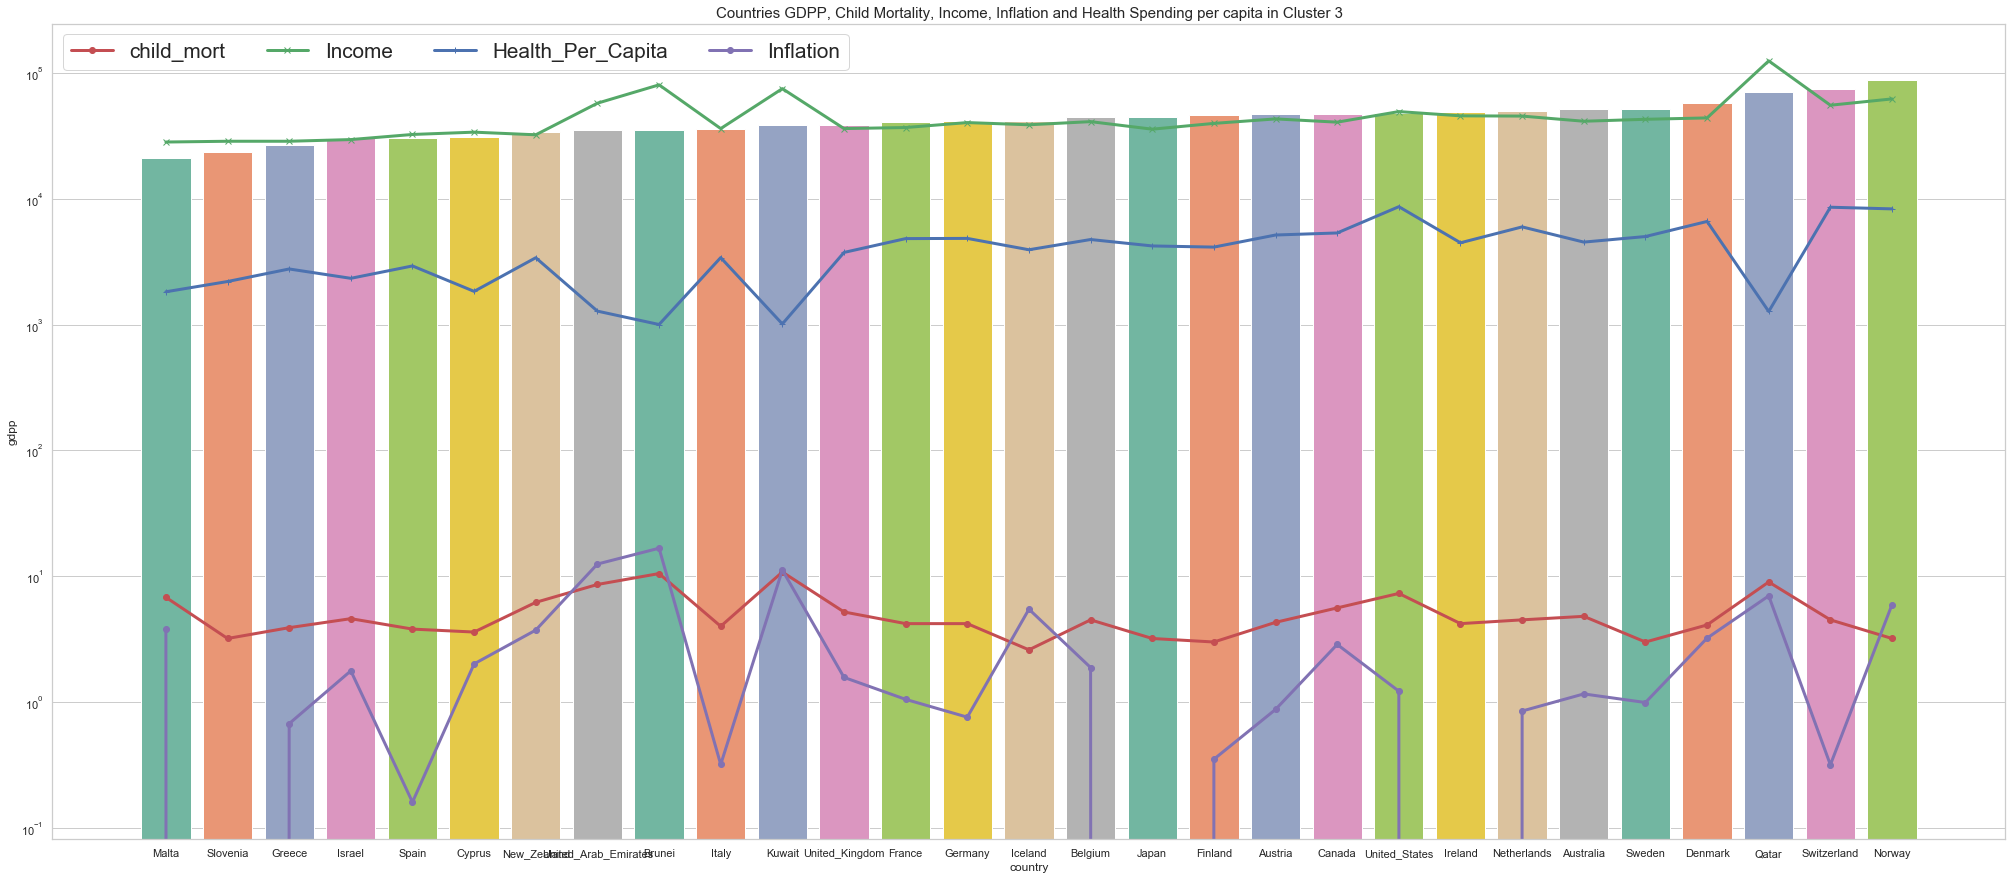

In [136]:
# Plot the features which contribute to 95% of the variance across the cluster
plt.figure(figsize=(35,15))
sns.barplot(y='gdpp',x='country',data=dvlpd_c_df,palette='Set2',log=True)
plt.plot(dvlpd_c_df.country,dvlpd_c_df.child_mort,marker="o",linewidth=3, alpha=1,color="r",label="child_mort")
plt.plot(dvlpd_c_df.country,dvlpd_c_df.income,marker="x",linewidth=3, alpha=1,color="g",label="Income")
plt.plot(dvlpd_c_df.country,dvlpd_c_df.health_per_cap,marker="+",linewidth=3, alpha=1,color="b",label="Health_Per_Capita")
plt.plot(dvlpd_c_df.country,dvlpd_c_df.inflation,marker="o",linewidth=3, alpha=1,color="m",label="Inflation")
plt.legend(loc=2, ncol=4,fontsize="xx-large")
plt.title("Countries GDPP, Child Mortality, Income, Inflation and Health Spending per capita in Cluster 3", fontsize=15 )
plt.show()

In [137]:
dvlpd_c_df.describe()

child_mort         income  inflation  life_expec  total_fer  \
count   29.000000      29.000000  29.000000   29.000000  29.000000   
mean     5.082759   45800.000000   2.837690   80.403448   1.813793   
std      2.206171   19896.607751   4.326794    1.460549   0.361084   
min      2.600000   28300.000000  -3.220000   76.500000   1.360000   
25%      3.800000   35800.000000   0.673000   79.900000   1.480000   
50%      4.300000   40700.000000   1.220000   80.400000   1.870000   
75%      5.600000   45700.000000   3.730000   81.400000   1.980000   
max     10.800000  125000.000000  16.700000   82.800000   3.030000   

               gdpp  exports_per_cap  health_per_cap  imports_per_cap  \
count     29.000000        29.000000       29.000000         29.00000   
mean   44017.241379     21511.096552     4084.970000      18129.90000   
std    14827.365361     12825.599109     2157.289732       9915.19634   
min    21100.000000      5944.900000     1002.520000       6052.00000   
25%    35000.000000     10710.000000     2334.780000      10067.40000   
50%    41900.000000     17879.400000     4134.900000      15507.80000   
75%    48700.000000     29290.000000     5017.230000      22418.20000   
max    87800.000000     50161.000000     8663.600000      42125.50000   

       M2_K_M_Lbls  
count         29.0  
mean           2.0  
std            0.0  
min            2.0  
25%            2.0  
50%            2.0  
75%            2.0  
max            2.0

__Cluster 2 - High Socio-Economic Countries - Inferences__
  *  Across this cluster,
     * 1) GDPP ranges from 21100 to 87800 and with average gdpp of 22017.
     * 2) Child Mortality ranges from 2 to 10 and with  average child mortality of 5.
     * 3) Income ranges from 28300 to 125000 and with  average income of 45800.
     * 4) Inflation ranges from -3 to 16 and with  average inflation of 2.
     * 5) Health Per Capita ranges from 1002 to 8663 and with average health per capita of 8663.
  * This segment is represented by close to 20% of the total countries. These are developed countries or in otherwards have good socio economic and health conditions.
  * As we can see all the countries are nicely clusterd and we could clearly see that GDPP and Income has very low variance and standard deviation is just 2.
  * Except inflation, Child Mortality and Health spending is uniform across these countries.

#### Cluster with Label 3

In [138]:
# create a df with cluster 0 and explore the df
mdvlp_c_df = c_df[c_df.M2_K_M_Lbls==3]
mdvlp_c_df = mdvlp_c_df.sort_values(by="gdpp",ascending=True)
mdvlp_c_df

country  child_mort  income  inflation  life_expec  total_fer    gdpp  \
133   Singapore         2.8   72100     -0.046        82.7       1.15   46600   
91   Luxembourg         2.8   91700      3.620        81.3       1.63  105000   

     exports_per_cap  health_per_cap  imports_per_cap  M2_K_M_Lbls  
133          93200.0         1845.36          81084.0            3  
91          183750.0         8158.50         149100.0            3

In [139]:
# Explore the cluster with the primary features based on which clusters are formed
mdvlp_c_df[pc_cols_2].describe()

gdpp  child_mort  inflation  health_per_cap        income  \
count       2.000000         2.0   2.000000        2.000000      2.000000   
mean    75800.000000         2.8   1.787000     5001.930000  81900.000000   
std     41295.036021         0.0   2.592253     4464.064105  13859.292911   
min     46600.000000         2.8  -0.046000     1845.360000  72100.000000   
25%     61200.000000         2.8   0.870500     3423.645000  77000.000000   
50%     75800.000000         2.8   1.787000     5001.930000  81900.000000   
75%     90400.000000         2.8   2.703500     6580.215000  86800.000000   
max    105000.000000         2.8   3.620000     8158.500000  91700.000000   

       M2_K_M_Lbls  
count          2.0  
mean           3.0  
std            0.0  
min            3.0  
25%            3.0  
50%            3.0  
75%            3.0  
max            3.0

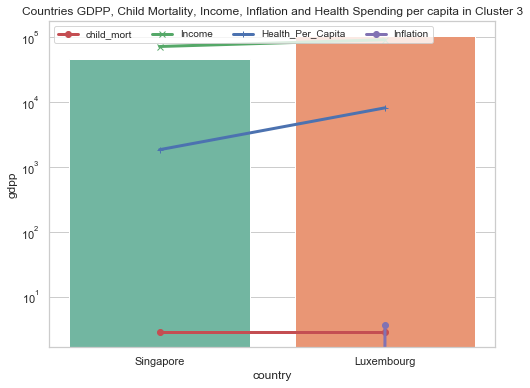

In [140]:
# Plot the features which contribute to 95% of the variance across the cluster
plt.figure(figsize=(8,6))
sns.barplot(y='gdpp',x='country',data=mdvlp_c_df,palette='Set2',log=True)
plt.plot(mdvlp_c_df.country,mdvlp_c_df.child_mort,marker="o",linewidth=3, alpha=1,color="r",label="child_mort")
plt.plot(mdvlp_c_df.country,mdvlp_c_df.income,marker="x",linewidth=3, alpha=1,color="g",label="Income")
plt.plot(mdvlp_c_df.country,mdvlp_c_df.health_per_cap,marker="+",linewidth=3, alpha=1,color="b",label="Health_Per_Capita")
plt.plot(mdvlp_c_df.country,mdvlp_c_df.inflation,marker="o",linewidth=3, alpha=1,color="m",label="Inflation")
plt.legend(loc=2, ncol=4,fontsize="small")
plt.title("Countries GDPP, Child Mortality, Income, Inflation and Health Spending per capita in Cluster 3", fontsize=12 )
plt.show()

__Cluster 3 - Very High Socio-Economic Countries - Inferences__
  *  Across this cluster, there are only 2 countries Luxembourg and Singapore.
     * 1) GDPP ranges from 21100 to 87800 and with average gdpp of 22017.
     * 2) Child Mortality ranges from 2 to 10 and with  average child mortality of 5.
     * 3) Income ranges from 28300 to 125000 and with  average income of 45800.
     * 4) Inflation ranges from -3 to 16 and with  average inflation of 2.
     * 5) Health Per Capita ranges from 1002 to 8663 and with average health per capita of 8663.
  * This segment is represented by only only 2 countries Luxembourg and Singapore. These are most exceptional countries or in otherwards have very high socio economic and health conditions.
  * As we can see all the countries are nicely clusterd and we could clearly see that GDPP and Income has very low child mortality.
  * __Our model has clearly differentiated these countries which have highest gdpp, exports_per_capita, imports_per_capita and income. In the initial outlier analysis we have seen that Singapore and Luxembourg were outliers among several features. Hence the model works nicely without removal of the outliers.__

## __Identification of the Countries which are in dire need of aid__

* Afrer the individual cluster analysis, we have seen that Cluster with Label 1 has the countries having very low socio economic conditions. 
  - In this section, we try to identify 5 to 10 countries which are in dire need of aid.
  - I will try to explore detailed analysis of bkwd_c_df, to narrow down the countries.
  - The most important features to decide on the aid would low income, low gdpp, low health spending and high child mortality,  low life expectancy and high inflation.

In [141]:
# list of countries in bkwd_c_df
print(list(bkwd_c_df.country))

['Burundi', 'Liberia', 'Congo_Dem_Rep', 'Niger', 'Sierra_Leone', 'Madagascar', 'Mozambique', 'Central_African_Republic', 'Malawi', 'Eritrea', 'Togo', 'Guinea_Bissau', 'Afghanistan', 'Gambia', 'Rwanda', 'Burkina_Faso', 'Uganda', 'Guinea', 'Haiti', 'Tanzania', 'Mali', 'Benin', 'Comoros', 'Chad', 'Kenya', 'Senegal', 'Pakistan', 'Lao', 'Lesotho', 'Mauritania', 'Cote_d_Ivoire', 'Solomon_Islands', 'Yemen', 'Cameroon', 'Ghana', 'Zambia', 'Sudan', 'Kiribati', 'Nigeria', 'Congo_Rep', 'Angola', 'Timor_Leste', 'Iraq', 'Namibia', 'Botswana', 'South_Africa', 'Gabon', 'Equatorial_Guinea']


In [142]:
# explore in bkwd_c_df
bkwd_c_df.describe()

child_mort        income   inflation  life_expec  total_fer  \
count   48.000000     48.000000   48.000000   48.000000  48.000000   
mean    91.610417   3897.354167   11.911146   59.239583   4.992083   
std     34.319855   5590.168621   15.362485    6.384914   1.036192   
min     28.100000    609.000000    0.885000   32.100000   2.590000   
25%     63.675000   1390.000000    4.080000   56.725000   4.475000   
50%     89.750000   1860.000000    8.855000   59.800000   5.055000   
75%    111.000000   3522.500000   16.600000   62.825000   5.597500   
max    208.000000  33700.000000  104.000000   71.100000   7.490000   

               gdpp  exports_per_cap  health_per_cap  imports_per_cap  \
count     48.000000        48.000000       48.000000        48.000000   
mean    1909.208333       879.063521      114.821765       827.028771   
std     2925.911009      2252.474004      165.518331      1540.981910   
min      231.000000        20.605200       12.821200        90.552000   
25%      551.500000       102.873750       34.005875       193.319500   
50%      932.000000       196.260000       51.613500       339.306000   
75%     1465.000000       552.522500       95.303250       801.000000   
max    17100.000000     14671.800000      766.080000     10071.900000   

       M2_K_M_Lbls  
count         48.0  
mean           1.0  
std            0.0  
min            1.0  
25%            1.0  
50%            1.0  
75%            1.0  
max            1.0

### Selection of the countries based on Health conditions and Economic Conditions

__Health Criteria - Low child_mortality and Low life expectancy describe the poor health conditions of the countires__
- Countries having Child mortality above 65 or 6.5%. I selected 65 as cutoff the reason being the cluster with average socio economic and health conditions have highest child mortaltiy as 64 and hence beyong this might not be good criteria.
- Life Expectancy anything below 60. This cluster has life expectancy ranging from 32 to 71 with mean of 59. Hence I have selected 60 as the criteria.

__Economic Criteria - Low GDPP and Low Income describe the poor economic conditions of the countries__
- Countries having Income below 2500 and gdpp above below can be considered as low economic conditions.

In [143]:
# create a df with above criteria and inspect the values
help_df = bkwd_c_df[(bkwd_c_df.child_mort > 65) & (bkwd_c_df.life_expec < 60) & (bkwd_c_df.income < 2500) & (bkwd_c_df.gdpp < 1500)]
help_df.describe()

child_mort       income  inflation  life_expec  total_fer         gdpp  \
count   18.000000    18.000000  18.000000   18.000000  18.000000    18.000000   
mean   116.677778  1354.611111   8.406111   54.511111   5.548333   565.611111   
std     33.710158   490.705271   5.598598    6.675582   1.055023   220.351361   
min     71.900000   609.000000   1.180000   32.100000   3.300000   231.000000   
25%     91.275000   946.000000   4.205000   54.625000   5.202500   425.750000   
50%    111.500000  1305.000000   7.225000   56.650000   5.495000   550.000000   
75%    133.500000  1592.500000  11.725000   57.975000   6.232500   658.500000   
max    208.000000  2380.000000  20.800000   59.500000   7.490000  1170.000000   

       exports_per_cap  health_per_cap  imports_per_cap  M2_K_M_Lbls  
count        18.000000       18.000000        18.000000         18.0  
mean        139.886678       40.945678       268.359333          1.0  
std         106.532398       24.663970       244.155421          0.0  
min          20.605200       17.750800        90.552000          1.0  
25%          78.317750       27.659025       166.790500          1.0  
50%         107.526000       38.043500       193.061000          1.0  
75%         155.386500       44.855700       271.845000          1.0  
max         460.980000      129.870000      1181.700000          1.0

__Inferences__
   * Child mortality of these countries is above 7%.
   * Income avg is around 1354.
   * Inflation is 8%.
   * Life Expectancy is below 59 and stands very low at 54.
   * GDPP average is 565.
   * Health Per Capita spending not beyond 129 and averages at 40.
   
__The above list of countries can be defined as the countries which are economically very poor and also poor with respect to Health conditions.__

In [144]:
# Print list of countries 
print(color.BOLD+color.RED+"List of countries can be defined as the countries which are economically very poor and also poor with respect to Health conditions"+color.END)
print(help_df.country.reset_index())

List of countries can be defined as the countries which are economically very poor and also poor with respect to Health conditions
    index                   country
0      26                   Burundi
1      37             Congo_Dem_Rep
2     112                     Niger
3     132              Sierra_Leone
4     106                Mozambique
5      31  Central_African_Republic
6      94                    Malawi
7     150                      Togo
8      64             Guinea_Bissau
9       0               Afghanistan
10     25              Burkina_Faso
11    155                    Uganda
12     63                    Guinea
13     66                     Haiti
14    147                  Tanzania
15     97                      Mali
16     32                      Chad
17     87                   Lesotho


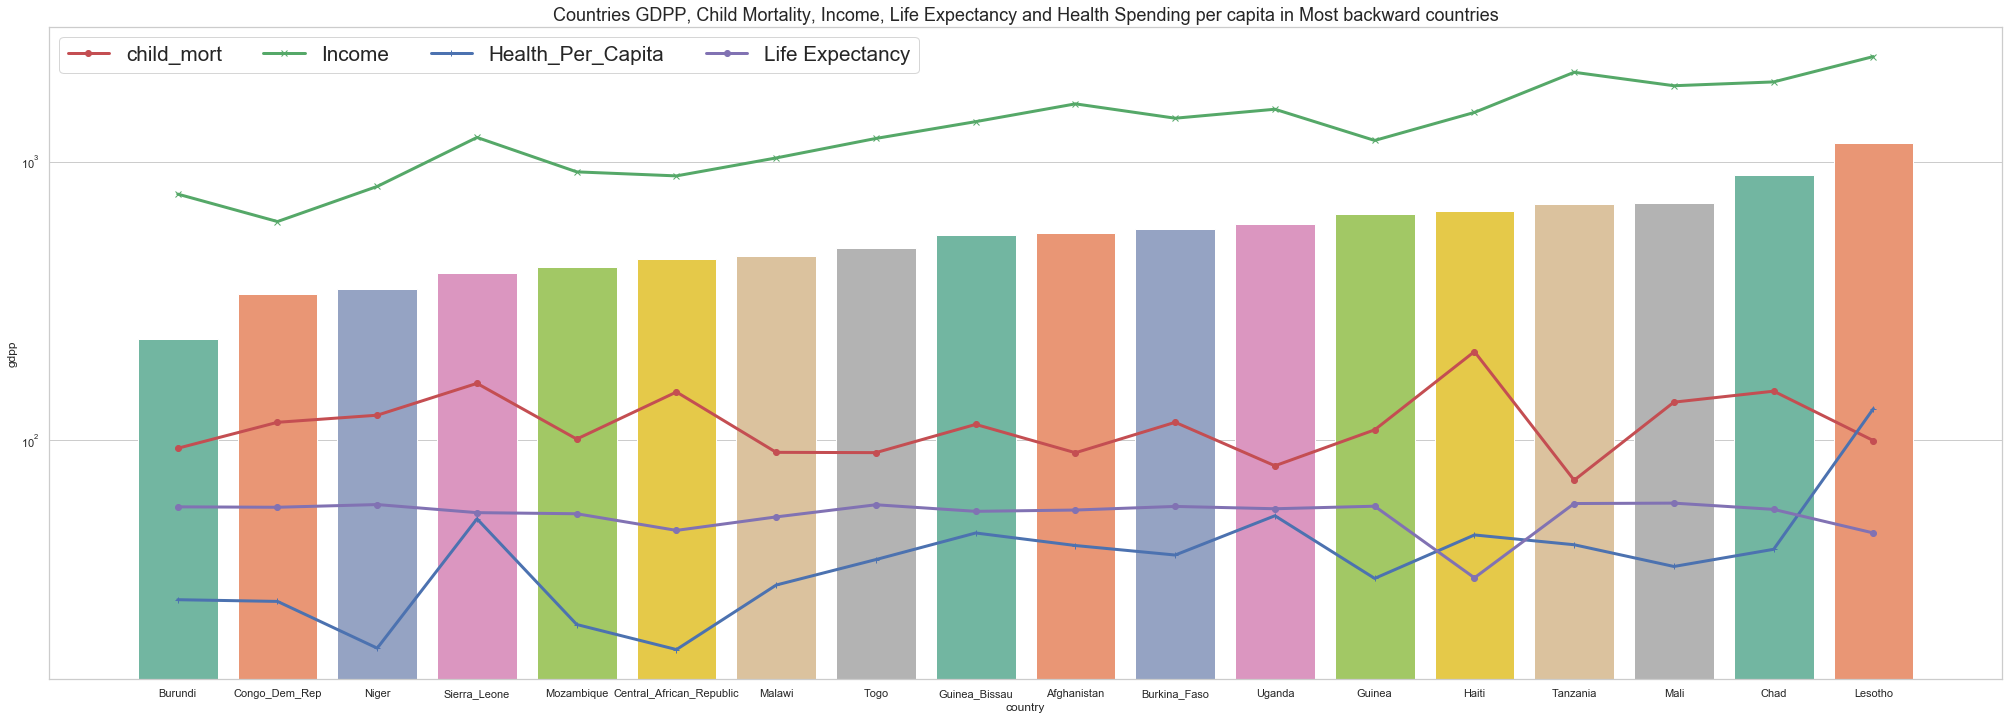

In [145]:
# Plot the features which contribute to 95% of the variance across the cluster
plt.figure(figsize=(35,12))
sns.barplot(y='gdpp',x='country',data=help_df,palette='Set2',log=True)
plt.plot(help_df.country,help_df.child_mort,marker="o",linewidth=3, alpha=1,color="r",label="child_mort")
plt.plot(help_df.country,help_df.income,marker="x",linewidth=3, alpha=1,color="g",label="Income")
plt.plot(help_df.country,help_df.health_per_cap,marker="+",linewidth=3, alpha=1,color="b",label="Health_Per_Capita")
plt.plot(help_df.country,help_df.life_expec,marker="o",linewidth=3, alpha=1,color="m",label="Life Expectancy")
plt.legend(loc=2, ncol=4,fontsize="xx-large")
plt.title("Countries GDPP, Child Mortality, Income, Life Expectancy and Health Spending per capita in Most backward countries", fontsize=18 )
plt.show()

__Final Conclusions__

 - Basis
    * Economic Features GDPP, Income are negativley correlated with Child Mortality and Life Expectancy. In general poor GDPP and Income indicates high child mortality and low life expectancy.
    * I also have considered low per capita spending on health might be good metric to short list the countries as they might need to improve their health conditions.
    * So considering the above points, I propose list of following countries which are in dire need of Humanitarian help. 
   
__The 5 countries which are in need of of help are__
    * 1) Congo Dem Rep - Congo Dem Rep has very low GDPP (334), low income (609), high child mortality rate (11.6%), health per capita spending of 26 and life expectany is around 57 years.
    * 2) Central Africal Republic - Central Africal Republic has very low GDPP (446), low income (888), high child mortality rate (14.9%), health per capita spending of 17 and life expectany is around 45 years.
    * 3) Niger - Niger has very low GDPP (348), low income (814), high child mortality rate (12.3%), health per capita spending of 17 and life expectany is around 57 years.
    * 4) Burundi - Burundi has very low GDPP (231), low income (764), high child mortality rate (9.3%), health per capita spending of 17 and life expectany is around 57 years.
    * 5) Haiti - Haiti has very low GDPP (662), low income (1500), high child mortality rate (20.8%), health per capita spending of 45 and life expectany is around 32 years.

__The next 13 Countries which are in need of support are__
    * 6) Sierra_Leone
    * 7) Mozambique
    * 8) Malawi
    * 9) Togo
    * 10) Guinea_Bissau
    * 11) Afghanistan
    * 12) Burkina_Faso
    * 13) Uganda
    * 14) Guinea
    * 15) Tanzania
    * 16) Mali
    * 17) Chad
    * 18) Lesotho 

In [182]:
# 2 Models are created and hence 2 copies of df to perform the analysis
m3_df = bkwd_c_df.copy()

In [183]:
m3_df.reset_index(inplace=True,drop=True)
m3_df

country  child_mort  income  inflation  life_expec  \
0                    Burundi        93.6     764     12.300        57.7   
1                    Liberia        89.3     700      5.470        60.8   
2              Congo_Dem_Rep       116.0     609     20.800        57.5   
3                      Niger       123.0     814      2.550        58.8   
4               Sierra_Leone       160.0    1220     17.200        55.0   
5                 Madagascar        62.2    1390      8.790        60.8   
6                 Mozambique       101.0     918      7.640        54.5   
7   Central_African_Republic       149.0     888      2.010        47.5   
8                     Malawi        90.5    1030     12.100        53.1   
9                    Eritrea        55.2    1420     11.600        61.7   
10                      Togo        90.3    1210      1.180        58.7   
11             Guinea_Bissau       114.0    1390      2.970        55.6   
12               Afghanistan        90.2    1610      9.440        56.2   
13                    Gambia        80.3    1660      4.300        65.5   
14                    Rwanda        63.6    1350      2.610        64.6   
15              Burkina_Faso       116.0    1430      6.810        57.9   
16                    Uganda        81.0    1540     10.600        56.8   
17                    Guinea       109.0    1190     16.100        58.0   
18                     Haiti       208.0    1500      5.450        32.1   
19                  Tanzania        71.9    2090      9.250        59.3   
20                      Mali       137.0    1870      4.370        59.5   
21                     Benin       111.0    1820      0.885        61.8   
22                   Comoros        88.2    1410      3.870        65.9   
23                      Chad       150.0    1930      6.390        56.5   
24                     Kenya        62.2    2480      2.090        62.8   
25                   Senegal        66.8    2180      1.850        64.0   
26                  Pakistan        92.1    4280     10.900        65.3   
27                       Lao        78.9    3980      9.200        63.8   
28                   Lesotho        99.7    2380      4.150        46.5   
29                Mauritania        97.4    3320     18.900        68.2   
30             Cote_d_Ivoire       111.0    2690      5.390        56.3   
31           Solomon_Islands        28.1    1780      6.810        61.7   
32                     Yemen        56.3    4480     23.600        67.5   
33                  Cameroon       108.0    2660      1.910        57.3   
34                     Ghana        74.7    3060     16.600        62.2   
35                    Zambia        83.1    3280     14.000        52.0   
36                     Sudan        76.7    3370     19.600        66.3   
37                  Kiribati        62.7    1730      1.520        60.7   
38                   Nigeria       130.0    5150    104.000        60.5   
39                 Congo_Rep        63.9    5190     20.700        60.4   
40                    Angola       119.0    5900     22.400        60.1   
41               Timor_Leste        62.6    1850     26.500        71.1   
42                      Iraq        36.9   12700     16.600        67.2   
43                   Namibia        56.0    8460      3.560        58.6   
44                  Botswana        52.5   13300      8.920        57.1   
45              South_Africa        53.7   12000      6.350        54.3   
46                     Gabon        63.7   15400     16.600        62.9   
47         Equatorial_Guinea       111.0   33700     24.900        60.9   

    total_fer   gdpp  exports_per_cap  health_per_cap  imports_per_cap  \
0        6.26    231          20.6052         26.7960           90.552   
1        5.02    327          62.4570         38.5860          302.802   
2        6.54    334         137.2740         26.4194          165.664   
3        7.49    348          77.2560         17.

In [184]:
m3_df.shape

(48, 11)

In [185]:
# This can be achieved using sklearn MinMaxScaler
# 1. Initiate an object
m3_scaler = StandardScaler()

# 2. Fit and transform on data
m3_df[scl_li] = m3_scaler.fit_transform(m3_df[scl_li])
display(m3_df.head())

country  child_mort    income  inflation  life_expec  total_fer  \
0        Burundi    0.058585 -0.566443   0.025580   -0.243680   1.236580   
1        Liberia   -0.068033 -0.578013  -0.423715    0.246977   0.027227   
2  Congo_Dem_Rep    0.718176 -0.594464   0.584731   -0.275335   1.509660   
3          Niger    0.924298 -0.557404  -0.615799   -0.069576   2.436181   
4   Sierra_Leone    2.013799 -0.484008   0.347914   -0.671027   0.202778   

       gdpp  exports_per_cap  health_per_cap  imports_per_cap  M2_K_M_Lbls  
0 -0.579637        -0.385151       -0.537447        -0.482985            1  
1 -0.546480        -0.366374       -0.465462        -0.343790            1  
2 -0.544062        -0.332807       -0.539746        -0.433726            1  
3 -0.539227        -0.359734       -0.591415        -0.430313            1  
4 -0.521612        -0.364321       -0.381920        -0.452094            1

## Extended - Feature Selection using PCA & Clustering__

__PCA & Clustering Steps__
* 1) Dimensonality Reduction using PCA
* 2) Clustering the data using hierarchical Modelling (Single, Complete and Ward)
* 3) Clustering the data using K-Means

### __Extended - Dimensionality Reduction using PCA__

#### Create an insance and explore the components

In [186]:
# Target variable is removed from predictor variables
my3_train = m3_df.pop("country")
MX3_train = m3_df.copy()

display(my3_train.head())
display(MX3_train.head())

0          Burundi
1          Liberia
2    Congo_Dem_Rep
3            Niger
4     Sierra_Leone
Name: country, dtype: object

child_mort    income  inflation  life_expec  total_fer      gdpp  \
0    0.058585 -0.566443   0.025580   -0.243680   1.236580 -0.579637   
1   -0.068033 -0.578013  -0.423715    0.246977   0.027227 -0.546480   
2    0.718176 -0.594464   0.584731   -0.275335   1.509660 -0.544062   
3    0.924298 -0.557404  -0.615799   -0.069576   2.436181 -0.539227   
4    2.013799 -0.484008   0.347914   -0.671027   0.202778 -0.521612   

   exports_per_cap  health_per_cap  imports_per_cap  M2_K_M_Lbls  
0        -0.385151       -0.537447        -0.482985            1  
1        -0.366374       -0.465462        -0.343790            1  
2        -0.332807       -0.539746        -0.433726            1  
3        -0.359734       -0.591415        -0.430313            1  
4        -0.364321       -0.381920        -0.452094            1

In [187]:
# Create an instance of PCA
pca_m3 = PCA(random_state=rndm_stat)

# finding the covariance matrix,  doing an eigendecomposition of it to obtain the eigenvectors which are Principal Components
pca_m3.fit(MX3_train)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=1,
    svd_solver='auto', tol=0.0, whiten=False)

In [188]:
# Inspect the principal components created by PCA
print("Print Principal Components",pca_m3.components_.shape)
pca_m3.components_

Print Principal Components (10, 10)


array([[-0.12009949,  0.44735756,  0.0858005 ,  0.06876214, -0.15160959,
         0.45015988,  0.42811907,  0.41971126,  0.43391762,  0.        ],
       [ 0.71956349,  0.05663905,  0.10063518, -0.60969121,  0.23288857,
         0.05842586,  0.15546597, -0.03510882,  0.11881337, -0.        ],
       [ 0.06606464,  0.03227521,  0.6246954 ,  0.44900044,  0.62103118,
         0.03083296,  0.07773443, -0.10027932, -0.00436568, -0.        ],
       [-0.02280242, -0.02163729,  0.75250331, -0.2088683 , -0.56182439,
        -0.03513498, -0.19702238,  0.09446396, -0.1565321 ,  0.        ],
       [-0.46111438, -0.11451769,  0.04873845, -0.47596474,  0.45986079,
         0.05285202, -0.24094626,  0.51345933, -0.09685295,  0.        ],
       [ 0.4967448 , -0.00613379, -0.13669806,  0.37685897, -0.04719685,
         0.1077061 , -0.38427402,  0.6141467 , -0.23200668,  0.        ],
       [-0.05489564,  0.50071436, -0.06732896, -0.08910562,  0.04723614,
         0.31769001,  0.1202632 , -0.17667177

#### Explore the variance and select the no of PC's

In [189]:
# Explore the variance explained by PC in each direction
print("Variance of each PC in each of its direction\n",pca_m3.explained_variance_ratio_)

# Create a cumulative sum of variance
m3_varcum = np.cumsum(pca_m3.explained_variance_ratio_)

Variance of each PC in each of its direction
 [5.33936828e-01 1.78154821e-01 1.47837821e-01 8.34055555e-02
 2.72456469e-02 1.88849464e-02 7.94847847e-03 2.22924932e-03
 3.56653355e-04 0.00000000e+00]


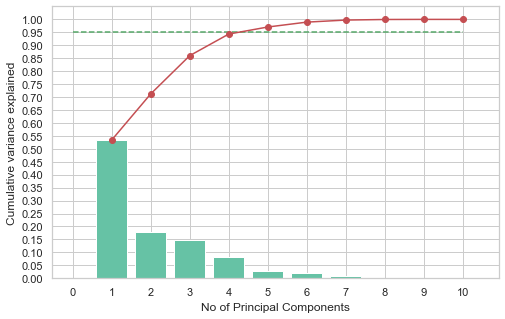

In [190]:
# Explore the variance using Scree plots to select the no of PC's
# Plot Scree plots
plt.figure(figsize=[8,5])
plt.bar(range(1,len(pca_m3.explained_variance_ratio_)+1),pca_m3.explained_variance_ratio_)
plt.plot(range(1,len(m3_varcum)+1),m3_varcum,c="r",marker='o')
plt.xlabel("No of Principal Components")
plt.ylabel("Cumulative variance explained")
plt.yticks(np.arange(0,10.5,0.5)/10)
plt.xticks(np.arange(0,11,1))
plt.hlines(y=0.95,xmin=0,xmax=10,colors="g",linestyles="--")
plt.show()

__Inferences__


 1) From Spree plot we observe that 5 PC's contribute to 95% of the variance data. I take the 95% as cutoff and hence consider to select 5 PC's.

#### Fit and Transform using the PC's using the no of components selected

In [191]:
# Fit the model and apply the dimensionality reduction to 3 PC's on the data
pca_m3_3 = PCA(n_components=4,random_state=rndm_stat)

In [192]:
# Create a DF with 3 Principal Components which explains variance of 90%

# create a list of PC's with respective names
pc_li = ["PC1","PC2","PC3","PC4"]

# create a df with PC's
pca_m33 = pd.DataFrame(pca_m3_3.fit_transform(MX3_train),columns=pc_li)

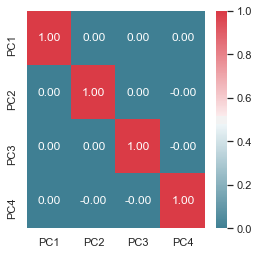

In [193]:
# Check the correlation across  PC's
plt.figure(figsize=(4,4))
colormap =  colormap = sns.diverging_palette(220, 10, as_cmap=True)
ax = sns.heatmap(round(pca_m33.corr(),2), cmap=colormap, annot=True, fmt=".2f")
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

* The new features do not have correlation and it looks good

In [194]:
# add country label to df with 4 PC's
pca_m33 = pd.concat([pca_m33,my3_train],axis=1)
display(pca_m33)

PC1       PC2       PC3       PC4                   country
0   -1.323445  0.316943  0.668302 -0.492592                   Burundi
1   -1.021299 -0.381964 -0.157193 -0.270442                   Liberia
2   -1.351967  0.945290  1.220832 -0.252565             Congo_Dem_Rep
3   -1.619026  1.063533  1.156686 -1.725268                     Niger
4   -1.252663  1.785578  0.155269  0.377386              Sierra_Leone
5   -0.862222 -1.022760 -0.307052  0.134464                Madagascar
6   -1.227570  0.614924 -0.150659 -0.265062                Mozambique
7   -1.498905  2.180396 -0.998037 -0.140602  Central_African_Republic
8   -1.121437  0.495931 -0.243652  0.155808                    Malawi
9   -0.841156 -1.245443 -0.135194  0.254279                   Eritrea
10  -0.967572 -0.204335 -0.561445 -0.345973                      Togo
11  -1.101232  0.635996 -0.560746 -0.246484             Guinea_Bissau
12  -1.070044  0.297411  0.170925 -0.358958               Afghanistan
13  -0.953890 -0.861165  0.543967 -0.866042                    Gambia
14  -0.725044 -1.431033 -0.369266 -0.221207                    Rwanda
15  -1.195900  0.671001  0.267400 -0.588308              Burkina_Faso
16  -1.055706  0.121988  0.437936 -0.485592                    Uganda
17  -1.017027  0.469173  0.327870  0.140628                    Guinea
18  -1.325353  4.544547 -2.985461  1.504294                     Haiti
19  -0.850242 -0.469591  0.118603 -0.250588                  Tanzania
20  -1.287683  1.117451  0.741232 -1.166585                      Mali
21  -1.008230  0.056573 -0.006503 -0.753564                     Benin
22  -0.775530 -0.940434 -0.012964 -0.395379                   Comoros
23  -1.240090  1.730937  0.665108 -1.026944                      Chad
24  -0.531631 -1.278283 -0.582928 -0.154453                     Kenya
25  -0.598413 -1.136686 -0.087092 -0.592578                   Senegal
26  -0.432226 -0.934710 -0.276351  0.460563                  Pakistan
27  -0.091659 -1.200538 -0.912197  0.774329                       Lao
28  -0.139329  0.929860 -2.274954  0.982828                   Lesotho
29  -0.275657 -0.731536  0.945732  0.061067                Mauritania
30  -0.647101  0.657401 -0.262782 -0.352965             Cote_d_Ivoire
31   0.070721 -1.820681 -0.639133  0.132929           Solomon_Islands
32  -0.038489 -1.600360  0.813506  0.565236                     Yemen
33  -0.715895  0.402546 -0.449129 -0.421333                  Cameroon
34  -0.213491 -0.839611 -0.066548  0.591729                     Ghana
35  -0.462917  0.562646 -0.199616  0.184715                    Zambia
36  -0.250138 -1.066895  0.707364  0.324320                     Sudan
37   0.099248 -1.145258 -1.151948  0.155349                  Kiribati
38   0.271959  1.461558  4.462994  4.087268                   Nigeria
39   0.748838 -0.456660  0.458402  0.198510                 Congo_Rep
40   0.625702  1.033912  1.334567 -0.390521                    Angola
41   0.671206 -1.456318  1.982689 -0.165254               Timor_Leste
42   2.533776 -1.791118  0.336958  0.176965                      Iraq
43   2.733045 -0.709418 -1.335441  0.093417                   Namibia
44   3.972260 -0.703035 -1.721603  0.836775                  Botswana
45   3.831359 -0.657652 -2.293309  1.215729              South_Africa
46   3.820439 -0.550684  0.011903  0.158555                     Gabon
47  11.711626  2.540575  1.212958 -1.637885         Equatorial_Guinea

#### Visualize the PC's in eigen space

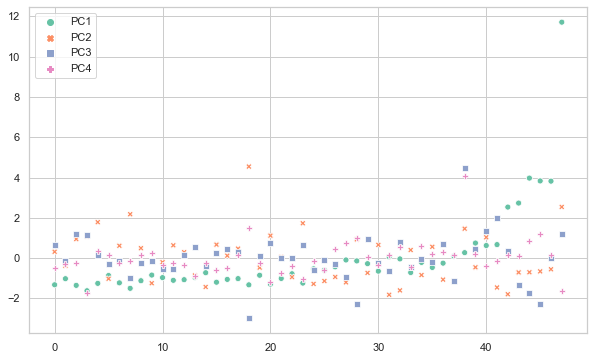

In [195]:
plt.figure(1,figsize=(10,6))
sns.scatterplot(data=pca_m33[pc_li])
plt.show()

#### Map the PC's in eigen space to original column names

In [196]:
# Map the PC's in eigen space to original columns

# get number of component
n_pcs= pca_m3_3.n_components_ 

# get the index of the most important feature on EACH component
mst_imp = [np.abs(pca_m3_3.components_[i]).argmax() for i in range(n_pcs)]

# Original columns
fr_cols = MX3_train.columns

# get the most important feature names
pc_cols_3 = [fr_cols[mst_imp[i]] for i in range(n_pcs)]

In [197]:
# Print the top PC's contributing the maximum variance
print(color.BOLD+"Important Column Names \n"+color.END,pc_cols_3)

Important Column Names 
 ['gdpp', 'child_mort', 'inflation', 'inflation']


### __Model 2 - Clustering the data__

#### Hopkins Check to proceed with Clustering

In [198]:
#Use the Hopkins Statistic function by passing the above dataframe as a paramter
hopkins(pca_m33[pc_li])

0.9216822508744575

* Hopkins score indicates cluster tendency. Score of .93 is good score and its nice to proceed with clustering mechanism

### Outliers detection in the new df with PC's as columns

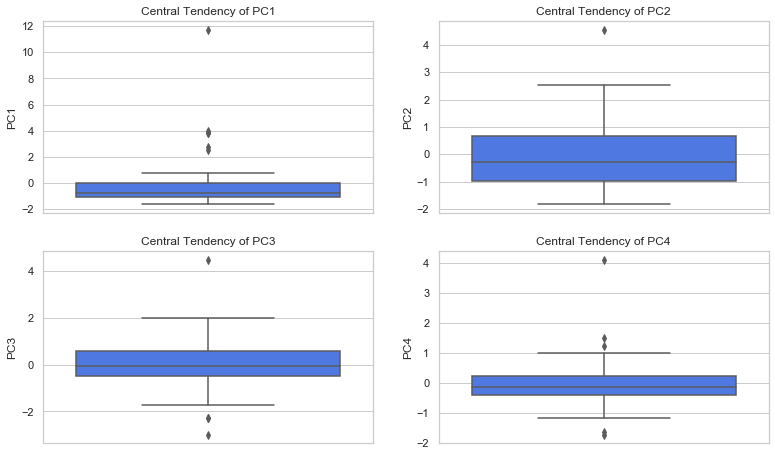

In [199]:
# m_box_plt is local function which takes a df, rows, columns of subplot and name of columns as an argument and 
# plots box plots
# Part-1
m_box_plt(pca_m33,3,2,*list(pc_li))

In [200]:
# Inspect the columns more in detail for outliers
pca_m33.describe(q_li)

PC1           PC2           PC3           PC4
count  4.800000e+01  4.800000e+01  4.800000e+01  4.800000e+01
mean   1.110223e-16  4.625929e-17 -8.326673e-17 -4.625929e-18
std    2.215327e+00  1.279652e+00  1.165697e+00  8.755691e-01
min   -1.619026e+00 -1.820681e+00 -2.985461e+00 -1.725268e+00
1%    -1.562569e+00 -1.806787e+00 -2.660149e+00 -1.684198e+00
5%    -1.342652e+00 -1.549945e+00 -2.081281e+00 -1.117710e+00
25%   -1.077841e+00 -9.610152e-01 -4.770331e-01 -3.917352e-01
50%   -7.204694e-01 -2.931495e-01 -3.975604e-02 -1.475279e-01
75%   -1.118669e-02  6.608008e-01  5.742525e-01  2.124525e-01
95%    3.827537e+00  2.042209e+00  1.294759e+00  1.134214e+00
99%    8.074124e+00  3.602680e+00  3.297251e+00  2.873270e+00
max    1.171163e+01  4.544547e+00  4.462994e+00  4.087268e+00

* The outliers in the original data set are transformed and the outliers still remain as outliers

In [201]:
pca_m33_df = pca_m33[pc_li]

### Clustering using Hirearchial Modeling

#### Hierarchial using Single Linkage Method

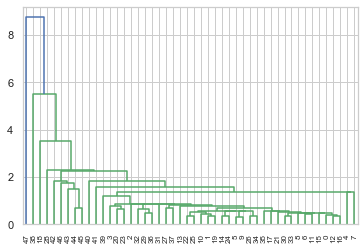

In [202]:
# Single linkage
sl = linkage(pca_m33_df,method="single",metric="euclidean")
dendrogram(sl)
plt.show()

* As we can see, at 4, we have 4 different clusters. Hence I choose to create the clusters with 4

##### Cut the Clusters & Derive Labels

In [203]:
# 4 Clusters
sl_cl_lbls = cut_tree(sl,n_clusters=4).reshape(-1,)

In [204]:
pca_m33["sl_cl_lbls"] = sl_cl_lbls
print("Number of Countries across each cluster\n",pca_m33["sl_cl_lbls"].value_counts())

Number of Countries across each cluster
 0    45
3     1
2     1
1     1
Name: sl_cl_lbls, dtype: int64


##### Visualize the first 2 Principal Components and Clustering

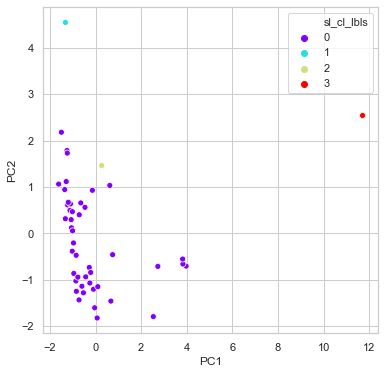

In [205]:
plt.figure(1,figsize=(6,6))
sns.scatterplot(x = pca_m33.PC1, y = pca_m33.PC2, hue=pca_m33.sl_cl_lbls, palette="rainbow")
plt.show()

* We could clearly see that with single linkage method, though 4 clusters have been formed, one single cluster has taken over most of the data points. This is not a good model to choose as majority of the data is in one single cluster

#### Hierarchial using Ward Linkage Method

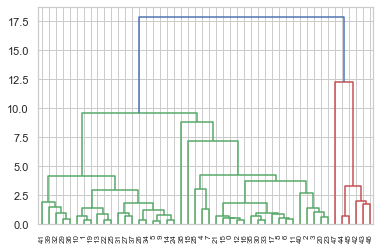

In [206]:
# Ward linkage
wrd = linkage(pca_m33_df,method="ward",metric="euclidean")
dendrogram(wrd)
plt.show()

* As we can see, at 15, we have 4 different clusters. Hence I choose to create the clusters with 4

##### Cut the Clusters & Derive Labels

In [207]:
# 4 Clusters
wrd_cl_lbls = cut_tree(wrd,n_clusters=4).reshape(-1,)

In [208]:
pca_m33["wrd_cl_lbls"] = wrd_cl_lbls
m3_df["wrd_cl_lbls"] = wrd_cl_lbls
bkwd_c_df["M3_wrd_cl_lbls"] = wrd_cl_lbls
print("Number of Countries across each cluster\n",pca_m33["wrd_cl_lbls"].value_counts())

Number of Countries across each cluster
 0    22
1    20
2     5
3     1
Name: wrd_cl_lbls, dtype: int64


##### Visualize the first 2 Principal Components and Clusters

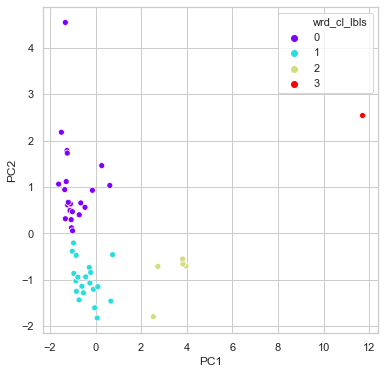

In [209]:
plt.figure(1,figsize=(6,6))
sns.scatterplot(x = pca_m33.PC1, y = pca_m33.PC2, hue=pca_m33.wrd_cl_lbls, palette="rainbow")
plt.show()

* We could clearly see that with ward linkage method, the 4 clusters are segregated and grouped as different clusters in 2 Dimensional wrt PC1 and PC2.

##### Visualize the first 3 Principal Components and Clusters

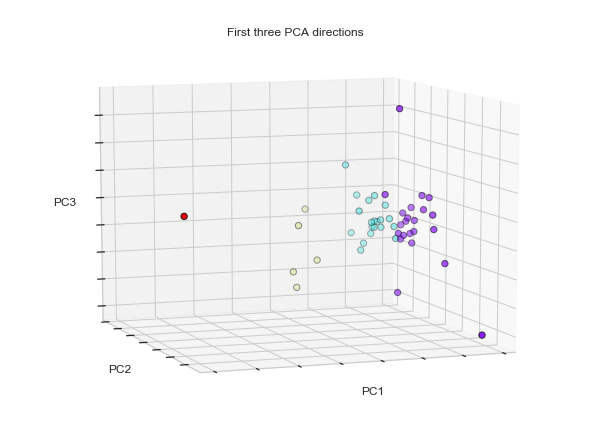

In [210]:
fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=10, azim=70)
ax.scatter(pca_m33['PC1'], pca_m33['PC2'], pca_m33['PC3'], c=np.array(pca_m33.wrd_cl_lbls),cmap=plt.cm.rainbow, edgecolor='k', s=40)
ax.set_title("First three PCA directions")
ax.set_xlabel("PC1")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("PC2")
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("PC3")
ax.w_zaxis.set_ticklabels([])

plt.show()

* We could clearly see that with ward linkage method, the 4 clusters are segregated and grouped as different clusters in 2 Dimensional wrt PC1 and PC2.

#### Hierarchial using Complete Linkage Method

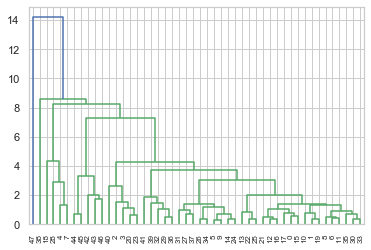

In [211]:
# Complete linkage
cmpl = linkage(pca_m33_df,method="complete",metric="euclidean")
dendrogram(cmpl)
plt.show()

* As we can see, at 10, we have 4 different clusters. Hence I choose to create the clusters with 4

##### Cut the Clusters & Derive Labels

In [212]:
# 4 Clusters
hr_cl_lbls = cut_tree(cmpl,n_clusters=4).reshape(-1,)

In [213]:
pca_m33["Hr_Lbls"] = hr_cl_lbls
m3_df["Hr_Lbls"] = hr_cl_lbls
bkwd_c_df["M3_Hr_Lbls"] = hr_cl_lbls
print("Number of Countries across each cluster\n",pca_m33["Hr_Lbls"].value_counts())

Number of Countries across each cluster
 0    42
1     4
3     1
2     1
Name: Hr_Lbls, dtype: int64


##### Visualize the first 3 Principal Components and Clustering

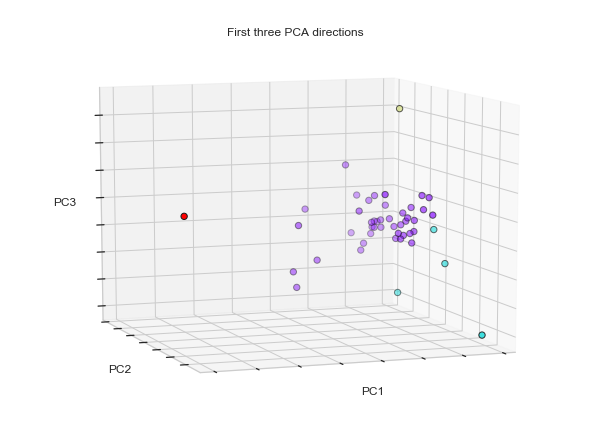

In [215]:
fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=10, azim=70)
ax.scatter(pca_m33['PC1'], pca_m33['PC2'], pca_m33['PC3'], c=np.array(pca_m33.Hr_Lbls),cmap=plt.cm.rainbow, edgecolor='k', s=40)
ax.set_title("First three PCA directions")
ax.set_xlabel("PC1")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("PC2")
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("PC3")
ax.w_zaxis.set_ticklabels([])

plt.show()

* We could clearly see that complete linkage method, the 4 clusters are segregated and grouped as different clusters in 2 Dimensional wrt PC1 and PC2.

##### Visualize the first 2 Principal Components and Clustering

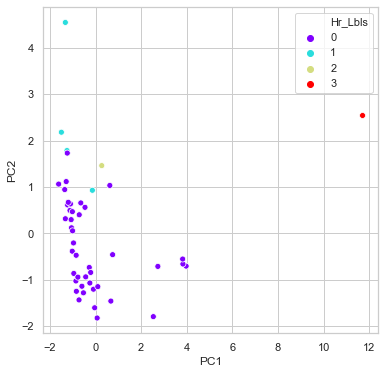

In [216]:
plt.figure(1,figsize=(6,6))
sns.scatterplot(x = pca_m33.PC1, y = pca_m33.PC2, hue=pca_m33.Hr_Lbls,markers=["o", "s", "D"], palette="rainbow")
plt.show()

* We could clearly see that complete linkage method, the 4 clusters are segregated and grouped as different clusters in 2 Dimensional wrt PC1 and PC2.

### Clustering using K-Means Modelling

__K-Means Steps__
* 1) k-means with some arbitrary k
* 2) Finding the Optimal Number of Clusters
     - Using SSD or Elbow Curve
     - Silhoute Analysis
* 3) Fit and derive the labels using the selected no fo clusters

In [217]:
# model and fit using KMeans
kmm = KMeans(n_clusters=3, max_iter=50,random_state=rndm_stat)

kmm.fit(pca_m33_df)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=50,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=1, tol=0.0001, verbose=0)

In [218]:
# Inspect the labels
kmm.labels_

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 2])

#### Finding the optimal no of clusters using SSD / Elbow-Curve

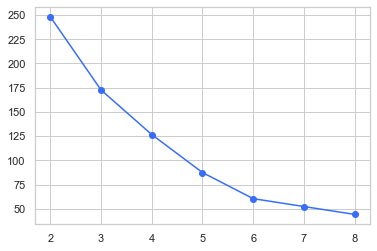

In [219]:
# elbow-curve / SSD (Sum of squred distances of samples to their closest cluster center)

ssd = []

for i in range(2,9):
    k_ssd = KMeans(n_clusters=i,max_iter=50,random_state=rndm_stat)
    k_ssd.fit(pca_m33_df)
    
    #append k-means inertia to array
    ssd.append(k_ssd.inertia_)

# plot the SSD's
plt.plot(range(2,9),ssd,marker="o")
plt.show()

#### Silhouette Analysis

$$\text{silhouette score}=\frac{p-q}{max(p,q)}$$

$p$ is the mean distance to the points in the nearest cluster that the data point is not a part of

$q$ is the mean intra-cluster distance to all the points in its own cluster.

* The value of the silhouette score range lies between -1 to 1. 

* A score closer to 1 indicates that the data point is very similar to other data points in the cluster, 

* A score closer to -1 indicates that the data point is not similar to the data points in its cluster.

In [220]:
# calculate Silhouette score

for i in range(2,9):
    
    # initialize k-means
    k_si = KMeans(n_clusters=i,max_iter=50,random_state=rndm_stat)
    k_si.fit(pca_m33_df)
    
    cls_labels = k_si.labels_
    
    # silhouette score
    si_scr = silhouette_score(pca_m33_df,cls_labels)
    print("For n_clusters={0} , Silhoutte Score is {1}".format(i,si_scr))

For n_clusters=2 , Silhoutte Score is 0.5742693820090603
For n_clusters=3 , Silhoutte Score is 0.5058543045954473
For n_clusters=4 , Silhoutte Score is 0.3197555408967874
For n_clusters=5 , Silhoutte Score is 0.3457626438232955
For n_clusters=6 , Silhoutte Score is 0.3575935919041459
For n_clusters=7 , Silhoutte Score is 0.35168601208050526
For n_clusters=8 , Silhoutte Score is 0.31594299605081694


K is decided based on 3 following metrics
* SSD / Elbow curve - 4 is optimal as elbow starts at 4
* Silhouette Analysis - 4 is optimal as Silhouette score is higher compared to 3.
* Business Decision - I choose 4 aswell as per both Elbow and Silhouette Analysis

In [221]:
# We start with no of clusters as 4

# model and fit using KMeans
kmm = KMeans(n_clusters=3, max_iter=50,random_state=rndm_stat)
kmm.fit(pca_m33_df)

# Inspect the labels
m33_km_cen = kmm.cluster_centers_
pca_m33["K_M_Lbls"] = kmm.labels_
m3_df["K_M_Lbls"] = kmm.labels_
bkwd_c_df["M3_K_M_Lbls"] = kmm.labels_

#### Visualize the first 3 Principal Components and Clustering

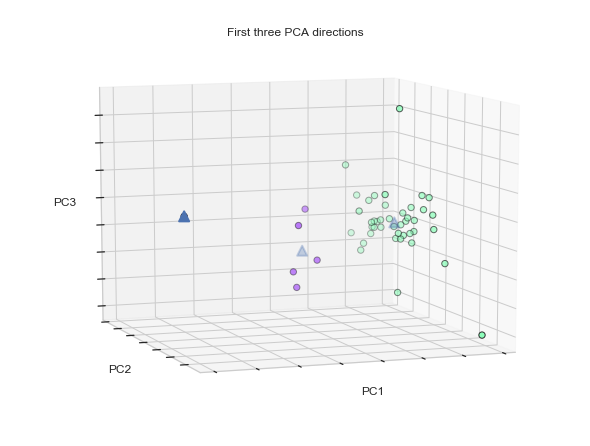

In [223]:
fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=10, azim=70)
ax.scatter(pca_m33['PC1'], pca_m33['PC2'], pca_m33['PC3'], c=np.array(pca_m33.K_M_Lbls),cmap=plt.cm.rainbow, edgecolor='k', s=40)
ax.scatter(m33_km_cen[:, 0], m33_km_cen[:, 1], m33_km_cen[:, 2],marker="^", s=100, linewidths=2,color='b', zorder=10)
ax.set_title("First three PCA directions")
ax.set_xlabel("PC1")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("PC2")
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("PC3")
ax.w_zaxis.set_ticklabels([])

plt.show()

* We could clearly see that K-Means clustering, the 4 clusters are segregated and grouped as different clusters in 2 Dimensional wrt PC1 and PC2.

#### Visualize the first 2 Principal Components and Clustering

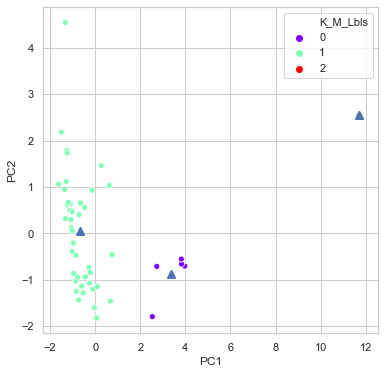

In [224]:
plt.figure(1,figsize=(6,6))
sns.scatterplot(x = pca_m33.PC1, y = pca_m33.PC2, hue=pca_m33.K_M_Lbls,markers=["o", "s", "D"], palette="rainbow")
plt.scatter(m33_km_cen[:, 0], m33_km_cen[:, 1], marker="^", s=50, linewidths=2,color='b', zorder=10)
ax.set_title("Clusters wrt 2 PC's")
plt.show()

### Visualize the Scattered Correlogram of Clusters across all the Principal Components

In [238]:
# update the pc_cols_2 with lables for plotting correlogram
pc_cols_3.append("M3_wrd_cl_lbls")
pc_cols_3.remove("M3_wrd_cl_Lbls")
pc_cols_3

['gdpp', 'child_mort', 'inflation', 'M3_wrd_cl_lbls']

In [237]:
bkwd_c_df.columns

Index(['country', 'child_mort', 'income', 'inflation', 'life_expec',
       'total_fer', 'gdpp', 'exports_per_cap', 'health_per_cap',
       'imports_per_cap', 'M2_K_M_Lbls', 'M3_wrd_cl_lbls', 'M3_Hr_Lbls',
       'M3_K_M_Lbls'],
      dtype='object')

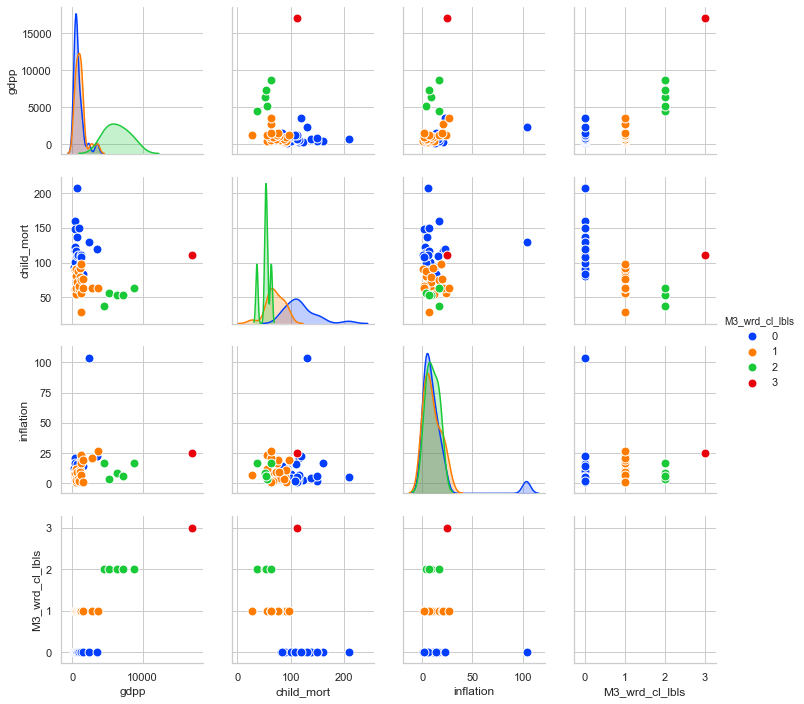

In [239]:
# Scattered Correlogram  plot 
sns.pairplot(bkwd_c_df[pc_cols_3], kind="scatter", hue="M3_wrd_cl_lbls", plot_kws=dict(s=80, linewidth=1), palette="bright")
plt.show()

* We could clearly see that K-Means clustering, the 4 clusters are segregated and grouped as different clusters in 3 Dimensional wrt PC1, PC2 and PC3.

In [240]:
bkwd_c_df[bkwd_c_df.M3_wrd_cl_lbls==0]

country  child_mort  income  inflation  life_expec  \
26                    Burundi        93.6     764     12.300        57.7   
37              Congo_Dem_Rep       116.0     609     20.800        57.5   
112                     Niger       123.0     814      2.550        58.8   
132              Sierra_Leone       160.0    1220     17.200        55.0   
106                Mozambique       101.0     918      7.640        54.5   
31   Central_African_Republic       149.0     888      2.010        47.5   
94                     Malawi        90.5    1030     12.100        53.1   
64              Guinea_Bissau       114.0    1390      2.970        55.6   
0                 Afghanistan        90.2    1610      9.440        56.2   
25               Burkina_Faso       116.0    1430      6.810        57.9   
155                    Uganda        81.0    1540     10.600        56.8   
63                     Guinea       109.0    1190     16.100        58.0   
66                      Haiti       208.0    1500      5.450        32.1   
97                       Mali       137.0    1870      4.370        59.5   
17                      Benin       111.0    1820      0.885        61.8   
32                       Chad       150.0    1930      6.390        56.5   
87                    Lesotho        99.7    2380      4.150        46.5   
40              Cote_d_Ivoire       111.0    2690      5.390        56.3   
28                   Cameroon       108.0    2660      1.910        57.3   
166                    Zambia        83.1    3280     14.000        52.0   
113                   Nigeria       130.0    5150    104.000        60.5   
3                      Angola       119.0    5900     22.400        60.1   

     total_fer  gdpp  exports_per_cap  health_per_cap  imports_per_cap  \
26        6.26   231          20.6052         26.7960           90.552   
37        6.54   334         137.2740         26.4194          165.664   
112       7.49   348          77.2560         17.9568          170.868   
132       5.20   399          67.0320         52.2690          137.655   
106       5.56   419         131.9850         21.8299          193.578   
31        5.21   446          52.6280         17.7508          118.190   
94        5.31   459         104.6520         30.2481          160.191   
64        5.05   547          81.5030         46.4950          192.544   
0         5.82   553          55.3000         41.9174          248.297   
25        5.87   575         110.4000         38.7550          170.200   
155       6.15   595         101.7450         53.6095          170.170   
63        5.34   648         196.3440         31.9464          279.936   
66        3.33   662         101.2860         45.7442          428.314   
97        6.55   708         161.4240         35.2584          248.508   
17        5.36   758         180.4040         31.0780          281.976   
32        6.59   897         330.0960         40.6341          390.195   
87        3.30  1170         460.9800        129.8700         1181.700   
40        5.27  1220         617.3200         64.6600          528.260   
28        5.11  1310         290.8200         67.2030          353.700   
166       5.40  1460         540.2000         85.9940          451.140   
113       5.84  2330         589.4900        118.1310          405.420   
3         6.16  3530        2199.1900        100.6050         1514.370   

     M2_K_M_Lbls  M3_wrd_cl_lbls  M3_Hr_Lbls  M3_K_M_Lbls  
26             1               0           0            1  
37             1               0           0            1  
112            1               0           0            1  
132            1               0           1            1  
106            1               0           0            1  
31             1               0           1            1  
94             1               0           0            1  
64             1               0           0            1  
0              1              

In [241]:
bkwd_c_df[bkwd_c_df.M3_wrd_cl_lbls==1]

country  child_mort  income  inflation  life_expec  total_fer  \
88           Liberia        89.3     700       5.47        60.8       5.02   
93        Madagascar        62.2    1390       8.79        60.8       4.60   
50           Eritrea        55.2    1420      11.60        61.7       4.61   
150             Togo        90.3    1210       1.18        58.7       4.87   
56            Gambia        80.3    1660       4.30        65.5       5.71   
126           Rwanda        63.6    1350       2.61        64.6       4.51   
147         Tanzania        71.9    2090       9.25        59.3       5.43   
36           Comoros        88.2    1410       3.87        65.9       4.75   
80             Kenya        62.2    2480       2.09        62.8       4.37   
129          Senegal        66.8    2180       1.85        64.0       5.06   
116         Pakistan        92.1    4280      10.90        65.3       3.85   
84               Lao        78.9    3980       9.20        63.8       3.15   
99        Mauritania        97.4    3320      18.90        68.2       4.98   
136  Solomon_Islands        28.1    1780       6.81        61.7       4.24   
165            Yemen        56.3    4480      23.60        67.5       4.67   
59             Ghana        74.7    3060      16.60        62.2       4.27   
142            Sudan        76.7    3370      19.60        66.3       4.88   
81          Kiribati        62.7    1730       1.52        60.7       3.84   
38         Congo_Rep        63.9    5190      20.70        60.4       4.95   
149      Timor_Leste        62.6    1850      26.50        71.1       6.23   

     gdpp  exports_per_cap  health_per_cap  imports_per_cap  M2_K_M_Lbls  \
88    327          62.4570         38.5860          302.802            1   
93    413         103.2500         15.5701          177.590            1   
50    482          23.0878         12.8212          112.306            1   
150   488         196.1760         37.3320          279.624            1   
56    562         133.7560         31.9778          239.974            1   
126   563          67.5600         59.1150          168.900            1   
147   702         131.2740         42.1902          204.282            1   
36    769         126.8850         34.6819          397.573            1   
80    967         200.1690         45.9325          324.912            1   
129  1000         249.0000         56.6000          403.000            1   
116  1040         140.4000         22.8800          201.760            1   
84   1140         403.5600         50.9580          562.020            1   
99   1200         608.4000         52.9200          734.400            1   
136  1290         635.9700        110.2950         1047.480            1   
165  1310         393.0000         67.8580          450.640            1   
59   1310         386.4500         68.3820          601.290            1   
142  1480         291.5600         93.5360          254.560            1   
81   1490         198.1700        168.3700         1190.510            1   
38   2740        2331.7400         67.4040         1498.780            1   
149  3600          79.2000        328.3200         1000.800            1   

     M3_wrd_cl_lbls  M3_Hr_Lbls  M3_K_M_Lbls  
88                1           0            1  
93                1           0            1  
50                1           0            1  
150               1           0            1  
56                1           0            1  
126               1           0            1  
147               1           0            1  
36                1           0            1  
80                1           0            1  
129               1           0            1  
116               1           0            1  
84                1           0            1  
99                1           0            1  
136               1           0            1  
165               1           0            1  
59                1      

In [242]:
bkwd_c_df[bkwd_c_df.M3_wrd_cl_lbls==2]

country  child_mort  income  inflation  life_expec  total_fer  gdpp  \
72           Iraq        36.9   12700      16.60        67.2       4.56  4500   
108       Namibia        56.0    8460       3.56        58.6       3.60  5190   
21       Botswana        52.5   13300       8.92        57.1       2.88  6350   
137  South_Africa        53.7   12000       6.35        54.3       2.59  7280   
55          Gabon        63.7   15400      16.60        62.9       4.08  8750   

     exports_per_cap  health_per_cap  imports_per_cap  M2_K_M_Lbls  \
72           1773.00         378.450          1534.50            1   
108          2480.82         351.882          3150.33            1   
21           2768.60         527.050          3257.55            1   
137          2082.08         650.832          1994.72            1   
55           5048.75         306.250          1653.75            1   

     M3_wrd_cl_lbls  M3_Hr_Lbls  M3_K_M_Lbls  
72                2           0            0  
108               2           0            0  
21                2           0            0  
137               2           0            0  
55                2           0            0

In [243]:
bkwd_c_df[bkwd_c_df.M3_wrd_cl_lbls==3]

country  child_mort  income  inflation  life_expec  total_fer  \
49  Equatorial_Guinea       111.0   33700       24.9        60.9       5.21   

     gdpp  exports_per_cap  health_per_cap  imports_per_cap  M2_K_M_Lbls  \
49  17100          14671.8          766.08          10071.9            1   

    M3_wrd_cl_lbls  M3_Hr_Lbls  M3_K_M_Lbls  
49               3           3            2